<a href="https://colab.research.google.com/github/SH22Hwang/KoGES_OP/blob/master/OP_20231025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 골다공증

다양한 모델로 돌려보았다~

- Traditional ML
  + KNN
  + Decison Tree
  + SVM <- 공부 좀 해야할 듯
- GBDT
  + XGBoost
  + LGBM
- DNN
  + MLP

## 총 정리

- 각 데이터 별로 나눠서 돌리기
  - 대상
    - 폐경 전
    - 폐경 후
    - 모든 여성
  - Feature : 일단 하나만 진행
    - 식이패턴만
    - ~~유전체만~~
    - ~~둘 다~~

- 전처리 / 증강은 X_train만 할 것

- Normalization은 따로따로
  - train, val : fit
  - test : fit_transform

- catboost 도입

- imbalaced에 적합한 metric
  - f1 score
  - PR AUC
  - 사용하지 말 것
    - accuracy
    - ROC AUC

- SVM도 잘 만들어볼 것

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as fn
from torch.utils.data import DataLoader, TensorDataset, Dataset

import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, Normalizer, QuantileTransformer

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score # 참고용
from sklearn.metrics import f1_score, precision_recall_curve # metric

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler # X_test... 사용 안 함.

from xgboost import XGBClassifier
import lightgbm as lgb

import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
!pip install category_encoders
import category_encoders as ce
sklearn.set_config(transform_output="pandas")

In [ ]:
# 데이터 불러오기
# _all: 폐경 전 후 snp까지 모두

X_all = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/X_231005.csv', index_col=0)
y_all = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/y_231005.csv', index_col=0)

y_premeno = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PreProcessed/y_premeno_20230821.csv', index_col=0)
y_postmeno = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PreProcessed/y_postmeno_20230821.csv', index_col=0)

var_to_use = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PreProcessed/var_to_use_2023-06-13T1650I.csv')

In [ ]:
X_all.info()

## 데이터 전처리

- train set: 0.8
  - train set: 0.64
  - val set: 0.16
- test set: 0.2

[참고 자료](https://ysyblog.tistory.com/69)


- 데이터셋 만들 수 있는 경우의 수 총 9개
  1. 폐경 전 / 식이패턴 있음, 유전체 없음
  2. 폐경 후 / 식이패턴 있음, 유전체 없음
  3. 모두 / 식이패턴 있음, 유전체 없음
  4. 폐경 전 / 식이패턴 없음, 유전체 있음
  5. 폐경 후 / 식이패턴 없음, 유전체 있음
  6. 모두 / 식이패턴 없음, 유전체 있음
  7. 폐경 전 / 식이패턴 있음, 유전체 있음
  8. 폐경 후 / 식이패턴 있음, 유전체 있음
  9. 모두 / 식이패턴 있음, 유전체 있음

### 통계적 수치 측정

In [ ]:
# Statistical Accuracy Measurement Comprehensive Gift Set
def SAMCGS(y_test, y_pred):
  # 정확도 종합 선물 세트
  accuracy = accuracy_score(y_test, y_pred)
  conf_mat = confusion_matrix(y_test, y_pred)
  # [[TP  FN]
  # [ FP  TN]]

  precision = precision_score(y_test, y_pred, zero_division=1) # tp / (tp + fp)
  recall = recall_score(y_test, y_pred, zero_division=1)       # tp / (tp + fn)
  f1 = f1_score(y_test, y_pred, zero_division=1) # 2 * (precision * recall) / (precision + recall)

  print(f''' Confusion Matrix:\n{conf_mat}\n
  [[TP  FN]
  [ FP  TN]]

  Accuracy: {accuracy:.3f}
  Precison: {precision:.3f}
  Recall  : {recall:.3f}
  F1 Score: {f1:.3f}'''
  )

  # return precision, recall, f1

In [ ]:
quantile_transformer = QuantileTransformer(random_state=415)
norm = Normalizer()

# Define catboost encoder
cbe_encoder = ce.cat_boost.CatBoostEncoder()

smt = SMOTE(random_state=415)
rus = RandomUnderSampler(random_state=415)

In [ ]:
# 9가지 경우의 수에 맞게 데이터 돌림

meno1 = X_all['AS1_PMYN_C'] == 1
meno2 = X_all['AS1_PMYN_C'] == 2
snp = pd.Series(['SNP_A-2181021', 'SNP_A-1809518', 'SNP_A-2130710', 'SNP_A-2263153',
                 'SNP_A-2310995', 'SNP_A-1922415', 'SNP_A-2266073', 'SNP_A-1984271',
                 'SNP_A-2218697', 'SNP_A-1850320', 'SNP_A-4262878', 'SNP_A-4299800',
                 'SNP_A-2242511'])

onehot = pd.concat([var_to_use['cath0'].dropna(), snp], ignore_index=True)

# 유전체 없이 var_to_use['cath0'].dropna() 만으로는 float밖에 없어서 astype으로 str로 변경
cath0_dict = {k: 'str' for k in var_to_use['cath0'].dropna().unique()}
cath0_snp_dict = {k: 'str' for k in onehot.unique()}

In [ ]:
cath0_snp_dict

### Split 클래스

In [ ]:
# class화
# class Split:
#   def __init__(self, x, y):
#     self.norm = Normalizer()

#     # 공통코드
#     self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=415)

#     self.x_train = self.norm.fit_transform(self.x_train).astype('float') # norm 학습 train normalize
#     self.x_test = self.norm.transform(self.x_test).astype('float')       # test normalize
#     self.x_train, self.y_train = smt.fit_resample(self.x_train, self.y_train) # train 증강

#   def tt(self):
#     return self.x_train, self.x_test, self.y_train, self.y_test

#   def ttv(self):
#     self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(self.x_train, self.y_train, test_size=0.2, stratify=self.y_train, random_state=415)
#     return self.x_train, self.x_test, self.x_val, self.y_train, self.y_test, self.y_val




# def split_ttv(x, y):
#   x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=415) # stratify: target의 class비율에 맞춰서 분리
#   x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=415) # stratify: target의 class비율에 맞춰서 분리
#   # 다른 걸로 바꿔보기..?
#   x_train = pd.DataFrame(norm.fit_transform(x_train).astype('float'))
#   x_test = pd.DataFrame(norm.transform(x_test).astype('float'))
#   x_val = pd.DataFrame(norm.transform(x_val).astype('float'))

#   # train 증강, test, val 컷
#   x_train, y_train = smt.fit_resample(x_train, y_train)
#   # x_test, y_test = rus.fit_resample(x_test, y_test)
#   # x_val, y_val = rus.fit_resample(x_val, y_val)

#   return x_train, x_test, x_val, y_train, y_test, y_val

# def split_tt(x, y):
#   # train : test == 4 : 1
#   x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=415) # stratify: target의 class비율에 맞춰서 분리

#   # 각각 하기?
#   # x_train = pd.DataFrame(quantile_transformer.fit_transform(x_train), index=x_train.index, columns=x_train.columns).astype('float')
#   # x_test = pd.DataFrame(quantile_transformer.transform(x_test), index=x_test.index, columns=x_test.columns).astype('float')

#   # 다른 걸로 바꿔보기..?
#   x_train = pd.DataFrame(norm.fit_transform(x_train).astype('float'))
#   x_test = pd.DataFrame(norm.transform(x_test).astype('float'))

#   # train 증강, test 컷
#   x_train, y_train = smt.fit_resample(x_train, y_train)
#   # x_test, y_test = rus.fit_resample(x_test, y_test)

#   return x_train, x_test, y_train, y_test

### Creating train/test/val split with StratifiedKFold

출처: https://stackoverflow.com/questions/45221940/creating-train-test-val-split-with-stratifiedkfold

In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split

class StratifiedKFold3(StratifiedKFold):
    def split(self, X, y, groups=None):
        s = super().split(X, y, groups)
        for train_indxs, test_indxs in s:
            y_train = y[train_indxs]
            train_indxs, cv_indxs = train_test_split(train_indxs,stratify=y_train, test_size=(1 / (self.n_splits - 1)))
            yield train_indxs, cv_indxs, test_indxs

In [ ]:
# 1. 폐경 전 / 식이패턴 있음, 유전체 없음
# x = X_all.drop(snp, axis=1)
# x = pd.get_dummies(x.loc[meno1], columns=var_to_use['cath0'].dropna(), drop_first=True, dtype='float64')
# y = y_premeno
# f1score 거의 0

# 2. 폐경 후 / 식이패턴 있음, 유전체 없음
# x = X_all.loc[meno2].drop(snp, axis=1).astype(cath0_dict)
# y = y_postmeno

# # Fit encoder and transform the features
# cbe_encoder.fit(x, y)
# x = cbe_encoder.transform(x)

# 3. 모두 / 식이패턴 있음, 유전체 없음
# x = X_all.drop(snp, axis=1)
# x = pd.get_dummies(X_all, columns=onehot, drop_first=True, dtype='float64')
# y = y_all

# 4, 5, 6 생략

# 7. 폐경 전 / 식이패턴 있음, 유전체 있음
# x = pd.get_dummies(X_all.loc[meno1], columns=onehot, drop_first=True, dtype='float64')
# y = y_premeno
# f1score 거의 0

# # 8 폐경 후 / 식이패턴 있음, 유전체 있음
x = X_all.loc[meno2].astype(cath0_dict)
y = y_postmeno
cbe_encoder.fit(x, y)
x = cbe_encoder.transform(x)
#### 정확도 매우 떨어짐

# # 9 모두 / 식이패턴 없음, 유전체 있음
# x = pd.get_dummies(X_all, columns=onehot, drop_first=True, dtype='float64')
# y = y_all

In [ ]:
pd.set_option('display.max_seq_items', None)
x.loc[:, var_to_use['cath0'].dropna().unique()]

In [ ]:
x.head()

,AS1_SEX,AS1_HT,AS1_DM,AS1_AL,AS1_MI,AS1_TH,AS1_CH,AS1_CD,AS1_LP,AS1_AS,...,SNP_A-2263153,SNP_A-2310995,SNP_A-1922415,SNP_A-2266073,SNP_A-1984271,SNP_A-2218697,SNP_A-1850320,SNP_A-4262878,SNP_A-4299800,SNP_A-2242511
NIH2307137554,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.284524,0.327304,0.316469,0.286146,0.276973,0.273562,0.274519,0.282510,0.28286,0.282456
NIH2307649667,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.284524,0.255167,0.278391,0.286146,0.285707,0.284207,0.287136,0.282510,0.28286,0.282456
NIH2307899915,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.284524,0.255167,0.278391,0.286146,0.285707,0.273562,0.287136,0.267238,0.28286,0.282456
NIH2307202612,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.284524,0.255167,0.278391,0.286146,0.283900,0.284207,0.287136,0.267238,0.28286,0.282456
NIH2307895121,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.284524,0.255167,0.316469,0.286146,0.283900,0.284207,0.287136,0.267238,0.28286,0.282456


## Decision Tree

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

In [ ]:
scores = []
# Defining the hyper parameters
hps = {
    'max_depth': 5,
    'min_samples_split': 2
}
# Loading the tree object
tree = DecisionTreeClassifier(**hps)

str_kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 415)
# kf3 = StratifiedKFold3(n_splits = 5, shuffle = True, random_state = 415)

# split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
for i, indexes in enumerate(str_kf.split(x, y), start=1):
  train_index = indexes[0]
  test_index = indexes[1]


  X_train = x.iloc[train_index]
  X_test = x.iloc[test_index]
  y_train = y.iloc[train_index]
  y_test = y.iloc[test_index]

  X_train, y_train = smt.fit_resample(X_train, y_train)

  tree.fit(X_train, y_train)

  y_pred = tree.predict(X_test)

  print(f"iter:{i}")
  SAMCGS(y_test, y_pred)

  scores.append(round(f1_score(y_test, y_pred, zero_division=1), 4))

print(f''' scores
최소: {min(scores)}
최대: {max(scores)}
평균: {np.mean(scores)}
''')

iter:1
 Confusion Matrix:
[[304  66]
 [101  43]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.675
  Precison: 0.394
  Recall  : 0.299
  F1 Score: 0.340
iter:2
 Confusion Matrix:
[[285  84]
 [ 97  48]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.648
  Precison: 0.364
  Recall  : 0.331
  F1 Score: 0.347
iter:3
 Confusion Matrix:
[[305  64]
 [ 85  59]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.710
  Precison: 0.480
  Recall  : 0.410
  F1 Score: 0.442
iter:4
 Confusion Matrix:
[[265 104]
 [ 78  66]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.645
  Precison: 0.388
  Recall  : 0.458
  F1 Score: 0.420
iter:5
 Confusion Matrix:
[[233 136]
 [ 68  76]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.602
  Precison: 0.358
  Recall  : 0.528
  F1 Score: 0.427
 scores
최소: 0.3399
최대: 0.4419
평균: 0.39516



### 그래프

In [ ]:
# Defining the hyper parameters
hps = {
    'max_depth': 5,
    'min_samples_split': 4
}

# Loading the tree object
tree = DecisionTreeClassifier(**hps)

tree.fit(x, y)

DecisionTreeClassifier(max_depth=5, min_samples_split=4)

In [ ]:
export_graphviz(tree, out_file="tree.dot",
                class_names='FT',
                feature_names=x.columns,
                impurity=True, filled=True)

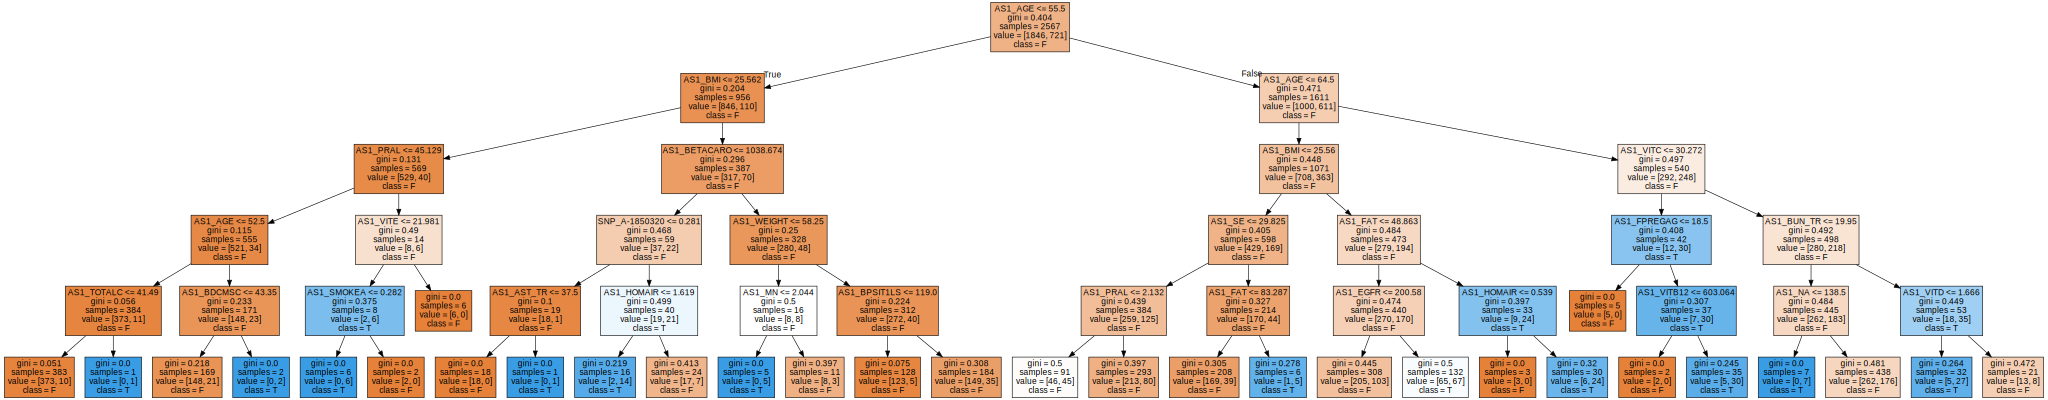

In [ ]:
with open("tree.dot") as f:
    dot_graph = f.read()

graphviz.Source(dot_graph, filename='tree.png',format='png')

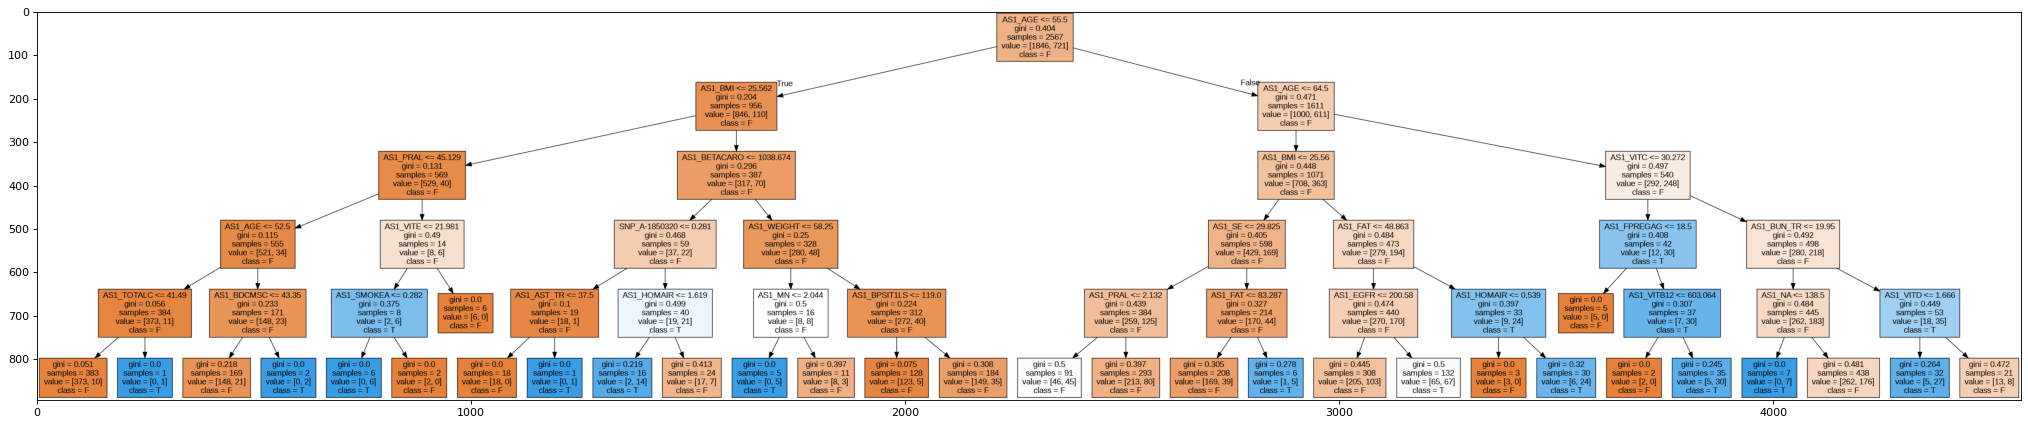

In [ ]:
!dot -Tpng tree.dot -o tree.png

tree_img = plt.imread('./tree.png')

plt.figure(num=None, figsize=(32, 9), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(tree_img)

### importance

In [ ]:
# Extracting the importances by sklearn
importances_sk = tree.feature_importances_

# Creating a dataframe with the feature importance by sklearn
feature_importance_sk = {}
for i, feature in enumerate(X_test.columns.tolist()):
    feature_importance_sk[feature] = round(importances_sk[i], 3)

print(f"Feature importance by sklearn: {feature_importance_sk}")

Feature importance by sklearn: {'AS1_SEX': 0.0, 'AS1_HT': 0.0, 'AS1_DM': 0.0, 'AS1_AL': 0.0, 'AS1_MI': 0.0, 'AS1_TH': 0.0, 'AS1_CH': 0.0, 'AS1_CD': 0.0, 'AS1_LP': 0.0, 'AS1_AS': 0.0, 'AS1_CL': 0.0, 'AS1_KD': 0.0, 'AS1_CV': 0.0, 'AS1_GT': 0.0, 'AS1_ARRM': 0.0, 'AS1_DRST': 0.0, 'AS1_DRCP': 0.0, 'AS1_DRINS': 0.0, 'AS1_DRHT': 0.0, 'AS1_DRAR': 0.0, 'AS1_DRTH': 0.0, 'AS1_DRFH': 0.0, 'AS1_DROS': 0.0, 'AS1_DRSTK': 0.0, 'AS1_DRAS': 0.0, 'AS1_DRLP': 0.0, 'AS1_DRSP': 0.0, 'AS1_DRSL': 0.0, 'AS1_PMYN_C': 0.0, 'AS1_PREG': 0.0, 'AS1_HYST': 0.0, 'AS1_OBGYOP': 0.0, 'AS1_BRCA': 0.0, 'AS1_BRSTF': 0.0, 'AS1_INSM': 0.0, 'AS1_SLPHRD': 0.0, 'AS1_EDUA': 0.0, 'AS1_DRINK': 0.0, 'AS1_SMOKEA': 0.014, 'AS1_FMOSREL_N': 0.0, 'AS1_FMOSREL_O': 0.0, 'AS1_FMOSREL_P': 0.0, 'AS1_FMOSREL_S': 0.0, 'AS1_HYSTOVARYW': 0.0, 'AS1_OVARYW': 0.0, 'AS1_INCOME': 0.0, 'AS1_PHYSTB': 0.0, 'AS1_PHYSIT': 0.0, 'AS1_PHYACTL': 0.0, 'AS1_PHYACTM': 0.0, 'AS1_PHYACTH': 0.0, 'AS1_ICOFF_1': 0.0, 'AS1_AGE': 0.441, 'AS1_TOTALC': 0.009, 'AS1_PMAG_C'

Text(0, 0.5, 'feature importance')

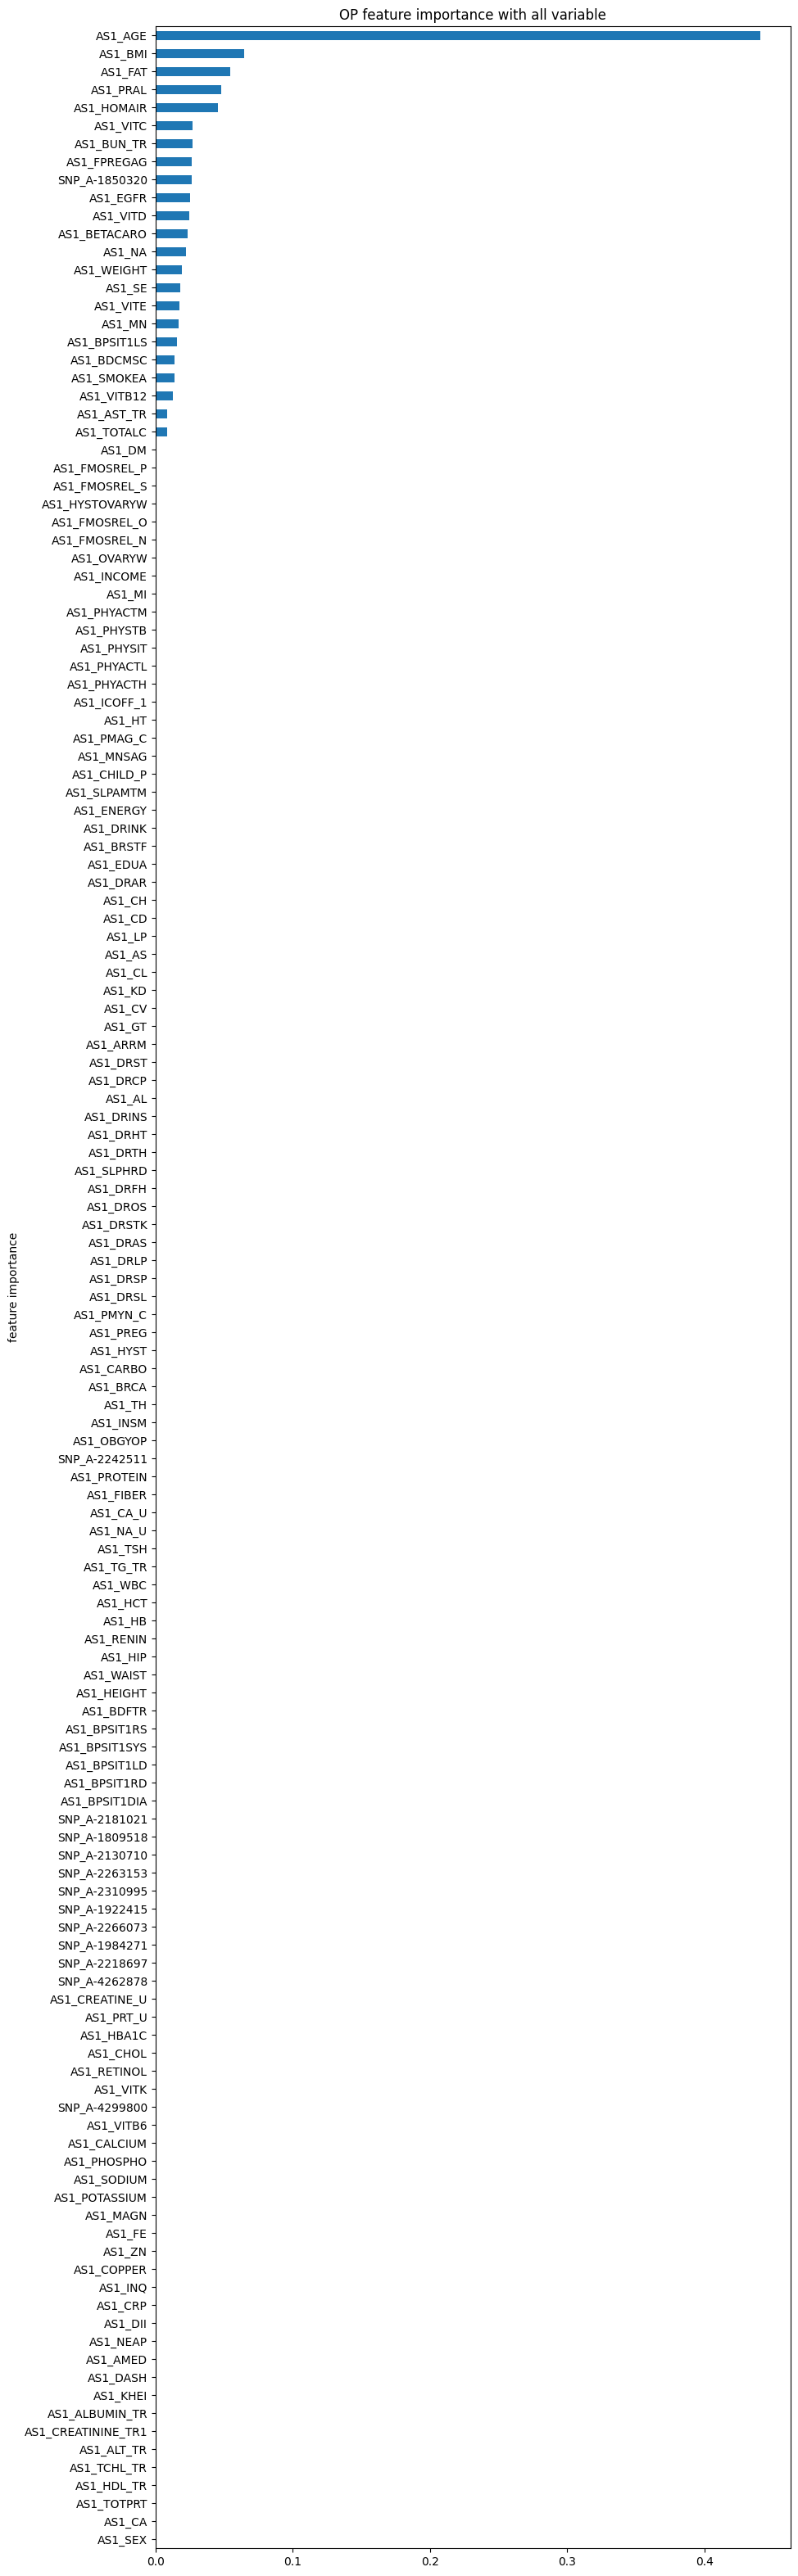

In [ ]:
importances = tree.feature_importances_

tree_importances = pd.Series(importances, index=X_test.columns).sort_values()
fig, ax = plt.subplots(figsize=(10, 40))
tree_importances.plot.barh(ax=ax)
ax.set_title("OP feature importance with all variable")
ax.set_ylabel("feature importance")

In [ ]:
tree_importances

AS1_SEX        0.000000
AS1_CA         0.000000
AS1_TOTPRT     0.000000
AS1_HDL_TR     0.000000
AS1_TCHL_TR    0.000000
                 ...   
AS1_HOMAIR     0.045641
AS1_PRAL       0.047789
AS1_FAT        0.054638
AS1_BMI        0.064767
AS1_AGE        0.440768
Length: 140, dtype: float64

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)
# knn.fit(X_train, y_train)

# y_pred = knn.predict(X_test)

In [ ]:
scores = []

str_kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 415)

# split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
for i, indexes in enumerate(str_kf.split(x, y), start=1):
  train_index = indexes[0]
  test_index = indexes[1]

  X_train = x.iloc[train_index]
  X_test = x.iloc[test_index]
  y_train = y.iloc[train_index]
  y_test = y.iloc[test_index]

  X_train, y_train = smt.fit_resample(X_train, y_train)

  knn.fit(X_train, y_train)

  y_pred = knn.predict(X_test)

  print(f"iter:{i}")
  SAMCGS(y_test, y_pred)

  scores.append(round(f1_score(y_test, y_pred, zero_division=1), 4))

print(f''' scores
최소: {min(scores)}
최대: {max(scores)}
평균: {np.mean(scores)}
''')

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


iter:1
 Confusion Matrix:
[[266 104]
 [112  32]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.580
  Precison: 0.235
  Recall  : 0.222
  F1 Score: 0.229


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


iter:2
 Confusion Matrix:
[[290  79]
 [105  40]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.642
  Precison: 0.336
  Recall  : 0.276
  F1 Score: 0.303


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


iter:3
 Confusion Matrix:
[[281  88]
 [ 99  45]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.635
  Precison: 0.338
  Recall  : 0.312
  F1 Score: 0.325


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


iter:4
 Confusion Matrix:
[[273  96]
 [107  37]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.604
  Precison: 0.278
  Recall  : 0.257
  F1 Score: 0.267
iter:5
 Confusion Matrix:
[[280  89]
 [107  37]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.618
  Precison: 0.294
  Recall  : 0.257
  F1 Score: 0.274
 scores
최소: 0.2286
최대: 0.3249
평균: 0.27954



/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


## SVM

In [ ]:
# Define the linear SVM model
class SVM(nn.Module):
    def __init__(self, input_dim):
        super(SVM, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)

    def forward(self, x):
        x = self.fc1(x)
        return x

In [ ]:
scores = []

# split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
str_kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 415)

for i, indexes in enumerate(str_kf.split(x, y), start=1):
  train_index = indexes[0]
  test_index = indexes[1]

  X_train = x.iloc[train_index]
  X_test = x.iloc[test_index]
  y_train = y.iloc[train_index]
  y_test = y.iloc[test_index]

  X_train = norm.fit_transform(X_train).astype('float') # norm 학습 train normalize
  X_test = norm.transform(X_test).astype('float')       # test normalize
  X_train, y_train = smt.fit_resample(X_train, y_train)

  X_train_tensor = torch.tensor(X_train.values).float()
  X_test_tensor = torch.tensor(X_test.values).float()
  y_train_tensor = torch.tensor(y_train.values).float()
  y_test_tensor = torch.tensor(y_test.values).float()

  svm = SVM(X_train.shape[1])

  # Define the loss function and optimizer
  criterion = nn.HingeEmbeddingLoss()
  optimizer = optim.SGD(svm.parameters(), lr=0.01)

   # Train the model
  for epoch in range(100):
      output = svm(X_train_tensor)

      loss = criterion(output, 2 * y_train_tensor.float()-1)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  # Make predictions on the test set
  y_pred = torch.sign(svm(X_test_tensor).squeeze()).detach().numpy()
  y_pred = np.where(y_pred < 0, 0, 1)

  print(f"iter:{i}")
  SAMCGS(y_test, y_pred)

  scores.append(round(f1_score(y_test, y_pred, zero_division=1), 4))

print(f''' scores
최소: {min(scores)}
최대: {max(scores)}
평균: {np.mean(scores)}
''')

iter:1
 Confusion Matrix:
[[333  37]
 [120  24]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.695
  Precison: 0.393
  Recall  : 0.167
  F1 Score: 0.234
iter:2
 Confusion Matrix:
[[196 173]
 [ 75  70]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.518
  Precison: 0.288
  Recall  : 0.483
  F1 Score: 0.361
iter:3
 Confusion Matrix:
[[353  16]
 [134  10]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.708
  Precison: 0.385
  Recall  : 0.069
  F1 Score: 0.118
iter:4
 Confusion Matrix:
[[344  25]
 [131  13]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.696
  Precison: 0.342
  Recall  : 0.090
  F1 Score: 0.143
iter:5
 Confusion Matrix:
[[350  19]
 [134  10]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.702
  Precison: 0.345
  Recall  : 0.069
  F1 Score: 0.116
 scores
최소: 0.1156
최대: 0.3608
평균: 0.1942



## XGBoost

In [ ]:
from sklearn.model_selection import GridSearchCV

# create model instance
xgb = XGBClassifier(n_estimators=1000, # 나무의 개수
                    learning_rate=0.01,
                    # early_stopping_rounds=30,
                    objective='binary:logistic',
                    # eval_metric='aucpr', # auc -> aucpr
                    # eval_set=[(X_val, y_val)],
                    silent=0)

# 후보 파라미터 선정
params = {'max_depth':[3, 8], 'min_child_weight':[1, 3], 'colsample_bytree':[0,1]}

# gridsearchcv 객체 정보 입력(어떤 모델, 파라미터 후보, 교차검증 몇 번)
gridcv = GridSearchCV(xgb, param_grid=params, cv=3)

In [ ]:
str_kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 415)

# split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
for i, indexes in enumerate(str_kf.split(x, y), start=1):
  train_index = indexes[0]
  test_index = indexes[1]

  X_train = x.iloc[train_index]
  X_test = x.iloc[test_index]
  y_train = y.iloc[train_index]
  y_test = y.iloc[test_index]

  X_train = norm.fit_transform(X_train).astype('float') # norm 학습 train normalize
  X_test = norm.transform(X_test).astype('float')       # test normalize
  X_train, y_train = smt.fit_resample(X_train, y_train)

  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=415)

  X_train_tensor = torch.tensor(X_train.values).float()
  X_test_tensor = torch.tensor(X_test.values).float()
  X_val_tensor = torch.tensor(X_val.values).float()
  y_train_tensor = torch.tensor(y_train.values).float()
  y_test_tensor = torch.tensor(y_test.values).float()
  y_val_tensor = torch.tensor(y_val.values).float()

  gridcv.fit(X_train, y_train,
            early_stopping_rounds=30,
            eval_metric='aucpr', # auc -> aucpr
            eval_set=[(X_val, y_val)])

  gridcv.fit(X_train, y_train)

  model = gridcv.best_estimator_
  y_pred = model.predict(X_test)

  print(f"iter:{i}")
  SAMCGS(y_test, y_pred)

  scores.append(f1_score(y_test, y_pred, zero_division=1))

[0]	validation_0-aucpr:0.49662
[1]	validation_0-aucpr:0.49770
[2]	validation_0-aucpr:0.68679
[3]	validation_0-aucpr:0.67576
[4]	validation_0-aucpr:0.68089


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:49:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-aucpr:0.66199
[6]	validation_0-aucpr:0.64780
[7]	validation_0-aucpr:0.64608
[8]	validation_0-aucpr:0.64717
[9]	validation_0-aucpr:0.65359
[10]	validation_0-aucpr:0.64626
[11]	validation_0-aucpr:0.64202
[12]	validation_0-aucpr:0.63837
[13]	validation_0-aucpr:0.63907
[14]	validation_0-aucpr:0.65926
[15]	validation_0-aucpr:0.66372
[16]	validation_0-aucpr:0.66918
[17]	validation_0-aucpr:0.67306
[18]	validation_0-aucpr:0.66205
[19]	validation_0-aucpr:0.65672
[20]	validation_0-aucpr:0.71044
[21]	validation_0-aucpr:0.71026
[22]	validation_0-aucpr:0.70699
[23]	validation_0-aucpr:0.70907
[24]	validation_0-aucpr:0.73389
[25]	validation_0-aucpr:0.73271
[26]	validation_0-aucpr:0.72625
[27]	validation_0-aucpr:0.72536
[28]	validation_0-aucpr:0.71640
[29]	validation_0-aucpr:0.71575
[30]	validation_0-aucpr:0.71542
[31]	validation_0-aucpr:0.71977
[32]	validation_0-aucpr:0.71879
[33]	validation_0-aucpr:0.71414
[34]	validation_0-aucpr:0.70880
[35]	validation_0-aucpr:0.70785
[36]	validati

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:49:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-aucpr:0.66564
[7]	validation_0-aucpr:0.65658
[8]	validation_0-aucpr:0.67220
[9]	validation_0-aucpr:0.67240
[10]	validation_0-aucpr:0.67257
[11]	validation_0-aucpr:0.67085
[12]	validation_0-aucpr:0.66891
[13]	validation_0-aucpr:0.65939
[14]	validation_0-aucpr:0.67008
[15]	validation_0-aucpr:0.67128
[16]	validation_0-aucpr:0.67238
[17]	validation_0-aucpr:0.67332
[18]	validation_0-aucpr:0.66770
[19]	validation_0-aucpr:0.66617
[20]	validation_0-aucpr:0.71266
[21]	validation_0-aucpr:0.71336
[22]	validation_0-aucpr:0.70187
[23]	validation_0-aucpr:0.70828
[24]	validation_0-aucpr:0.73618
[25]	validation_0-aucpr:0.72710
[26]	validation_0-aucpr:0.71732
[27]	validation_0-aucpr:0.71872
[28]	validation_0-aucpr:0.71502
[29]	validation_0-aucpr:0.71781
[30]	validation_0-aucpr:0.70751
[31]	validation_0-aucpr:0.70495
[32]	validation_0-aucpr:0.70433
[33]	validation_0-aucpr:0.69927
[34]	validation_0-aucpr:0.70038
[35]	validation_0-aucpr:0.69934
[36]	validation_0-aucpr:0.69999
[37]	validat

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:49:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-aucpr:0.66803
[6]	validation_0-aucpr:0.66961
[7]	validation_0-aucpr:0.65183
[8]	validation_0-aucpr:0.64833
[9]	validation_0-aucpr:0.65057
[10]	validation_0-aucpr:0.64859
[11]	validation_0-aucpr:0.65147
[12]	validation_0-aucpr:0.65552
[13]	validation_0-aucpr:0.64921
[14]	validation_0-aucpr:0.66524
[15]	validation_0-aucpr:0.66526
[16]	validation_0-aucpr:0.67832
[17]	validation_0-aucpr:0.67832
[18]	validation_0-aucpr:0.67920
[19]	validation_0-aucpr:0.67355
[20]	validation_0-aucpr:0.73413
[21]	validation_0-aucpr:0.73445
[22]	validation_0-aucpr:0.72602
[23]	validation_0-aucpr:0.72680
[24]	validation_0-aucpr:0.74272
[25]	validation_0-aucpr:0.73560
[26]	validation_0-aucpr:0.73342
[27]	validation_0-aucpr:0.73381
[28]	validation_0-aucpr:0.73331
[29]	validation_0-aucpr:0.72847
[30]	validation_0-aucpr:0.72372
[31]	validation_0-aucpr:0.72055
[32]	validation_0-aucpr:0.72241
[33]	validation_0-aucpr:0.71608
[34]	validation_0-aucpr:0.71691
[35]	validation_0-aucpr:0.70854
[36]	validati

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:49:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-aucpr:0.64978
[8]	validation_0-aucpr:0.65161
[9]	validation_0-aucpr:0.65298
[10]	validation_0-aucpr:0.64484
[11]	validation_0-aucpr:0.63889
[12]	validation_0-aucpr:0.63576
[13]	validation_0-aucpr:0.63874
[14]	validation_0-aucpr:0.65573
[15]	validation_0-aucpr:0.66089
[16]	validation_0-aucpr:0.66565
[17]	validation_0-aucpr:0.66768
[18]	validation_0-aucpr:0.65767
[19]	validation_0-aucpr:0.65543
[20]	validation_0-aucpr:0.71138
[21]	validation_0-aucpr:0.71239
[22]	validation_0-aucpr:0.70799
[23]	validation_0-aucpr:0.70695
[24]	validation_0-aucpr:0.73737
[25]	validation_0-aucpr:0.73501
[26]	validation_0-aucpr:0.72525
[27]	validation_0-aucpr:0.72094
[28]	validation_0-aucpr:0.71064
[29]	validation_0-aucpr:0.70793
[30]	validation_0-aucpr:0.71049
[31]	validation_0-aucpr:0.71336
[32]	validation_0-aucpr:0.71304
[33]	validation_0-aucpr:0.70768
[34]	validation_0-aucpr:0.70097
[35]	validation_0-aucpr:0.69878
[36]	validation_0-aucpr:0.70012
[37]	validation_0-aucpr:0.70941
[38]	valida

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:49:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-aucpr:0.65715
[8]	validation_0-aucpr:0.67346
[9]	validation_0-aucpr:0.67401
[10]	validation_0-aucpr:0.67492
[11]	validation_0-aucpr:0.67453
[12]	validation_0-aucpr:0.67484
[13]	validation_0-aucpr:0.66235
[14]	validation_0-aucpr:0.67498
[15]	validation_0-aucpr:0.67537
[16]	validation_0-aucpr:0.67608
[17]	validation_0-aucpr:0.67835
[18]	validation_0-aucpr:0.67179
[19]	validation_0-aucpr:0.67053
[20]	validation_0-aucpr:0.71748
[21]	validation_0-aucpr:0.71788
[22]	validation_0-aucpr:0.70539
[23]	validation_0-aucpr:0.70935
[24]	validation_0-aucpr:0.73774
[25]	validation_0-aucpr:0.72786
[26]	validation_0-aucpr:0.71820
[27]	validation_0-aucpr:0.71940
[28]	validation_0-aucpr:0.71311
[29]	validation_0-aucpr:0.71537
[30]	validation_0-aucpr:0.70715
[31]	validation_0-aucpr:0.70440
[32]	validation_0-aucpr:0.70406
[33]	validation_0-aucpr:0.69833
[34]	validation_0-aucpr:0.70359
[35]	validation_0-aucpr:0.70321
[36]	validation_0-aucpr:0.70401
[37]	validation_0-aucpr:0.70503
[38]	valida

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:49:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	validation_0-aucpr:0.67993
[5]	validation_0-aucpr:0.67247
[6]	validation_0-aucpr:0.67444
[7]	validation_0-aucpr:0.65903
[8]	validation_0-aucpr:0.65550
[9]	validation_0-aucpr:0.65532
[10]	validation_0-aucpr:0.65141
[11]	validation_0-aucpr:0.65230
[12]	validation_0-aucpr:0.65663
[13]	validation_0-aucpr:0.64728
[14]	validation_0-aucpr:0.66123
[15]	validation_0-aucpr:0.65858
[16]	validation_0-aucpr:0.66977
[17]	validation_0-aucpr:0.66870
[18]	validation_0-aucpr:0.67217
[19]	validation_0-aucpr:0.66591
[20]	validation_0-aucpr:0.72760
[21]	validation_0-aucpr:0.72936
[22]	validation_0-aucpr:0.72179
[23]	validation_0-aucpr:0.72372
[24]	validation_0-aucpr:0.73825
[25]	validation_0-aucpr:0.73083
[26]	validation_0-aucpr:0.71862
[27]	validation_0-aucpr:0.71885
[28]	validation_0-aucpr:0.71691
[29]	validation_0-aucpr:0.71425
[30]	validation_0-aucpr:0.70706
[31]	validation_0-aucpr:0.70616
[32]	validation_0-aucpr:0.70705
[33]	validation_0-aucpr:0.70098
[34]	validation_0-aucpr:0.70129
[35]	validatio

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:49:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.55400
[1]	validation_0-aucpr:0.55527
[2]	validation_0-aucpr:0.73392
[3]	validation_0-aucpr:0.70458
[4]	validation_0-aucpr:0.69459
[5]	validation_0-aucpr:0.64670
[6]	validation_0-aucpr:0.65361
[7]	validation_0-aucpr:0.64831
[8]	validation_0-aucpr:0.64304
[9]	validation_0-aucpr:0.64785
[10]	validation_0-aucpr:0.63553
[11]	validation_0-aucpr:0.61588
[12]	validation_0-aucpr:0.61045
[13]	validation_0-aucpr:0.61382
[14]	validation_0-aucpr:0.62427
[15]	validation_0-aucpr:0.63430
[16]	validation_0-aucpr:0.64554
[17]	validation_0-aucpr:0.65772
[18]	validation_0-aucpr:0.66253
[19]	validation_0-aucpr:0.65910
[20]	validation_0-aucpr:0.69313
[21]	validation_0-aucpr:0.69211
[22]	validation_0-aucpr:0.69126
[23]	validation_0-aucpr:0.69670
[24]	validation_0-aucpr:0.71485
[25]	validation_0-aucpr:0.71161
[26]	validation_0-aucpr:0.70567
[27]	validation_0-aucpr:0.70763
[28]	validation_0-aucpr:0.69751
[29]	validation_0-aucpr:0.69939
[30]	validation_0-aucpr:0.69173
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:49:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-aucpr:0.51470
[2]	validation_0-aucpr:0.71007
[3]	validation_0-aucpr:0.68397
[4]	validation_0-aucpr:0.64677
[5]	validation_0-aucpr:0.60496
[6]	validation_0-aucpr:0.60078
[7]	validation_0-aucpr:0.59623
[8]	validation_0-aucpr:0.59688
[9]	validation_0-aucpr:0.58932
[10]	validation_0-aucpr:0.58384
[11]	validation_0-aucpr:0.59226
[12]	validation_0-aucpr:0.59133
[13]	validation_0-aucpr:0.59137
[14]	validation_0-aucpr:0.60300
[15]	validation_0-aucpr:0.59825
[16]	validation_0-aucpr:0.60787
[17]	validation_0-aucpr:0.61551
[18]	validation_0-aucpr:0.59773
[19]	validation_0-aucpr:0.59415
[20]	validation_0-aucpr:0.63266
[21]	validation_0-aucpr:0.63260
[22]	validation_0-aucpr:0.62441
[23]	validation_0-aucpr:0.62877
[24]	validation_0-aucpr:0.65233
[25]	validation_0-aucpr:0.64441
[26]	validation_0-aucpr:0.63234
[27]	validation_0-aucpr:0.63086
[28]	validation_0-aucpr:0.62236
[29]	validation_0-aucpr:0.62873
[30]	validation_0-aucpr:0.61816
[31]	validation_0-aucpr:0.61962
[32]	validation_0

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:49:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-aucpr:0.59383
[6]	validation_0-aucpr:0.58697
[7]	validation_0-aucpr:0.56581
[8]	validation_0-aucpr:0.57210
[9]	validation_0-aucpr:0.57465
[10]	validation_0-aucpr:0.58242
[11]	validation_0-aucpr:0.58746
[12]	validation_0-aucpr:0.59047
[13]	validation_0-aucpr:0.57123
[14]	validation_0-aucpr:0.58420
[15]	validation_0-aucpr:0.56932
[16]	validation_0-aucpr:0.57887
[17]	validation_0-aucpr:0.57558
[18]	validation_0-aucpr:0.56408
[19]	validation_0-aucpr:0.56743
[20]	validation_0-aucpr:0.61384
[21]	validation_0-aucpr:0.61774
[22]	validation_0-aucpr:0.61054
[23]	validation_0-aucpr:0.61061
[24]	validation_0-aucpr:0.64825
[25]	validation_0-aucpr:0.64168
[26]	validation_0-aucpr:0.63696
[27]	validation_0-aucpr:0.64074
[28]	validation_0-aucpr:0.62930
[29]	validation_0-aucpr:0.63425
[30]	validation_0-aucpr:0.62714
[31]	validation_0-aucpr:0.62266
[32]	validation_0-aucpr:0.62347
[0]	validation_0-aucpr:0.53900
[1]	validation_0-aucpr:0.53900
[2]	validation_0-aucpr:0.70238
[3]	validation_0

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:49:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-aucpr:0.62212
[8]	validation_0-aucpr:0.62464
[9]	validation_0-aucpr:0.62576
[10]	validation_0-aucpr:0.61903
[11]	validation_0-aucpr:0.60621
[12]	validation_0-aucpr:0.59838
[13]	validation_0-aucpr:0.60386
[14]	validation_0-aucpr:0.61498
[15]	validation_0-aucpr:0.62854
[16]	validation_0-aucpr:0.63943
[17]	validation_0-aucpr:0.63923
[18]	validation_0-aucpr:0.64313
[19]	validation_0-aucpr:0.65076
[20]	validation_0-aucpr:0.68356
[21]	validation_0-aucpr:0.68196
[22]	validation_0-aucpr:0.68171
[23]	validation_0-aucpr:0.67983
[24]	validation_0-aucpr:0.70662
[25]	validation_0-aucpr:0.70078
[26]	validation_0-aucpr:0.69141
[27]	validation_0-aucpr:0.69075
[28]	validation_0-aucpr:0.68413
[29]	validation_0-aucpr:0.68579
[30]	validation_0-aucpr:0.67906
[31]	validation_0-aucpr:0.68374
[32]	validation_0-aucpr:0.68340
[33]	validation_0-aucpr:0.67613
[34]	validation_0-aucpr:0.67261
[35]	validation_0-aucpr:0.67171
[36]	validation_0-aucpr:0.67324
[37]	validation_0-aucpr:0.67977
[38]	valida

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:49:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.50422
[1]	validation_0-aucpr:0.50422
[2]	validation_0-aucpr:0.69419
[3]	validation_0-aucpr:0.67547
[4]	validation_0-aucpr:0.64146
[5]	validation_0-aucpr:0.60173
[6]	validation_0-aucpr:0.59797
[7]	validation_0-aucpr:0.59980
[8]	validation_0-aucpr:0.59672
[9]	validation_0-aucpr:0.60298
[10]	validation_0-aucpr:0.59758
[11]	validation_0-aucpr:0.59152
[12]	validation_0-aucpr:0.59260
[13]	validation_0-aucpr:0.58496
[14]	validation_0-aucpr:0.59813
[15]	validation_0-aucpr:0.59215
[16]	validation_0-aucpr:0.60465
[17]	validation_0-aucpr:0.60694
[18]	validation_0-aucpr:0.59350
[19]	validation_0-aucpr:0.58716
[20]	validation_0-aucpr:0.62806
[21]	validation_0-aucpr:0.62055
[22]	validation_0-aucpr:0.60912
[23]	validation_0-aucpr:0.61293
[24]	validation_0-aucpr:0.64440
[25]	validation_0-aucpr:0.63324
[26]	validation_0-aucpr:0.61964
[27]	validation_0-aucpr:0.61956
[28]	validation_0-aucpr:0.61186
[29]	validation_0-aucpr:0.61703
[30]	validation_0-aucpr:0.61025
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:49:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.51162
[1]	validation_0-aucpr:0.51162
[2]	validation_0-aucpr:0.71423
[3]	validation_0-aucpr:0.67854
[4]	validation_0-aucpr:0.62769
[5]	validation_0-aucpr:0.59101
[6]	validation_0-aucpr:0.57428
[7]	validation_0-aucpr:0.56530
[8]	validation_0-aucpr:0.56960
[9]	validation_0-aucpr:0.57133
[10]	validation_0-aucpr:0.57547
[11]	validation_0-aucpr:0.57986
[12]	validation_0-aucpr:0.58024
[13]	validation_0-aucpr:0.55898
[14]	validation_0-aucpr:0.57529
[15]	validation_0-aucpr:0.56293
[16]	validation_0-aucpr:0.57487
[17]	validation_0-aucpr:0.57560
[18]	validation_0-aucpr:0.57185
[19]	validation_0-aucpr:0.56606
[20]	validation_0-aucpr:0.61321
[21]	validation_0-aucpr:0.61475
[22]	validation_0-aucpr:0.60886
[23]	validation_0-aucpr:0.60720
[24]	validation_0-aucpr:0.65239
[25]	validation_0-aucpr:0.64748
[26]	validation_0-aucpr:0.63537
[27]	validation_0-aucpr:0.63689
[28]	validation_0-aucpr:0.62553
[29]	validation_0-aucpr:0.62986
[30]	validation_0-aucpr:0.61644
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:49:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-aucpr:0.71366
[3]	validation_0-aucpr:0.71534
[4]	validation_0-aucpr:0.71538
[5]	validation_0-aucpr:0.71548
[6]	validation_0-aucpr:0.71548
[7]	validation_0-aucpr:0.71548
[8]	validation_0-aucpr:0.71548
[9]	validation_0-aucpr:0.71548
[10]	validation_0-aucpr:0.71548
[11]	validation_0-aucpr:0.71548
[12]	validation_0-aucpr:0.72803
[13]	validation_0-aucpr:0.72806
[14]	validation_0-aucpr:0.72827
[15]	validation_0-aucpr:0.72822
[16]	validation_0-aucpr:0.72843
[17]	validation_0-aucpr:0.72843
[18]	validation_0-aucpr:0.73034
[19]	validation_0-aucpr:0.73119
[20]	validation_0-aucpr:0.73387
[21]	validation_0-aucpr:0.73528
[22]	validation_0-aucpr:0.73493
[23]	validation_0-aucpr:0.73560
[24]	validation_0-aucpr:0.73560
[25]	validation_0-aucpr:0.73921
[26]	validation_0-aucpr:0.73889
[27]	validation_0-aucpr:0.74159
[28]	validation_0-aucpr:0.74210
[29]	validation_0-aucpr:0.74465
[30]	validation_0-aucpr:0.74885
[31]	validation_0-aucpr:0.75202
[32]	validation_0-aucpr:0.75236
[33]	validation_

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-aucpr:0.70217
[1]	validation_0-aucpr:0.70217
[2]	validation_0-aucpr:0.70432
[3]	validation_0-aucpr:0.71159
[4]	validation_0-aucpr:0.71561


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:49:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-aucpr:0.71337
[6]	validation_0-aucpr:0.71585
[7]	validation_0-aucpr:0.73692
[8]	validation_0-aucpr:0.73912
[9]	validation_0-aucpr:0.74491
[10]	validation_0-aucpr:0.75135
[11]	validation_0-aucpr:0.75638
[12]	validation_0-aucpr:0.75725
[13]	validation_0-aucpr:0.75858
[14]	validation_0-aucpr:0.75946
[15]	validation_0-aucpr:0.76200
[16]	validation_0-aucpr:0.76230
[17]	validation_0-aucpr:0.76411
[18]	validation_0-aucpr:0.76502
[19]	validation_0-aucpr:0.76857
[20]	validation_0-aucpr:0.76634
[21]	validation_0-aucpr:0.76707
[22]	validation_0-aucpr:0.76875
[23]	validation_0-aucpr:0.76896
[24]	validation_0-aucpr:0.77133
[25]	validation_0-aucpr:0.77186
[26]	validation_0-aucpr:0.77428
[27]	validation_0-aucpr:0.77489
[28]	validation_0-aucpr:0.77544
[29]	validation_0-aucpr:0.77442
[30]	validation_0-aucpr:0.77384
[31]	validation_0-aucpr:0.77456
[32]	validation_0-aucpr:0.77545
[33]	validation_0-aucpr:0.77565
[34]	validation_0-aucpr:0.77661
[35]	validation_0-aucpr:0.77761
[36]	validati

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:49:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-aucpr:0.75485
[3]	validation_0-aucpr:0.75485
[4]	validation_0-aucpr:0.75702
[5]	validation_0-aucpr:0.75702
[6]	validation_0-aucpr:0.75614
[7]	validation_0-aucpr:0.75614
[8]	validation_0-aucpr:0.75614
[9]	validation_0-aucpr:0.75614
[10]	validation_0-aucpr:0.75614
[11]	validation_0-aucpr:0.75614
[12]	validation_0-aucpr:0.75614
[13]	validation_0-aucpr:0.75614
[14]	validation_0-aucpr:0.75614
[15]	validation_0-aucpr:0.75614
[16]	validation_0-aucpr:0.75614
[17]	validation_0-aucpr:0.75614
[18]	validation_0-aucpr:0.75614
[19]	validation_0-aucpr:0.75614
[20]	validation_0-aucpr:0.75667
[21]	validation_0-aucpr:0.75667
[22]	validation_0-aucpr:0.75667
[23]	validation_0-aucpr:0.76105
[24]	validation_0-aucpr:0.76105
[25]	validation_0-aucpr:0.76105
[26]	validation_0-aucpr:0.77097
[27]	validation_0-aucpr:0.77016
[28]	validation_0-aucpr:0.76835
[29]	validation_0-aucpr:0.76874
[30]	validation_0-aucpr:0.76605
[31]	validation_0-aucpr:0.76629
[32]	validation_0-aucpr:0.76768
[33]	validation_

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:50:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-aucpr:0.71548
[8]	validation_0-aucpr:0.71548
[9]	validation_0-aucpr:0.71548
[10]	validation_0-aucpr:0.71548
[11]	validation_0-aucpr:0.71548
[12]	validation_0-aucpr:0.72803
[13]	validation_0-aucpr:0.72806
[14]	validation_0-aucpr:0.72827
[15]	validation_0-aucpr:0.72822
[16]	validation_0-aucpr:0.72843
[17]	validation_0-aucpr:0.72843
[18]	validation_0-aucpr:0.73034
[19]	validation_0-aucpr:0.73119
[20]	validation_0-aucpr:0.73387
[21]	validation_0-aucpr:0.73528
[22]	validation_0-aucpr:0.73493
[23]	validation_0-aucpr:0.73560
[24]	validation_0-aucpr:0.73560
[25]	validation_0-aucpr:0.73921
[26]	validation_0-aucpr:0.73889
[27]	validation_0-aucpr:0.74159
[28]	validation_0-aucpr:0.74210
[29]	validation_0-aucpr:0.74465
[30]	validation_0-aucpr:0.74885
[31]	validation_0-aucpr:0.74497
[32]	validation_0-aucpr:0.74970
[33]	validation_0-aucpr:0.74948
[34]	validation_0-aucpr:0.74969
[35]	validation_0-aucpr:0.74957
[36]	validation_0-aucpr:0.75023
[37]	validation_0-aucpr:0.75020
[38]	valida

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:50:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-aucpr:0.70432
[3]	validation_0-aucpr:0.71159
[4]	validation_0-aucpr:0.71561
[5]	validation_0-aucpr:0.71337
[6]	validation_0-aucpr:0.71585
[7]	validation_0-aucpr:0.73692
[8]	validation_0-aucpr:0.73912
[9]	validation_0-aucpr:0.74491
[10]	validation_0-aucpr:0.75135
[11]	validation_0-aucpr:0.75638
[12]	validation_0-aucpr:0.75725
[13]	validation_0-aucpr:0.75858
[14]	validation_0-aucpr:0.75946
[15]	validation_0-aucpr:0.76200
[16]	validation_0-aucpr:0.76230
[17]	validation_0-aucpr:0.76411
[18]	validation_0-aucpr:0.76502
[19]	validation_0-aucpr:0.76857
[20]	validation_0-aucpr:0.76634
[21]	validation_0-aucpr:0.76707
[22]	validation_0-aucpr:0.76875
[23]	validation_0-aucpr:0.76896
[24]	validation_0-aucpr:0.77133
[25]	validation_0-aucpr:0.77186
[26]	validation_0-aucpr:0.77428
[27]	validation_0-aucpr:0.77489
[28]	validation_0-aucpr:0.77544
[29]	validation_0-aucpr:0.77442
[30]	validation_0-aucpr:0.77384
[31]	validation_0-aucpr:0.77456
[32]	validation_0-aucpr:0.77545
[33]	validation_

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:50:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-aucpr:0.75614
[8]	validation_0-aucpr:0.75614
[9]	validation_0-aucpr:0.75614
[10]	validation_0-aucpr:0.75614
[11]	validation_0-aucpr:0.75614
[12]	validation_0-aucpr:0.75614
[13]	validation_0-aucpr:0.75614
[14]	validation_0-aucpr:0.75614
[15]	validation_0-aucpr:0.75614
[16]	validation_0-aucpr:0.75614
[17]	validation_0-aucpr:0.75614
[18]	validation_0-aucpr:0.75614
[19]	validation_0-aucpr:0.75614
[20]	validation_0-aucpr:0.75667
[21]	validation_0-aucpr:0.75667
[22]	validation_0-aucpr:0.75667
[23]	validation_0-aucpr:0.76105
[24]	validation_0-aucpr:0.76105
[25]	validation_0-aucpr:0.76105
[26]	validation_0-aucpr:0.77097
[27]	validation_0-aucpr:0.77016
[28]	validation_0-aucpr:0.76835
[29]	validation_0-aucpr:0.76874
[30]	validation_0-aucpr:0.76605
[31]	validation_0-aucpr:0.76629
[32]	validation_0-aucpr:0.76768
[33]	validation_0-aucpr:0.76776
[34]	validation_0-aucpr:0.76758
[35]	validation_0-aucpr:0.76751
[36]	validation_0-aucpr:0.76809
[37]	validation_0-aucpr:0.76929
[38]	valida

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:50:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.76541
[1]	validation_0-aucpr:0.77239
[2]	validation_0-aucpr:0.75983
[3]	validation_0-aucpr:0.77185
[4]	validation_0-aucpr:0.76303
[5]	validation_0-aucpr:0.76583
[6]	validation_0-aucpr:0.75735
[7]	validation_0-aucpr:0.76354
[8]	validation_0-aucpr:0.75934
[9]	validation_0-aucpr:0.75928
[10]	validation_0-aucpr:0.76337
[11]	validation_0-aucpr:0.76246
[12]	validation_0-aucpr:0.76499
[13]	validation_0-aucpr:0.76417
[14]	validation_0-aucpr:0.77008
[15]	validation_0-aucpr:0.76710
[16]	validation_0-aucpr:0.76771
[17]	validation_0-aucpr:0.77261
[18]	validation_0-aucpr:0.77380
[19]	validation_0-aucpr:0.77712
[20]	validation_0-aucpr:0.77935
[21]	validation_0-aucpr:0.78059
[22]	validation_0-aucpr:0.78469
[23]	validation_0-aucpr:0.78713
[24]	validation_0-aucpr:0.78727
[25]	validation_0-aucpr:0.78898
[26]	validation_0-aucpr:0.78953
[27]	validation_0-aucpr:0.78967
[28]	validation_0-aucpr:0.79177
[29]	validation_0-aucpr:0.79357
[30]	validation_0-aucpr:0.79466
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:50:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.73566
[1]	validation_0-aucpr:0.72995
[2]	validation_0-aucpr:0.72792
[3]	validation_0-aucpr:0.72885
[4]	validation_0-aucpr:0.74346
[5]	validation_0-aucpr:0.74706
[6]	validation_0-aucpr:0.75120
[7]	validation_0-aucpr:0.75881
[8]	validation_0-aucpr:0.76085
[9]	validation_0-aucpr:0.76742
[10]	validation_0-aucpr:0.76984
[11]	validation_0-aucpr:0.77242
[12]	validation_0-aucpr:0.78988
[13]	validation_0-aucpr:0.78894
[14]	validation_0-aucpr:0.78961
[15]	validation_0-aucpr:0.78937
[16]	validation_0-aucpr:0.79380
[17]	validation_0-aucpr:0.79568
[18]	validation_0-aucpr:0.79841
[19]	validation_0-aucpr:0.79916
[20]	validation_0-aucpr:0.79981
[21]	validation_0-aucpr:0.80055
[22]	validation_0-aucpr:0.80285
[23]	validation_0-aucpr:0.80490
[24]	validation_0-aucpr:0.80637
[25]	validation_0-aucpr:0.80600
[26]	validation_0-aucpr:0.80937
[27]	validation_0-aucpr:0.80818
[28]	validation_0-aucpr:0.80839
[29]	validation_0-aucpr:0.80777
[30]	validation_0-aucpr:0.80996
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:51:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-aucpr:0.75127
[2]	validation_0-aucpr:0.77004
[3]	validation_0-aucpr:0.76995
[4]	validation_0-aucpr:0.77192
[5]	validation_0-aucpr:0.76996
[6]	validation_0-aucpr:0.77171
[7]	validation_0-aucpr:0.77247
[8]	validation_0-aucpr:0.77804
[9]	validation_0-aucpr:0.77848
[10]	validation_0-aucpr:0.78219
[11]	validation_0-aucpr:0.78367
[12]	validation_0-aucpr:0.78247
[13]	validation_0-aucpr:0.78478
[14]	validation_0-aucpr:0.78602
[15]	validation_0-aucpr:0.78789
[16]	validation_0-aucpr:0.78792
[17]	validation_0-aucpr:0.78841
[18]	validation_0-aucpr:0.78860
[19]	validation_0-aucpr:0.79111
[20]	validation_0-aucpr:0.79144
[21]	validation_0-aucpr:0.79155
[22]	validation_0-aucpr:0.79452
[23]	validation_0-aucpr:0.79571
[24]	validation_0-aucpr:0.79472
[25]	validation_0-aucpr:0.79653
[26]	validation_0-aucpr:0.79651
[27]	validation_0-aucpr:0.79828
[28]	validation_0-aucpr:0.79959
[29]	validation_0-aucpr:0.80102
[30]	validation_0-aucpr:0.80385
[31]	validation_0-aucpr:0.80542
[32]	validation_0

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:52:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-aucpr:0.77183
[2]	validation_0-aucpr:0.76773
[3]	validation_0-aucpr:0.77288
[4]	validation_0-aucpr:0.76802
[5]	validation_0-aucpr:0.77228
[6]	validation_0-aucpr:0.77213
[7]	validation_0-aucpr:0.78511
[8]	validation_0-aucpr:0.78410
[9]	validation_0-aucpr:0.78664
[10]	validation_0-aucpr:0.78585
[11]	validation_0-aucpr:0.79004
[12]	validation_0-aucpr:0.79016
[13]	validation_0-aucpr:0.78827
[14]	validation_0-aucpr:0.79090
[15]	validation_0-aucpr:0.79158
[16]	validation_0-aucpr:0.79238
[17]	validation_0-aucpr:0.79039
[18]	validation_0-aucpr:0.79274
[19]	validation_0-aucpr:0.79406
[20]	validation_0-aucpr:0.79604
[21]	validation_0-aucpr:0.80009
[22]	validation_0-aucpr:0.79820
[23]	validation_0-aucpr:0.79965
[24]	validation_0-aucpr:0.80018
[25]	validation_0-aucpr:0.80094
[26]	validation_0-aucpr:0.80146
[27]	validation_0-aucpr:0.80284
[28]	validation_0-aucpr:0.80266
[29]	validation_0-aucpr:0.80284
[30]	validation_0-aucpr:0.80440
[31]	validation_0-aucpr:0.80558
[32]	validation_0

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:52:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-aucpr:0.73984
[2]	validation_0-aucpr:0.73986
[3]	validation_0-aucpr:0.74075
[4]	validation_0-aucpr:0.74936
[5]	validation_0-aucpr:0.75386
[6]	validation_0-aucpr:0.76421
[7]	validation_0-aucpr:0.76691
[8]	validation_0-aucpr:0.78880
[9]	validation_0-aucpr:0.78889
[10]	validation_0-aucpr:0.79349
[11]	validation_0-aucpr:0.79292
[12]	validation_0-aucpr:0.79040
[13]	validation_0-aucpr:0.79059
[14]	validation_0-aucpr:0.79025
[15]	validation_0-aucpr:0.79090
[16]	validation_0-aucpr:0.79313
[17]	validation_0-aucpr:0.79382
[18]	validation_0-aucpr:0.79429
[19]	validation_0-aucpr:0.79580
[20]	validation_0-aucpr:0.79618
[21]	validation_0-aucpr:0.79560
[22]	validation_0-aucpr:0.79565
[23]	validation_0-aucpr:0.79630
[24]	validation_0-aucpr:0.79641
[25]	validation_0-aucpr:0.79616
[26]	validation_0-aucpr:0.79691
[27]	validation_0-aucpr:0.79740
[28]	validation_0-aucpr:0.79818
[29]	validation_0-aucpr:0.79819
[30]	validation_0-aucpr:0.79834
[31]	validation_0-aucpr:0.79954
[32]	validation_0

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:53:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-aucpr:0.76751
[2]	validation_0-aucpr:0.76563
[3]	validation_0-aucpr:0.77109
[4]	validation_0-aucpr:0.76944
[5]	validation_0-aucpr:0.77735
[6]	validation_0-aucpr:0.78066
[7]	validation_0-aucpr:0.78160
[8]	validation_0-aucpr:0.78232
[9]	validation_0-aucpr:0.78710
[10]	validation_0-aucpr:0.78785
[11]	validation_0-aucpr:0.78969
[12]	validation_0-aucpr:0.78970
[13]	validation_0-aucpr:0.78958
[14]	validation_0-aucpr:0.79180
[15]	validation_0-aucpr:0.79410
[16]	validation_0-aucpr:0.79435
[17]	validation_0-aucpr:0.79504
[18]	validation_0-aucpr:0.79542
[19]	validation_0-aucpr:0.79491
[20]	validation_0-aucpr:0.79519
[21]	validation_0-aucpr:0.79465
[22]	validation_0-aucpr:0.79377
[23]	validation_0-aucpr:0.79443
[24]	validation_0-aucpr:0.79477
[25]	validation_0-aucpr:0.79418
[26]	validation_0-aucpr:0.79406
[27]	validation_0-aucpr:0.79468
[28]	validation_0-aucpr:0.79730
[29]	validation_0-aucpr:0.79735
[30]	validation_0-aucpr:0.79823
[31]	validation_0-aucpr:0.80090
[32]	validation_0

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:53:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.76107
[1]	validation_0-aucpr:0.75960
[2]	validation_0-aucpr:0.76405
[3]	validation_0-aucpr:0.76545
[4]	validation_0-aucpr:0.76773
[5]	validation_0-aucpr:0.76710
[6]	validation_0-aucpr:0.77939
[7]	validation_0-aucpr:0.77811
[8]	validation_0-aucpr:0.77528
[9]	validation_0-aucpr:0.77606
[10]	validation_0-aucpr:0.77494
[11]	validation_0-aucpr:0.77684
[12]	validation_0-aucpr:0.78108
[13]	validation_0-aucpr:0.78205
[14]	validation_0-aucpr:0.77914
[15]	validation_0-aucpr:0.78338
[16]	validation_0-aucpr:0.78786
[17]	validation_0-aucpr:0.79181
[18]	validation_0-aucpr:0.79272
[19]	validation_0-aucpr:0.79841
[20]	validation_0-aucpr:0.79940
[21]	validation_0-aucpr:0.80232
[22]	validation_0-aucpr:0.80593
[23]	validation_0-aucpr:0.80485
[24]	validation_0-aucpr:0.80552
[25]	validation_0-aucpr:0.80745
[26]	validation_0-aucpr:0.81003
[27]	validation_0-aucpr:0.80965
[28]	validation_0-aucpr:0.81245
[29]	validation_0-aucpr:0.81613
[30]	validation_0-aucpr:0.81566
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:54:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:54:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:54:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:54:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:54:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarn

iter:1
 Confusion Matrix:
[[308  62]
 [103  41]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.679
  Precison: 0.398
  Recall  : 0.285
  F1 Score: 0.332
[0]	validation_0-aucpr:0.51444
[1]	validation_0-aucpr:0.51444
[2]	validation_0-aucpr:0.69404
[3]	validation_0-aucpr:0.69581
[4]	validation_0-aucpr:0.70888
[5]	validation_0-aucpr:0.69700
[6]	validation_0-aucpr:0.68891
[7]	validation_0-aucpr:0.68201
[8]	validation_0-aucpr:0.68764
[9]	validation_0-aucpr:0.68495
[10]	validation_0-aucpr:0.68345
[11]	validation_0-aucpr:0.67808
[12]	validation_0-aucpr:0.67894


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:00:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[13]	validation_0-aucpr:0.67183
[14]	validation_0-aucpr:0.67793
[15]	validation_0-aucpr:0.67794
[16]	validation_0-aucpr:0.68202
[17]	validation_0-aucpr:0.67716
[18]	validation_0-aucpr:0.68186
[19]	validation_0-aucpr:0.68170
[20]	validation_0-aucpr:0.72891
[21]	validation_0-aucpr:0.73211
[22]	validation_0-aucpr:0.73259
[23]	validation_0-aucpr:0.73170
[24]	validation_0-aucpr:0.74019
[25]	validation_0-aucpr:0.74277
[26]	validation_0-aucpr:0.73366
[27]	validation_0-aucpr:0.72708
[28]	validation_0-aucpr:0.72251
[29]	validation_0-aucpr:0.71939
[30]	validation_0-aucpr:0.71974
[31]	validation_0-aucpr:0.71487
[32]	validation_0-aucpr:0.71681
[33]	validation_0-aucpr:0.71673
[34]	validation_0-aucpr:0.71234
[35]	validation_0-aucpr:0.72434
[36]	validation_0-aucpr:0.72095
[37]	validation_0-aucpr:0.72558
[38]	validation_0-aucpr:0.72565
[39]	validation_0-aucpr:0.72256
[40]	validation_0-aucpr:0.72819
[41]	validation_0-aucpr:0.72824
[42]	validation_0-aucpr:0.73305
[43]	validation_0-aucpr:0.72971
[44]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:00:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	validation_0-aucpr:0.75362
[5]	validation_0-aucpr:0.74607
[6]	validation_0-aucpr:0.73813
[7]	validation_0-aucpr:0.72897
[8]	validation_0-aucpr:0.72016
[9]	validation_0-aucpr:0.71867
[10]	validation_0-aucpr:0.72724
[11]	validation_0-aucpr:0.72295
[12]	validation_0-aucpr:0.70898
[13]	validation_0-aucpr:0.70775
[14]	validation_0-aucpr:0.70848
[15]	validation_0-aucpr:0.71101
[16]	validation_0-aucpr:0.70414
[17]	validation_0-aucpr:0.72344
[18]	validation_0-aucpr:0.70289
[19]	validation_0-aucpr:0.70903
[20]	validation_0-aucpr:0.74261
[21]	validation_0-aucpr:0.73984
[22]	validation_0-aucpr:0.73599
[23]	validation_0-aucpr:0.72995
[24]	validation_0-aucpr:0.74112
[25]	validation_0-aucpr:0.73211
[26]	validation_0-aucpr:0.72348
[27]	validation_0-aucpr:0.72341
[28]	validation_0-aucpr:0.71146
[29]	validation_0-aucpr:0.70981
[30]	validation_0-aucpr:0.70807
[31]	validation_0-aucpr:0.71435
[32]	validation_0-aucpr:0.71327
[33]	validation_0-aucpr:0.71522
[0]	validation_0-aucpr:0.53247
[1]	validation_

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:00:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-aucpr:0.66172
[8]	validation_0-aucpr:0.66212
[9]	validation_0-aucpr:0.66134
[10]	validation_0-aucpr:0.65533
[11]	validation_0-aucpr:0.65235
[12]	validation_0-aucpr:0.65174
[13]	validation_0-aucpr:0.65527
[14]	validation_0-aucpr:0.65636
[15]	validation_0-aucpr:0.65045
[16]	validation_0-aucpr:0.65216
[17]	validation_0-aucpr:0.65693
[18]	validation_0-aucpr:0.64540
[19]	validation_0-aucpr:0.64233
[20]	validation_0-aucpr:0.68320
[21]	validation_0-aucpr:0.69498
[22]	validation_0-aucpr:0.67238
[23]	validation_0-aucpr:0.67109
[24]	validation_0-aucpr:0.69258
[25]	validation_0-aucpr:0.68827
[26]	validation_0-aucpr:0.68692
[27]	validation_0-aucpr:0.67970
[28]	validation_0-aucpr:0.66934
[29]	validation_0-aucpr:0.66973
[30]	validation_0-aucpr:0.67255
[31]	validation_0-aucpr:0.66969
[32]	validation_0-aucpr:0.67040
[33]	validation_0-aucpr:0.67005
[34]	validation_0-aucpr:0.67201
[35]	validation_0-aucpr:0.67866
[36]	validation_0-aucpr:0.67988
[37]	validation_0-aucpr:0.68248
[38]	valida

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-aucpr:0.51444
[1]	validation_0-aucpr:0.51444
[2]	validation_0-aucpr:0.69404
[3]	validation_0-aucpr:0.69581
[4]	validation_0-aucpr:0.70888
[5]	validation_0-aucpr:0.69700
[6]	validation_0-aucpr:0.69102
[7]	validation_0-aucpr:0.68225
[8]	validation_0-aucpr:0.68801
[9]	validation_0-aucpr:0.68795
[10]	validation_0-aucpr:0.68646
[11]	validation_0-aucpr:0.68048
[12]	validation_0-aucpr:0.67435
[13]	validation_0-aucpr:0.67487
[14]	validation_0-aucpr:0.68147
[15]	validation_0-aucpr:0.67917
[16]	validation_0-aucpr:0.68349
[17]	validation_0-aucpr:0.67749
[18]	validation_0-aucpr:0.68117
[19]	validation_0-aucpr:0.68151
[20]	validation_0-aucpr:0.72799
[21]	validation_0-aucpr:0.73257


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:00:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[22]	validation_0-aucpr:0.73373
[23]	validation_0-aucpr:0.72981
[24]	validation_0-aucpr:0.74023
[25]	validation_0-aucpr:0.74061
[26]	validation_0-aucpr:0.73365
[27]	validation_0-aucpr:0.72676
[28]	validation_0-aucpr:0.72449
[29]	validation_0-aucpr:0.72331
[30]	validation_0-aucpr:0.72420
[31]	validation_0-aucpr:0.71920
[32]	validation_0-aucpr:0.71990
[33]	validation_0-aucpr:0.71907
[34]	validation_0-aucpr:0.71622
[35]	validation_0-aucpr:0.72560
[36]	validation_0-aucpr:0.72626
[37]	validation_0-aucpr:0.73128
[38]	validation_0-aucpr:0.73255
[39]	validation_0-aucpr:0.72697
[40]	validation_0-aucpr:0.73353
[41]	validation_0-aucpr:0.73370
[42]	validation_0-aucpr:0.73815
[43]	validation_0-aucpr:0.73439
[44]	validation_0-aucpr:0.73427
[45]	validation_0-aucpr:0.74156
[46]	validation_0-aucpr:0.73850
[47]	validation_0-aucpr:0.73659
[48]	validation_0-aucpr:0.73406
[49]	validation_0-aucpr:0.73007
[50]	validation_0-aucpr:0.73937
[51]	validation_0-aucpr:0.73465
[52]	validation_0-aucpr:0.73298
[53]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:00:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-aucpr:0.75250
[7]	validation_0-aucpr:0.73914
[8]	validation_0-aucpr:0.72882
[9]	validation_0-aucpr:0.72931
[10]	validation_0-aucpr:0.73393
[11]	validation_0-aucpr:0.73280
[12]	validation_0-aucpr:0.71686
[13]	validation_0-aucpr:0.71840
[14]	validation_0-aucpr:0.72025
[15]	validation_0-aucpr:0.71819
[16]	validation_0-aucpr:0.71809
[17]	validation_0-aucpr:0.73042
[18]	validation_0-aucpr:0.71105
[19]	validation_0-aucpr:0.71881
[20]	validation_0-aucpr:0.75175
[21]	validation_0-aucpr:0.74898
[22]	validation_0-aucpr:0.74418
[23]	validation_0-aucpr:0.73762
[24]	validation_0-aucpr:0.74745
[25]	validation_0-aucpr:0.73857
[26]	validation_0-aucpr:0.72998
[27]	validation_0-aucpr:0.73129
[28]	validation_0-aucpr:0.71866
[29]	validation_0-aucpr:0.71888
[30]	validation_0-aucpr:0.71782
[31]	validation_0-aucpr:0.72106
[32]	validation_0-aucpr:0.72144
[33]	validation_0-aucpr:0.72387
[34]	validation_0-aucpr:0.71336
[35]	validation_0-aucpr:0.71547
[0]	validation_0-aucpr:0.53247
[1]	validatio

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:00:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-aucpr:0.69129
[4]	validation_0-aucpr:0.69468
[5]	validation_0-aucpr:0.68377
[6]	validation_0-aucpr:0.66594
[7]	validation_0-aucpr:0.66871
[8]	validation_0-aucpr:0.66798
[9]	validation_0-aucpr:0.66740
[10]	validation_0-aucpr:0.66322
[11]	validation_0-aucpr:0.65746
[12]	validation_0-aucpr:0.65170
[13]	validation_0-aucpr:0.65954
[14]	validation_0-aucpr:0.66302
[15]	validation_0-aucpr:0.65037
[16]	validation_0-aucpr:0.65418
[17]	validation_0-aucpr:0.66077
[18]	validation_0-aucpr:0.64992
[19]	validation_0-aucpr:0.64510
[20]	validation_0-aucpr:0.68940
[21]	validation_0-aucpr:0.69787
[22]	validation_0-aucpr:0.67497
[23]	validation_0-aucpr:0.67445
[24]	validation_0-aucpr:0.69596
[25]	validation_0-aucpr:0.68848
[26]	validation_0-aucpr:0.68534
[27]	validation_0-aucpr:0.67950
[28]	validation_0-aucpr:0.67001
[29]	validation_0-aucpr:0.67029
[30]	validation_0-aucpr:0.67409
[31]	validation_0-aucpr:0.67152
[32]	validation_0-aucpr:0.67111
[33]	validation_0-aucpr:0.67049
[34]	validation

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:00:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.55745
[1]	validation_0-aucpr:0.55745
[2]	validation_0-aucpr:0.70393
[3]	validation_0-aucpr:0.69389
[4]	validation_0-aucpr:0.69545
[5]	validation_0-aucpr:0.66908
[6]	validation_0-aucpr:0.66019
[7]	validation_0-aucpr:0.65673
[8]	validation_0-aucpr:0.65254
[9]	validation_0-aucpr:0.65083
[10]	validation_0-aucpr:0.64589
[11]	validation_0-aucpr:0.65163
[12]	validation_0-aucpr:0.64340
[13]	validation_0-aucpr:0.64393
[14]	validation_0-aucpr:0.64708
[15]	validation_0-aucpr:0.64703
[16]	validation_0-aucpr:0.64938
[17]	validation_0-aucpr:0.64931
[18]	validation_0-aucpr:0.65457
[19]	validation_0-aucpr:0.65200
[20]	validation_0-aucpr:0.68483
[21]	validation_0-aucpr:0.67037
[22]	validation_0-aucpr:0.66612
[23]	validation_0-aucpr:0.66740
[24]	validation_0-aucpr:0.68546
[25]	validation_0-aucpr:0.67712
[26]	validation_0-aucpr:0.67427
[27]	validation_0-aucpr:0.67299
[28]	validation_0-aucpr:0.67149
[29]	validation_0-aucpr:0.67094
[30]	validation_0-aucpr:0.66929
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:00:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.52389
[1]	validation_0-aucpr:0.52389
[2]	validation_0-aucpr:0.70744
[3]	validation_0-aucpr:0.72625
[4]	validation_0-aucpr:0.71493
[5]	validation_0-aucpr:0.70005
[6]	validation_0-aucpr:0.69870
[7]	validation_0-aucpr:0.67686
[8]	validation_0-aucpr:0.65800
[9]	validation_0-aucpr:0.65932
[10]	validation_0-aucpr:0.66466
[11]	validation_0-aucpr:0.67064
[12]	validation_0-aucpr:0.65420
[13]	validation_0-aucpr:0.66230
[14]	validation_0-aucpr:0.66616
[15]	validation_0-aucpr:0.66958
[16]	validation_0-aucpr:0.67079
[17]	validation_0-aucpr:0.66160
[18]	validation_0-aucpr:0.65814
[19]	validation_0-aucpr:0.65714
[20]	validation_0-aucpr:0.69234
[21]	validation_0-aucpr:0.69478
[22]	validation_0-aucpr:0.68479
[23]	validation_0-aucpr:0.68289
[24]	validation_0-aucpr:0.69982
[25]	validation_0-aucpr:0.70096
[26]	validation_0-aucpr:0.69056
[27]	validation_0-aucpr:0.68570
[28]	validation_0-aucpr:0.67346
[29]	validation_0-aucpr:0.67497
[30]	validation_0-aucpr:0.67353
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:00:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.55249
[1]	validation_0-aucpr:0.55718
[2]	validation_0-aucpr:0.66259
[3]	validation_0-aucpr:0.69770
[4]	validation_0-aucpr:0.68934
[5]	validation_0-aucpr:0.70357
[6]	validation_0-aucpr:0.67911
[7]	validation_0-aucpr:0.67196
[8]	validation_0-aucpr:0.67645
[9]	validation_0-aucpr:0.67569
[10]	validation_0-aucpr:0.69111
[11]	validation_0-aucpr:0.70007
[12]	validation_0-aucpr:0.69829
[13]	validation_0-aucpr:0.70009
[14]	validation_0-aucpr:0.70413
[15]	validation_0-aucpr:0.69674
[16]	validation_0-aucpr:0.69940
[17]	validation_0-aucpr:0.69727
[18]	validation_0-aucpr:0.68882
[19]	validation_0-aucpr:0.67940
[20]	validation_0-aucpr:0.70344
[21]	validation_0-aucpr:0.70168
[22]	validation_0-aucpr:0.69561
[23]	validation_0-aucpr:0.69073
[24]	validation_0-aucpr:0.70548
[25]	validation_0-aucpr:0.70559
[26]	validation_0-aucpr:0.70492
[27]	validation_0-aucpr:0.70142
[28]	validation_0-aucpr:0.69224
[29]	validation_0-aucpr:0.69068
[30]	validation_0-aucpr:0.68909
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:00:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-aucpr:0.70820
[3]	validation_0-aucpr:0.70605
[4]	validation_0-aucpr:0.70046
[5]	validation_0-aucpr:0.68498
[6]	validation_0-aucpr:0.67877
[7]	validation_0-aucpr:0.67455
[8]	validation_0-aucpr:0.65879
[9]	validation_0-aucpr:0.65994
[10]	validation_0-aucpr:0.66170
[11]	validation_0-aucpr:0.65709
[12]	validation_0-aucpr:0.65176
[13]	validation_0-aucpr:0.65010
[14]	validation_0-aucpr:0.65799
[15]	validation_0-aucpr:0.65806
[16]	validation_0-aucpr:0.66353
[17]	validation_0-aucpr:0.66066
[18]	validation_0-aucpr:0.66534
[19]	validation_0-aucpr:0.66406
[20]	validation_0-aucpr:0.69888
[21]	validation_0-aucpr:0.68975
[22]	validation_0-aucpr:0.68579
[23]	validation_0-aucpr:0.68552
[24]	validation_0-aucpr:0.70515
[25]	validation_0-aucpr:0.70077
[26]	validation_0-aucpr:0.69376
[27]	validation_0-aucpr:0.69711
[28]	validation_0-aucpr:0.69513
[29]	validation_0-aucpr:0.68955
[30]	validation_0-aucpr:0.68247
[31]	validation_0-aucpr:0.68538
[0]	validation_0-aucpr:0.53672
[1]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:00:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-aucpr:0.73290
[4]	validation_0-aucpr:0.72285
[5]	validation_0-aucpr:0.70696
[6]	validation_0-aucpr:0.70428
[7]	validation_0-aucpr:0.68258
[8]	validation_0-aucpr:0.66435
[9]	validation_0-aucpr:0.66439
[10]	validation_0-aucpr:0.67497
[11]	validation_0-aucpr:0.67727
[12]	validation_0-aucpr:0.65585
[13]	validation_0-aucpr:0.66803
[14]	validation_0-aucpr:0.67320
[15]	validation_0-aucpr:0.68829
[16]	validation_0-aucpr:0.68723
[17]	validation_0-aucpr:0.67151
[18]	validation_0-aucpr:0.67358
[19]	validation_0-aucpr:0.67076
[20]	validation_0-aucpr:0.70635
[21]	validation_0-aucpr:0.69986
[22]	validation_0-aucpr:0.69115
[23]	validation_0-aucpr:0.69170
[24]	validation_0-aucpr:0.71221
[25]	validation_0-aucpr:0.71724
[26]	validation_0-aucpr:0.70235
[27]	validation_0-aucpr:0.70087
[28]	validation_0-aucpr:0.68618
[29]	validation_0-aucpr:0.68837
[30]	validation_0-aucpr:0.69027
[31]	validation_0-aucpr:0.68562
[32]	validation_0-aucpr:0.68594


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:00:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.55382
[1]	validation_0-aucpr:0.55382
[2]	validation_0-aucpr:0.66329
[3]	validation_0-aucpr:0.69491
[4]	validation_0-aucpr:0.69696
[5]	validation_0-aucpr:0.70674
[6]	validation_0-aucpr:0.68794
[7]	validation_0-aucpr:0.67672
[8]	validation_0-aucpr:0.68487
[9]	validation_0-aucpr:0.68303
[10]	validation_0-aucpr:0.69190
[11]	validation_0-aucpr:0.69417
[12]	validation_0-aucpr:0.69114
[13]	validation_0-aucpr:0.69039
[14]	validation_0-aucpr:0.69347
[15]	validation_0-aucpr:0.68005
[16]	validation_0-aucpr:0.68311
[17]	validation_0-aucpr:0.68574
[18]	validation_0-aucpr:0.67334
[19]	validation_0-aucpr:0.66718
[20]	validation_0-aucpr:0.68858
[21]	validation_0-aucpr:0.69035
[22]	validation_0-aucpr:0.68260
[23]	validation_0-aucpr:0.67621
[24]	validation_0-aucpr:0.69525
[25]	validation_0-aucpr:0.69311
[26]	validation_0-aucpr:0.69036
[27]	validation_0-aucpr:0.68469
[28]	validation_0-aucpr:0.67700
[29]	validation_0-aucpr:0.67683
[30]	validation_0-aucpr:0.67961
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:00:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.76653
[1]	validation_0-aucpr:0.79444
[2]	validation_0-aucpr:0.78223
[3]	validation_0-aucpr:0.77838
[4]	validation_0-aucpr:0.78873
[5]	validation_0-aucpr:0.78189
[6]	validation_0-aucpr:0.77911
[7]	validation_0-aucpr:0.78524
[8]	validation_0-aucpr:0.77911
[9]	validation_0-aucpr:0.79094
[10]	validation_0-aucpr:0.78931
[11]	validation_0-aucpr:0.79201
[12]	validation_0-aucpr:0.78878
[13]	validation_0-aucpr:0.79216
[14]	validation_0-aucpr:0.78968
[15]	validation_0-aucpr:0.79201
[16]	validation_0-aucpr:0.79210
[17]	validation_0-aucpr:0.79153
[18]	validation_0-aucpr:0.78819
[19]	validation_0-aucpr:0.79169
[20]	validation_0-aucpr:0.79229
[21]	validation_0-aucpr:0.79136
[22]	validation_0-aucpr:0.79066
[23]	validation_0-aucpr:0.79191
[24]	validation_0-aucpr:0.79172
[25]	validation_0-aucpr:0.79073
[26]	validation_0-aucpr:0.79098
[27]	validation_0-aucpr:0.79120
[28]	validation_0-aucpr:0.79117
[29]	validation_0-aucpr:0.79124
[30]	validation_0-aucpr:0.79056


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:00:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.79687
[1]	validation_0-aucpr:0.79358
[2]	validation_0-aucpr:0.79432
[3]	validation_0-aucpr:0.79570
[4]	validation_0-aucpr:0.79700
[5]	validation_0-aucpr:0.78373
[6]	validation_0-aucpr:0.79700
[7]	validation_0-aucpr:0.78489
[8]	validation_0-aucpr:0.78526
[9]	validation_0-aucpr:0.78507
[10]	validation_0-aucpr:0.78467
[11]	validation_0-aucpr:0.78508
[12]	validation_0-aucpr:0.78467
[13]	validation_0-aucpr:0.78460
[14]	validation_0-aucpr:0.78463
[15]	validation_0-aucpr:0.78465
[16]	validation_0-aucpr:0.78655
[17]	validation_0-aucpr:0.79116
[18]	validation_0-aucpr:0.79005
[19]	validation_0-aucpr:0.79379
[20]	validation_0-aucpr:0.79510
[21]	validation_0-aucpr:0.79638
[22]	validation_0-aucpr:0.79874
[23]	validation_0-aucpr:0.80126
[24]	validation_0-aucpr:0.80378
[25]	validation_0-aucpr:0.80122
[26]	validation_0-aucpr:0.79867
[27]	validation_0-aucpr:0.80248
[28]	validation_0-aucpr:0.80636
[29]	validation_0-aucpr:0.80036
[30]	validation_0-aucpr:0.80203
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:00:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-aucpr:0.78000
[8]	validation_0-aucpr:0.78000
[9]	validation_0-aucpr:0.78000
[10]	validation_0-aucpr:0.78474
[11]	validation_0-aucpr:0.78474
[12]	validation_0-aucpr:0.78474
[13]	validation_0-aucpr:0.78544
[14]	validation_0-aucpr:0.78544
[15]	validation_0-aucpr:0.78556
[16]	validation_0-aucpr:0.78760
[17]	validation_0-aucpr:0.79676
[18]	validation_0-aucpr:0.79802
[19]	validation_0-aucpr:0.79890
[20]	validation_0-aucpr:0.79766
[21]	validation_0-aucpr:0.79931
[22]	validation_0-aucpr:0.79943
[23]	validation_0-aucpr:0.79762
[24]	validation_0-aucpr:0.79939
[25]	validation_0-aucpr:0.79884
[26]	validation_0-aucpr:0.79931
[27]	validation_0-aucpr:0.79952
[28]	validation_0-aucpr:0.80061
[29]	validation_0-aucpr:0.80073
[30]	validation_0-aucpr:0.79948
[31]	validation_0-aucpr:0.80170
[32]	validation_0-aucpr:0.80270
[33]	validation_0-aucpr:0.80824
[34]	validation_0-aucpr:0.80867
[35]	validation_0-aucpr:0.80856
[36]	validation_0-aucpr:0.80937
[37]	validation_0-aucpr:0.80929
[38]	valida

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:00:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-aucpr:0.78223
[3]	validation_0-aucpr:0.77838
[4]	validation_0-aucpr:0.78873
[5]	validation_0-aucpr:0.78189
[6]	validation_0-aucpr:0.77911
[7]	validation_0-aucpr:0.78524
[8]	validation_0-aucpr:0.77911
[9]	validation_0-aucpr:0.79094
[10]	validation_0-aucpr:0.78931
[11]	validation_0-aucpr:0.79201
[12]	validation_0-aucpr:0.78878
[13]	validation_0-aucpr:0.79216
[14]	validation_0-aucpr:0.78968
[15]	validation_0-aucpr:0.79201
[16]	validation_0-aucpr:0.79210
[17]	validation_0-aucpr:0.79153
[18]	validation_0-aucpr:0.78819
[19]	validation_0-aucpr:0.79169
[20]	validation_0-aucpr:0.79229
[21]	validation_0-aucpr:0.79136
[22]	validation_0-aucpr:0.79066
[23]	validation_0-aucpr:0.79191
[24]	validation_0-aucpr:0.79172
[25]	validation_0-aucpr:0.79073
[26]	validation_0-aucpr:0.79098
[27]	validation_0-aucpr:0.79120
[28]	validation_0-aucpr:0.79117
[29]	validation_0-aucpr:0.79124
[30]	validation_0-aucpr:0.79056
[31]	validation_0-aucpr:0.79122
[0]	validation_0-aucpr:0.79687
[1]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:00:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-aucpr:0.79432
[3]	validation_0-aucpr:0.79570
[4]	validation_0-aucpr:0.79700
[5]	validation_0-aucpr:0.78373
[6]	validation_0-aucpr:0.79700
[7]	validation_0-aucpr:0.78489
[8]	validation_0-aucpr:0.78526
[9]	validation_0-aucpr:0.78507
[10]	validation_0-aucpr:0.78467
[11]	validation_0-aucpr:0.78508
[12]	validation_0-aucpr:0.78467
[13]	validation_0-aucpr:0.78460
[14]	validation_0-aucpr:0.78463
[15]	validation_0-aucpr:0.78465
[16]	validation_0-aucpr:0.78655
[17]	validation_0-aucpr:0.79116
[18]	validation_0-aucpr:0.79005
[19]	validation_0-aucpr:0.79379
[20]	validation_0-aucpr:0.79510
[21]	validation_0-aucpr:0.79638
[22]	validation_0-aucpr:0.79874
[23]	validation_0-aucpr:0.80126
[24]	validation_0-aucpr:0.80378
[25]	validation_0-aucpr:0.80122
[26]	validation_0-aucpr:0.79867
[27]	validation_0-aucpr:0.80248
[28]	validation_0-aucpr:0.80636
[29]	validation_0-aucpr:0.80036
[30]	validation_0-aucpr:0.80203
[31]	validation_0-aucpr:0.80352
[32]	validation_0-aucpr:0.80558
[33]	validation_

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:00:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-aucpr:0.77296
[2]	validation_0-aucpr:0.77296
[3]	validation_0-aucpr:0.77296
[4]	validation_0-aucpr:0.78004
[5]	validation_0-aucpr:0.78004
[6]	validation_0-aucpr:0.78000
[7]	validation_0-aucpr:0.78000
[8]	validation_0-aucpr:0.78000
[9]	validation_0-aucpr:0.78000
[10]	validation_0-aucpr:0.78474
[11]	validation_0-aucpr:0.78474
[12]	validation_0-aucpr:0.78474
[13]	validation_0-aucpr:0.78544
[14]	validation_0-aucpr:0.78544
[15]	validation_0-aucpr:0.78556
[16]	validation_0-aucpr:0.78760
[17]	validation_0-aucpr:0.79676
[18]	validation_0-aucpr:0.79802
[19]	validation_0-aucpr:0.79890
[20]	validation_0-aucpr:0.79766
[21]	validation_0-aucpr:0.79931
[22]	validation_0-aucpr:0.79943
[23]	validation_0-aucpr:0.79762
[24]	validation_0-aucpr:0.79939
[25]	validation_0-aucpr:0.79884
[26]	validation_0-aucpr:0.79931
[27]	validation_0-aucpr:0.79952
[28]	validation_0-aucpr:0.80061
[29]	validation_0-aucpr:0.80073
[30]	validation_0-aucpr:0.79948
[31]	validation_0-aucpr:0.80170
[32]	validation_0

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:01:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.78196
[1]	validation_0-aucpr:0.78375
[2]	validation_0-aucpr:0.78379
[3]	validation_0-aucpr:0.79982
[4]	validation_0-aucpr:0.80285
[5]	validation_0-aucpr:0.80262
[6]	validation_0-aucpr:0.80499
[7]	validation_0-aucpr:0.80779
[8]	validation_0-aucpr:0.80789
[9]	validation_0-aucpr:0.80954
[10]	validation_0-aucpr:0.81146
[11]	validation_0-aucpr:0.81148
[12]	validation_0-aucpr:0.81313
[13]	validation_0-aucpr:0.81198
[14]	validation_0-aucpr:0.81558
[15]	validation_0-aucpr:0.81532
[16]	validation_0-aucpr:0.81363
[17]	validation_0-aucpr:0.81585
[18]	validation_0-aucpr:0.81459
[19]	validation_0-aucpr:0.81654
[20]	validation_0-aucpr:0.81485
[21]	validation_0-aucpr:0.81672
[22]	validation_0-aucpr:0.81533
[23]	validation_0-aucpr:0.81607
[24]	validation_0-aucpr:0.81513
[25]	validation_0-aucpr:0.81534
[26]	validation_0-aucpr:0.81593
[27]	validation_0-aucpr:0.81612
[28]	validation_0-aucpr:0.81818
[29]	validation_0-aucpr:0.81749
[30]	validation_0-aucpr:0.81876
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:01:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.78593
[1]	validation_0-aucpr:0.78660
[2]	validation_0-aucpr:0.79187
[3]	validation_0-aucpr:0.79053
[4]	validation_0-aucpr:0.79014
[5]	validation_0-aucpr:0.78853
[6]	validation_0-aucpr:0.79613
[7]	validation_0-aucpr:0.79366
[8]	validation_0-aucpr:0.79306
[9]	validation_0-aucpr:0.79191
[10]	validation_0-aucpr:0.79156
[11]	validation_0-aucpr:0.79246
[12]	validation_0-aucpr:0.79750
[13]	validation_0-aucpr:0.79950
[14]	validation_0-aucpr:0.80019
[15]	validation_0-aucpr:0.80201
[16]	validation_0-aucpr:0.80814
[17]	validation_0-aucpr:0.80714
[18]	validation_0-aucpr:0.80983
[19]	validation_0-aucpr:0.80940
[20]	validation_0-aucpr:0.81253
[21]	validation_0-aucpr:0.81209
[22]	validation_0-aucpr:0.81250
[23]	validation_0-aucpr:0.81195
[24]	validation_0-aucpr:0.81421
[25]	validation_0-aucpr:0.81403
[26]	validation_0-aucpr:0.81438
[27]	validation_0-aucpr:0.81526
[28]	validation_0-aucpr:0.81445
[29]	validation_0-aucpr:0.81424
[30]	validation_0-aucpr:0.81716
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:02:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-aucpr:0.78282
[2]	validation_0-aucpr:0.79344
[3]	validation_0-aucpr:0.79138
[4]	validation_0-aucpr:0.79208
[5]	validation_0-aucpr:0.79484
[6]	validation_0-aucpr:0.79389
[7]	validation_0-aucpr:0.79682
[8]	validation_0-aucpr:0.80037
[9]	validation_0-aucpr:0.80072
[10]	validation_0-aucpr:0.80267
[11]	validation_0-aucpr:0.80445
[12]	validation_0-aucpr:0.80237
[13]	validation_0-aucpr:0.80476
[14]	validation_0-aucpr:0.80422
[15]	validation_0-aucpr:0.80685
[16]	validation_0-aucpr:0.80948
[17]	validation_0-aucpr:0.81025
[18]	validation_0-aucpr:0.81434
[19]	validation_0-aucpr:0.81456
[20]	validation_0-aucpr:0.81584
[21]	validation_0-aucpr:0.81664
[22]	validation_0-aucpr:0.81777
[23]	validation_0-aucpr:0.82023
[24]	validation_0-aucpr:0.82151
[25]	validation_0-aucpr:0.82275
[26]	validation_0-aucpr:0.82373
[27]	validation_0-aucpr:0.82530
[28]	validation_0-aucpr:0.82605
[29]	validation_0-aucpr:0.82749
[30]	validation_0-aucpr:0.82760
[31]	validation_0-aucpr:0.82817
[32]	validation_0

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:02:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-aucpr:0.79591
[2]	validation_0-aucpr:0.80641
[3]	validation_0-aucpr:0.80403
[4]	validation_0-aucpr:0.80658
[5]	validation_0-aucpr:0.80694
[6]	validation_0-aucpr:0.80672
[7]	validation_0-aucpr:0.80748
[8]	validation_0-aucpr:0.80902
[9]	validation_0-aucpr:0.81020
[10]	validation_0-aucpr:0.81000
[11]	validation_0-aucpr:0.81288
[12]	validation_0-aucpr:0.81191
[13]	validation_0-aucpr:0.81648
[14]	validation_0-aucpr:0.81795
[15]	validation_0-aucpr:0.81904
[16]	validation_0-aucpr:0.81924
[17]	validation_0-aucpr:0.81863
[18]	validation_0-aucpr:0.81921
[19]	validation_0-aucpr:0.81855
[20]	validation_0-aucpr:0.82038
[21]	validation_0-aucpr:0.81977
[22]	validation_0-aucpr:0.82017
[23]	validation_0-aucpr:0.82133
[24]	validation_0-aucpr:0.82079
[25]	validation_0-aucpr:0.81974
[26]	validation_0-aucpr:0.81967
[27]	validation_0-aucpr:0.82051
[28]	validation_0-aucpr:0.82021
[29]	validation_0-aucpr:0.82174
[30]	validation_0-aucpr:0.82133
[31]	validation_0-aucpr:0.82148
[32]	validation_0

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:02:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-aucpr:0.79521
[2]	validation_0-aucpr:0.79909
[3]	validation_0-aucpr:0.79709
[4]	validation_0-aucpr:0.80547
[5]	validation_0-aucpr:0.81164
[6]	validation_0-aucpr:0.80773
[7]	validation_0-aucpr:0.81289
[8]	validation_0-aucpr:0.81216
[9]	validation_0-aucpr:0.81198
[10]	validation_0-aucpr:0.81780
[11]	validation_0-aucpr:0.82286
[12]	validation_0-aucpr:0.82522
[13]	validation_0-aucpr:0.82750
[14]	validation_0-aucpr:0.82919
[15]	validation_0-aucpr:0.82848
[16]	validation_0-aucpr:0.83201
[17]	validation_0-aucpr:0.83372
[18]	validation_0-aucpr:0.83566
[19]	validation_0-aucpr:0.83619
[20]	validation_0-aucpr:0.83839
[21]	validation_0-aucpr:0.83724
[22]	validation_0-aucpr:0.83774
[23]	validation_0-aucpr:0.83863
[24]	validation_0-aucpr:0.83782
[25]	validation_0-aucpr:0.83806
[26]	validation_0-aucpr:0.83683
[27]	validation_0-aucpr:0.83842
[28]	validation_0-aucpr:0.83930
[29]	validation_0-aucpr:0.83838
[30]	validation_0-aucpr:0.83986
[31]	validation_0-aucpr:0.84007
[32]	validation_0

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:03:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.78969
[1]	validation_0-aucpr:0.79277
[2]	validation_0-aucpr:0.79318
[3]	validation_0-aucpr:0.79426
[4]	validation_0-aucpr:0.79538
[5]	validation_0-aucpr:0.79507
[6]	validation_0-aucpr:0.79562
[7]	validation_0-aucpr:0.79741
[8]	validation_0-aucpr:0.79482
[9]	validation_0-aucpr:0.79751
[10]	validation_0-aucpr:0.79518
[11]	validation_0-aucpr:0.79848
[12]	validation_0-aucpr:0.79791
[13]	validation_0-aucpr:0.79603
[14]	validation_0-aucpr:0.79847
[15]	validation_0-aucpr:0.79829
[16]	validation_0-aucpr:0.79965
[17]	validation_0-aucpr:0.80226
[18]	validation_0-aucpr:0.80294
[19]	validation_0-aucpr:0.80332
[20]	validation_0-aucpr:0.80445
[21]	validation_0-aucpr:0.80511
[22]	validation_0-aucpr:0.80528
[23]	validation_0-aucpr:0.80457
[24]	validation_0-aucpr:0.80528
[25]	validation_0-aucpr:0.80641
[26]	validation_0-aucpr:0.80830
[27]	validation_0-aucpr:0.80810
[28]	validation_0-aucpr:0.80832
[29]	validation_0-aucpr:0.81002
[30]	validation_0-aucpr:0.81000
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:03:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.84050
[1]	validation_0-aucpr:0.83267
[2]	validation_0-aucpr:0.82458
[3]	validation_0-aucpr:0.83458
[4]	validation_0-aucpr:0.83167
[5]	validation_0-aucpr:0.83226
[6]	validation_0-aucpr:0.83353
[7]	validation_0-aucpr:0.84072
[8]	validation_0-aucpr:0.83875
[9]	validation_0-aucpr:0.84279
[10]	validation_0-aucpr:0.84127
[11]	validation_0-aucpr:0.85040
[12]	validation_0-aucpr:0.84656
[13]	validation_0-aucpr:0.84619
[14]	validation_0-aucpr:0.85345
[15]	validation_0-aucpr:0.85585
[16]	validation_0-aucpr:0.85333
[17]	validation_0-aucpr:0.85609
[18]	validation_0-aucpr:0.85812
[19]	validation_0-aucpr:0.86065
[20]	validation_0-aucpr:0.85989
[21]	validation_0-aucpr:0.86166
[22]	validation_0-aucpr:0.86288
[23]	validation_0-aucpr:0.86438
[24]	validation_0-aucpr:0.86712
[25]	validation_0-aucpr:0.86783
[26]	validation_0-aucpr:0.86991
[27]	validation_0-aucpr:0.87237
[28]	validation_0-aucpr:0.87336
[29]	validation_0-aucpr:0.87399
[30]	validation_0-aucpr:0.87592
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:04:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:04:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:04:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:04:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:04:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarn

iter:2
 Confusion Matrix:
[[310  59]
 [107  38]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.677
  Precison: 0.392
  Recall  : 0.262
  F1 Score: 0.314
[0]	validation_0-aucpr:0.51993
[1]	validation_0-aucpr:0.51993
[2]	validation_0-aucpr:0.70055
[3]	validation_0-aucpr:0.69547
[4]	validation_0-aucpr:0.68759
[5]	validation_0-aucpr:0.65626
[6]	validation_0-aucpr:0.64509
[7]	validation_0-aucpr:0.66410
[8]	validation_0-aucpr:0.65947
[9]	validation_0-aucpr:0.65882
[10]	validation_0-aucpr:0.65533
[11]	validation_0-aucpr:0.66041
[12]	validation_0-aucpr:0.66059
[13]	validation_0-aucpr:0.63274


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:10:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-aucpr:0.64466
[15]	validation_0-aucpr:0.62734
[16]	validation_0-aucpr:0.63422
[17]	validation_0-aucpr:0.64065
[18]	validation_0-aucpr:0.63713
[19]	validation_0-aucpr:0.63044
[20]	validation_0-aucpr:0.66050
[21]	validation_0-aucpr:0.65492
[22]	validation_0-aucpr:0.65454
[23]	validation_0-aucpr:0.65096
[24]	validation_0-aucpr:0.66328
[25]	validation_0-aucpr:0.65932
[26]	validation_0-aucpr:0.65330
[27]	validation_0-aucpr:0.65772
[28]	validation_0-aucpr:0.65241
[29]	validation_0-aucpr:0.65252
[30]	validation_0-aucpr:0.64628
[31]	validation_0-aucpr:0.64857
[32]	validation_0-aucpr:0.64754
[0]	validation_0-aucpr:0.46683
[1]	validation_0-aucpr:0.47831
[2]	validation_0-aucpr:0.66734
[3]	validation_0-aucpr:0.66969
[4]	validation_0-aucpr:0.65992
[5]	validation_0-aucpr:0.62877
[6]	validation_0-aucpr:0.63346


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:10:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-aucpr:0.66272
[8]	validation_0-aucpr:0.65413
[9]	validation_0-aucpr:0.65346
[10]	validation_0-aucpr:0.66154
[11]	validation_0-aucpr:0.65337
[12]	validation_0-aucpr:0.65526
[13]	validation_0-aucpr:0.63302
[14]	validation_0-aucpr:0.64890
[15]	validation_0-aucpr:0.63442
[16]	validation_0-aucpr:0.64855
[17]	validation_0-aucpr:0.64534
[18]	validation_0-aucpr:0.63722
[19]	validation_0-aucpr:0.63220
[20]	validation_0-aucpr:0.68298
[21]	validation_0-aucpr:0.67991
[22]	validation_0-aucpr:0.67993
[23]	validation_0-aucpr:0.67217
[24]	validation_0-aucpr:0.70497
[25]	validation_0-aucpr:0.70533
[26]	validation_0-aucpr:0.69816
[27]	validation_0-aucpr:0.70052
[28]	validation_0-aucpr:0.69394
[29]	validation_0-aucpr:0.69345
[30]	validation_0-aucpr:0.68194
[31]	validation_0-aucpr:0.68162
[32]	validation_0-aucpr:0.68105
[33]	validation_0-aucpr:0.67322
[34]	validation_0-aucpr:0.67154
[35]	validation_0-aucpr:0.66713
[36]	validation_0-aucpr:0.66922
[37]	validation_0-aucpr:0.66984
[38]	valida

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:10:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[8]	validation_0-aucpr:0.69157
[9]	validation_0-aucpr:0.69178
[10]	validation_0-aucpr:0.69768
[11]	validation_0-aucpr:0.69101
[12]	validation_0-aucpr:0.69124
[13]	validation_0-aucpr:0.68601
[14]	validation_0-aucpr:0.69669
[15]	validation_0-aucpr:0.68426
[16]	validation_0-aucpr:0.68936
[17]	validation_0-aucpr:0.68105
[18]	validation_0-aucpr:0.66318
[19]	validation_0-aucpr:0.65850
[20]	validation_0-aucpr:0.69732
[21]	validation_0-aucpr:0.70100
[22]	validation_0-aucpr:0.68152
[23]	validation_0-aucpr:0.66932
[24]	validation_0-aucpr:0.69244
[25]	validation_0-aucpr:0.68846
[26]	validation_0-aucpr:0.67582
[27]	validation_0-aucpr:0.67791
[28]	validation_0-aucpr:0.66853
[29]	validation_0-aucpr:0.66976
[30]	validation_0-aucpr:0.66543
[31]	validation_0-aucpr:0.66768
[32]	validation_0-aucpr:0.66753
[33]	validation_0-aucpr:0.66094
[0]	validation_0-aucpr:0.51993
[1]	validation_0-aucpr:0.51993
[2]	validation_0-aucpr:0.70055
[3]	validation_0-aucpr:0.68973
[4]	validation_0-aucpr:0.68383
[5]	validation_

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:10:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-aucpr:0.63869
[7]	validation_0-aucpr:0.65765
[8]	validation_0-aucpr:0.65391
[9]	validation_0-aucpr:0.65430
[10]	validation_0-aucpr:0.65162
[11]	validation_0-aucpr:0.65651
[12]	validation_0-aucpr:0.65534
[13]	validation_0-aucpr:0.62592
[14]	validation_0-aucpr:0.63819
[15]	validation_0-aucpr:0.62152
[16]	validation_0-aucpr:0.63038
[17]	validation_0-aucpr:0.64278
[18]	validation_0-aucpr:0.63628
[19]	validation_0-aucpr:0.63118
[20]	validation_0-aucpr:0.65739
[21]	validation_0-aucpr:0.65168
[22]	validation_0-aucpr:0.64601
[23]	validation_0-aucpr:0.64671
[24]	validation_0-aucpr:0.65511
[25]	validation_0-aucpr:0.64966
[26]	validation_0-aucpr:0.64695
[27]	validation_0-aucpr:0.65140
[28]	validation_0-aucpr:0.64580
[29]	validation_0-aucpr:0.64692
[30]	validation_0-aucpr:0.63988
[31]	validation_0-aucpr:0.64426
[32]	validation_0-aucpr:0.64381
[0]	validation_0-aucpr:0.46683
[1]	validation_0-aucpr:0.46683
[2]	validation_0-aucpr:0.66450
[3]	validation_0-aucpr:0.66732
[4]	validation_0

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:10:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-aucpr:0.62564
[6]	validation_0-aucpr:0.63430
[7]	validation_0-aucpr:0.66496
[8]	validation_0-aucpr:0.65949
[9]	validation_0-aucpr:0.66037
[10]	validation_0-aucpr:0.66861
[11]	validation_0-aucpr:0.66026
[12]	validation_0-aucpr:0.66141
[13]	validation_0-aucpr:0.63882
[14]	validation_0-aucpr:0.65465
[15]	validation_0-aucpr:0.63939
[16]	validation_0-aucpr:0.65238
[17]	validation_0-aucpr:0.64841
[18]	validation_0-aucpr:0.64016
[19]	validation_0-aucpr:0.63528
[20]	validation_0-aucpr:0.68479
[21]	validation_0-aucpr:0.68208
[22]	validation_0-aucpr:0.67987
[23]	validation_0-aucpr:0.67232
[24]	validation_0-aucpr:0.70590
[25]	validation_0-aucpr:0.70755
[26]	validation_0-aucpr:0.69808
[27]	validation_0-aucpr:0.69934
[28]	validation_0-aucpr:0.69062
[29]	validation_0-aucpr:0.69123
[30]	validation_0-aucpr:0.67934
[31]	validation_0-aucpr:0.67967
[32]	validation_0-aucpr:0.67931
[33]	validation_0-aucpr:0.66931
[34]	validation_0-aucpr:0.66716
[35]	validation_0-aucpr:0.66512
[36]	validati

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:10:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	validation_0-aucpr:0.69216
[5]	validation_0-aucpr:0.68769
[6]	validation_0-aucpr:0.68752
[7]	validation_0-aucpr:0.68423
[8]	validation_0-aucpr:0.68480
[9]	validation_0-aucpr:0.68432
[10]	validation_0-aucpr:0.68891
[11]	validation_0-aucpr:0.68149
[12]	validation_0-aucpr:0.67928
[13]	validation_0-aucpr:0.67396
[14]	validation_0-aucpr:0.68336
[15]	validation_0-aucpr:0.67404
[16]	validation_0-aucpr:0.68055
[17]	validation_0-aucpr:0.66914
[18]	validation_0-aucpr:0.65514
[19]	validation_0-aucpr:0.64972
[20]	validation_0-aucpr:0.68526
[21]	validation_0-aucpr:0.68850
[22]	validation_0-aucpr:0.67021
[23]	validation_0-aucpr:0.65728
[24]	validation_0-aucpr:0.68100
[25]	validation_0-aucpr:0.67606
[26]	validation_0-aucpr:0.66425
[27]	validation_0-aucpr:0.66682
[28]	validation_0-aucpr:0.65813
[29]	validation_0-aucpr:0.65946
[30]	validation_0-aucpr:0.65567
[31]	validation_0-aucpr:0.65893
[32]	validation_0-aucpr:0.65878


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:10:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.53597
[1]	validation_0-aucpr:0.53597
[2]	validation_0-aucpr:0.68784
[3]	validation_0-aucpr:0.67739
[4]	validation_0-aucpr:0.64753
[5]	validation_0-aucpr:0.62211
[6]	validation_0-aucpr:0.62591
[7]	validation_0-aucpr:0.62579
[8]	validation_0-aucpr:0.61816
[9]	validation_0-aucpr:0.61818
[10]	validation_0-aucpr:0.61749
[11]	validation_0-aucpr:0.61080
[12]	validation_0-aucpr:0.61697
[13]	validation_0-aucpr:0.60660
[14]	validation_0-aucpr:0.61206
[15]	validation_0-aucpr:0.60391
[16]	validation_0-aucpr:0.61241
[17]	validation_0-aucpr:0.62135
[18]	validation_0-aucpr:0.60617
[19]	validation_0-aucpr:0.61036
[20]	validation_0-aucpr:0.63222
[21]	validation_0-aucpr:0.63950
[22]	validation_0-aucpr:0.62755
[23]	validation_0-aucpr:0.62815
[24]	validation_0-aucpr:0.64528
[25]	validation_0-aucpr:0.63410
[26]	validation_0-aucpr:0.62554
[27]	validation_0-aucpr:0.63136
[28]	validation_0-aucpr:0.62358
[29]	validation_0-aucpr:0.62244
[30]	validation_0-aucpr:0.61428
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:10:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-aucpr:0.66249
[3]	validation_0-aucpr:0.64899
[4]	validation_0-aucpr:0.63497
[5]	validation_0-aucpr:0.61415
[6]	validation_0-aucpr:0.61446
[7]	validation_0-aucpr:0.61619
[8]	validation_0-aucpr:0.61887
[9]	validation_0-aucpr:0.61895
[10]	validation_0-aucpr:0.62435
[11]	validation_0-aucpr:0.60717
[12]	validation_0-aucpr:0.61088
[13]	validation_0-aucpr:0.59083
[14]	validation_0-aucpr:0.59833
[15]	validation_0-aucpr:0.59830
[16]	validation_0-aucpr:0.60573
[17]	validation_0-aucpr:0.61838
[18]	validation_0-aucpr:0.61538
[19]	validation_0-aucpr:0.62102
[20]	validation_0-aucpr:0.65891
[21]	validation_0-aucpr:0.66042
[22]	validation_0-aucpr:0.65536
[23]	validation_0-aucpr:0.65536
[24]	validation_0-aucpr:0.67599
[25]	validation_0-aucpr:0.67997
[26]	validation_0-aucpr:0.67097
[27]	validation_0-aucpr:0.67968
[28]	validation_0-aucpr:0.67438
[29]	validation_0-aucpr:0.67489
[30]	validation_0-aucpr:0.66858
[31]	validation_0-aucpr:0.66802
[32]	validation_0-aucpr:0.66744
[33]	validation_

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:10:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.52163
[1]	validation_0-aucpr:0.52431
[2]	validation_0-aucpr:0.67834
[3]	validation_0-aucpr:0.65141
[4]	validation_0-aucpr:0.63310
[5]	validation_0-aucpr:0.61800
[6]	validation_0-aucpr:0.61961
[7]	validation_0-aucpr:0.63463
[8]	validation_0-aucpr:0.63945
[9]	validation_0-aucpr:0.63949
[10]	validation_0-aucpr:0.63850
[11]	validation_0-aucpr:0.64351
[12]	validation_0-aucpr:0.65592
[13]	validation_0-aucpr:0.65099
[14]	validation_0-aucpr:0.65812
[15]	validation_0-aucpr:0.64457
[16]	validation_0-aucpr:0.65028
[17]	validation_0-aucpr:0.64983
[18]	validation_0-aucpr:0.63931
[19]	validation_0-aucpr:0.64131
[20]	validation_0-aucpr:0.66052
[21]	validation_0-aucpr:0.65660
[22]	validation_0-aucpr:0.65867
[23]	validation_0-aucpr:0.66048
[24]	validation_0-aucpr:0.67615
[25]	validation_0-aucpr:0.67963
[26]	validation_0-aucpr:0.66455
[27]	validation_0-aucpr:0.66315
[28]	validation_0-aucpr:0.65175
[29]	validation_0-aucpr:0.65070
[30]	validation_0-aucpr:0.64259
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:10:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.54700
[1]	validation_0-aucpr:0.54700
[2]	validation_0-aucpr:0.68316
[3]	validation_0-aucpr:0.67149
[4]	validation_0-aucpr:0.64744
[5]	validation_0-aucpr:0.62042
[6]	validation_0-aucpr:0.61926
[7]	validation_0-aucpr:0.62440
[8]	validation_0-aucpr:0.61816
[9]	validation_0-aucpr:0.61807
[10]	validation_0-aucpr:0.62185
[11]	validation_0-aucpr:0.61551
[12]	validation_0-aucpr:0.62239
[13]	validation_0-aucpr:0.61193
[14]	validation_0-aucpr:0.62021
[15]	validation_0-aucpr:0.61004
[16]	validation_0-aucpr:0.61714
[17]	validation_0-aucpr:0.63364
[18]	validation_0-aucpr:0.61976
[19]	validation_0-aucpr:0.62253
[20]	validation_0-aucpr:0.63890
[21]	validation_0-aucpr:0.64681
[22]	validation_0-aucpr:0.63420
[23]	validation_0-aucpr:0.63154
[24]	validation_0-aucpr:0.64858
[25]	validation_0-aucpr:0.63796
[26]	validation_0-aucpr:0.62969
[27]	validation_0-aucpr:0.63479
[28]	validation_0-aucpr:0.62770
[29]	validation_0-aucpr:0.62258
[30]	validation_0-aucpr:0.61553
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:10:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-aucpr:0.45612
[2]	validation_0-aucpr:0.64996
[3]	validation_0-aucpr:0.63344
[4]	validation_0-aucpr:0.62226
[5]	validation_0-aucpr:0.59627
[6]	validation_0-aucpr:0.59719
[7]	validation_0-aucpr:0.59930
[8]	validation_0-aucpr:0.60336
[9]	validation_0-aucpr:0.60379
[10]	validation_0-aucpr:0.61433
[11]	validation_0-aucpr:0.60151
[12]	validation_0-aucpr:0.60170
[13]	validation_0-aucpr:0.59205
[14]	validation_0-aucpr:0.60193
[15]	validation_0-aucpr:0.60337
[16]	validation_0-aucpr:0.61142
[17]	validation_0-aucpr:0.61911
[18]	validation_0-aucpr:0.61895
[19]	validation_0-aucpr:0.62650
[20]	validation_0-aucpr:0.65307
[21]	validation_0-aucpr:0.65150
[22]	validation_0-aucpr:0.64387
[23]	validation_0-aucpr:0.64636
[24]	validation_0-aucpr:0.66437
[25]	validation_0-aucpr:0.67046
[26]	validation_0-aucpr:0.66401
[27]	validation_0-aucpr:0.66632
[28]	validation_0-aucpr:0.65873
[29]	validation_0-aucpr:0.65357
[30]	validation_0-aucpr:0.64685
[31]	validation_0-aucpr:0.64823
[32]	validation_0

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:10:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.53202
[1]	validation_0-aucpr:0.53202
[2]	validation_0-aucpr:0.68805
[3]	validation_0-aucpr:0.67837
[4]	validation_0-aucpr:0.64847
[5]	validation_0-aucpr:0.62636
[6]	validation_0-aucpr:0.62036
[7]	validation_0-aucpr:0.62592
[8]	validation_0-aucpr:0.62005
[9]	validation_0-aucpr:0.62002
[10]	validation_0-aucpr:0.62872
[11]	validation_0-aucpr:0.64069
[12]	validation_0-aucpr:0.65079
[13]	validation_0-aucpr:0.64886
[14]	validation_0-aucpr:0.65813
[15]	validation_0-aucpr:0.64407
[16]	validation_0-aucpr:0.65371
[17]	validation_0-aucpr:0.66143
[18]	validation_0-aucpr:0.64318
[19]	validation_0-aucpr:0.64404
[20]	validation_0-aucpr:0.66297
[21]	validation_0-aucpr:0.66682
[22]	validation_0-aucpr:0.66332
[23]	validation_0-aucpr:0.66376
[24]	validation_0-aucpr:0.67349
[25]	validation_0-aucpr:0.67344
[26]	validation_0-aucpr:0.66323
[27]	validation_0-aucpr:0.66351
[28]	validation_0-aucpr:0.65581
[29]	validation_0-aucpr:0.65598
[30]	validation_0-aucpr:0.64755
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:10:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-aucpr:0.72464
[2]	validation_0-aucpr:0.72464
[3]	validation_0-aucpr:0.72464
[4]	validation_0-aucpr:0.73811
[5]	validation_0-aucpr:0.73811
[6]	validation_0-aucpr:0.73811
[7]	validation_0-aucpr:0.73377
[8]	validation_0-aucpr:0.73377
[9]	validation_0-aucpr:0.73377
[10]	validation_0-aucpr:0.73377
[11]	validation_0-aucpr:0.73750
[12]	validation_0-aucpr:0.73377
[13]	validation_0-aucpr:0.74087
[14]	validation_0-aucpr:0.74460
[15]	validation_0-aucpr:0.74636
[16]	validation_0-aucpr:0.74645
[17]	validation_0-aucpr:0.74645
[18]	validation_0-aucpr:0.74714
[19]	validation_0-aucpr:0.74794
[20]	validation_0-aucpr:0.74777
[21]	validation_0-aucpr:0.75002
[22]	validation_0-aucpr:0.74991
[23]	validation_0-aucpr:0.75589
[24]	validation_0-aucpr:0.76118
[25]	validation_0-aucpr:0.75856
[26]	validation_0-aucpr:0.76728
[27]	validation_0-aucpr:0.76986
[28]	validation_0-aucpr:0.76986
[29]	validation_0-aucpr:0.76927
[30]	validation_0-aucpr:0.77217
[31]	validation_0-aucpr:0.77394
[32]	validation_0

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:10:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-aucpr:0.72796
[4]	validation_0-aucpr:0.72787
[5]	validation_0-aucpr:0.73920
[6]	validation_0-aucpr:0.73879
[7]	validation_0-aucpr:0.73879
[8]	validation_0-aucpr:0.73971
[9]	validation_0-aucpr:0.73963
[10]	validation_0-aucpr:0.73971
[11]	validation_0-aucpr:0.73922
[12]	validation_0-aucpr:0.73953
[13]	validation_0-aucpr:0.73958
[14]	validation_0-aucpr:0.73876
[15]	validation_0-aucpr:0.73876
[16]	validation_0-aucpr:0.73876
[17]	validation_0-aucpr:0.73876
[18]	validation_0-aucpr:0.73876
[19]	validation_0-aucpr:0.73857
[20]	validation_0-aucpr:0.76463
[21]	validation_0-aucpr:0.76437
[22]	validation_0-aucpr:0.76502
[23]	validation_0-aucpr:0.76494
[24]	validation_0-aucpr:0.77643
[25]	validation_0-aucpr:0.77642
[26]	validation_0-aucpr:0.77751
[27]	validation_0-aucpr:0.77716
[28]	validation_0-aucpr:0.77318
[29]	validation_0-aucpr:0.77318
[30]	validation_0-aucpr:0.77339
[31]	validation_0-aucpr:0.77704
[32]	validation_0-aucpr:0.77679
[33]	validation_0-aucpr:0.77886
[34]	validation

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:10:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-aucpr:0.73591
[3]	validation_0-aucpr:0.73591
[4]	validation_0-aucpr:0.74463
[5]	validation_0-aucpr:0.74463
[6]	validation_0-aucpr:0.76130
[7]	validation_0-aucpr:0.75410
[8]	validation_0-aucpr:0.76130
[9]	validation_0-aucpr:0.76130
[10]	validation_0-aucpr:0.76113
[11]	validation_0-aucpr:0.76113
[12]	validation_0-aucpr:0.75978
[13]	validation_0-aucpr:0.76292
[14]	validation_0-aucpr:0.76325
[15]	validation_0-aucpr:0.76543
[16]	validation_0-aucpr:0.76614
[17]	validation_0-aucpr:0.76794
[18]	validation_0-aucpr:0.76619
[19]	validation_0-aucpr:0.76504
[20]	validation_0-aucpr:0.76439
[21]	validation_0-aucpr:0.76456
[22]	validation_0-aucpr:0.76505
[23]	validation_0-aucpr:0.76554
[24]	validation_0-aucpr:0.75977
[25]	validation_0-aucpr:0.75836
[26]	validation_0-aucpr:0.76413
[27]	validation_0-aucpr:0.75717
[28]	validation_0-aucpr:0.75787
[29]	validation_0-aucpr:0.76840
[30]	validation_0-aucpr:0.77049
[31]	validation_0-aucpr:0.77034
[32]	validation_0-aucpr:0.77320
[33]	validation_

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:10:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-aucpr:0.72464
[4]	validation_0-aucpr:0.73811
[5]	validation_0-aucpr:0.73811
[6]	validation_0-aucpr:0.73811
[7]	validation_0-aucpr:0.73377
[8]	validation_0-aucpr:0.73377
[9]	validation_0-aucpr:0.73377
[10]	validation_0-aucpr:0.73377
[11]	validation_0-aucpr:0.73750
[12]	validation_0-aucpr:0.73377
[13]	validation_0-aucpr:0.74087
[14]	validation_0-aucpr:0.74460
[15]	validation_0-aucpr:0.74636
[16]	validation_0-aucpr:0.74645
[17]	validation_0-aucpr:0.74645
[18]	validation_0-aucpr:0.74714
[19]	validation_0-aucpr:0.74794
[20]	validation_0-aucpr:0.74777
[21]	validation_0-aucpr:0.75002
[22]	validation_0-aucpr:0.74991
[23]	validation_0-aucpr:0.75589
[24]	validation_0-aucpr:0.76118
[25]	validation_0-aucpr:0.75856
[26]	validation_0-aucpr:0.76728
[27]	validation_0-aucpr:0.76986
[28]	validation_0-aucpr:0.76986
[29]	validation_0-aucpr:0.76927
[30]	validation_0-aucpr:0.77217
[31]	validation_0-aucpr:0.77394
[32]	validation_0-aucpr:0.77580
[33]	validation_0-aucpr:0.77673
[34]	validation

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:10:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-aucpr:0.72356
[2]	validation_0-aucpr:0.72505
[3]	validation_0-aucpr:0.72370
[4]	validation_0-aucpr:0.72511
[5]	validation_0-aucpr:0.73503
[6]	validation_0-aucpr:0.73579
[7]	validation_0-aucpr:0.73767
[8]	validation_0-aucpr:0.73928
[9]	validation_0-aucpr:0.73928
[10]	validation_0-aucpr:0.73928
[11]	validation_0-aucpr:0.73877
[12]	validation_0-aucpr:0.73904
[13]	validation_0-aucpr:0.73904
[14]	validation_0-aucpr:0.73839
[15]	validation_0-aucpr:0.73836
[16]	validation_0-aucpr:0.73854
[17]	validation_0-aucpr:0.73850
[18]	validation_0-aucpr:0.73854
[19]	validation_0-aucpr:0.73834
[20]	validation_0-aucpr:0.76462
[21]	validation_0-aucpr:0.76412
[22]	validation_0-aucpr:0.76478
[23]	validation_0-aucpr:0.76472
[24]	validation_0-aucpr:0.77644
[25]	validation_0-aucpr:0.77619
[26]	validation_0-aucpr:0.77684
[27]	validation_0-aucpr:0.77703
[28]	validation_0-aucpr:0.77289
[29]	validation_0-aucpr:0.77289
[30]	validation_0-aucpr:0.77310
[31]	validation_0-aucpr:0.77647
[32]	validation_0

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:11:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-aucpr:0.73591
[3]	validation_0-aucpr:0.73591
[4]	validation_0-aucpr:0.74463
[5]	validation_0-aucpr:0.74463
[6]	validation_0-aucpr:0.76130
[7]	validation_0-aucpr:0.75410
[8]	validation_0-aucpr:0.76130
[9]	validation_0-aucpr:0.76130
[10]	validation_0-aucpr:0.76121
[11]	validation_0-aucpr:0.76121
[12]	validation_0-aucpr:0.75986
[13]	validation_0-aucpr:0.76714
[14]	validation_0-aucpr:0.76764
[15]	validation_0-aucpr:0.76933
[16]	validation_0-aucpr:0.76998
[17]	validation_0-aucpr:0.77178
[18]	validation_0-aucpr:0.77178
[19]	validation_0-aucpr:0.76924
[20]	validation_0-aucpr:0.76917
[21]	validation_0-aucpr:0.76929
[22]	validation_0-aucpr:0.76929
[23]	validation_0-aucpr:0.76908
[24]	validation_0-aucpr:0.76988
[25]	validation_0-aucpr:0.76929
[26]	validation_0-aucpr:0.76853
[27]	validation_0-aucpr:0.76772
[28]	validation_0-aucpr:0.76853
[29]	validation_0-aucpr:0.76929
[30]	validation_0-aucpr:0.77873
[31]	validation_0-aucpr:0.78353
[32]	validation_0-aucpr:0.78433
[33]	validation_

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:11:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.73776
[1]	validation_0-aucpr:0.73610
[2]	validation_0-aucpr:0.73245
[3]	validation_0-aucpr:0.73724
[4]	validation_0-aucpr:0.74001
[5]	validation_0-aucpr:0.73961
[6]	validation_0-aucpr:0.74088
[7]	validation_0-aucpr:0.73759
[8]	validation_0-aucpr:0.73840
[9]	validation_0-aucpr:0.73724
[10]	validation_0-aucpr:0.73802
[11]	validation_0-aucpr:0.73827
[12]	validation_0-aucpr:0.74546
[13]	validation_0-aucpr:0.74740
[14]	validation_0-aucpr:0.74755
[15]	validation_0-aucpr:0.75035
[16]	validation_0-aucpr:0.75276
[17]	validation_0-aucpr:0.75460
[18]	validation_0-aucpr:0.75427
[19]	validation_0-aucpr:0.75518
[20]	validation_0-aucpr:0.75903
[21]	validation_0-aucpr:0.76053
[22]	validation_0-aucpr:0.76554
[23]	validation_0-aucpr:0.76491
[24]	validation_0-aucpr:0.76848
[25]	validation_0-aucpr:0.77177
[26]	validation_0-aucpr:0.77330
[27]	validation_0-aucpr:0.77489
[28]	validation_0-aucpr:0.77516
[29]	validation_0-aucpr:0.77866
[30]	validation_0-aucpr:0.78074
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:12:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.76181
[1]	validation_0-aucpr:0.76668
[2]	validation_0-aucpr:0.77024
[3]	validation_0-aucpr:0.77151
[4]	validation_0-aucpr:0.77217
[5]	validation_0-aucpr:0.77239
[6]	validation_0-aucpr:0.77427
[7]	validation_0-aucpr:0.77799
[8]	validation_0-aucpr:0.77992
[9]	validation_0-aucpr:0.78340
[10]	validation_0-aucpr:0.78778
[11]	validation_0-aucpr:0.79007
[12]	validation_0-aucpr:0.79181
[13]	validation_0-aucpr:0.79385
[14]	validation_0-aucpr:0.79463
[15]	validation_0-aucpr:0.79662
[16]	validation_0-aucpr:0.79499
[17]	validation_0-aucpr:0.79532
[18]	validation_0-aucpr:0.79509
[19]	validation_0-aucpr:0.79549
[20]	validation_0-aucpr:0.79875
[21]	validation_0-aucpr:0.79730
[22]	validation_0-aucpr:0.79562
[23]	validation_0-aucpr:0.79335
[24]	validation_0-aucpr:0.79337
[25]	validation_0-aucpr:0.79342
[26]	validation_0-aucpr:0.79342
[27]	validation_0-aucpr:0.79643
[28]	validation_0-aucpr:0.79633
[29]	validation_0-aucpr:0.79576
[30]	validation_0-aucpr:0.79774
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:13:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.75175
[1]	validation_0-aucpr:0.76044
[2]	validation_0-aucpr:0.75476
[3]	validation_0-aucpr:0.75688
[4]	validation_0-aucpr:0.75676
[5]	validation_0-aucpr:0.76023
[6]	validation_0-aucpr:0.76635
[7]	validation_0-aucpr:0.77120
[8]	validation_0-aucpr:0.76904
[9]	validation_0-aucpr:0.77328
[10]	validation_0-aucpr:0.77290
[11]	validation_0-aucpr:0.77242
[12]	validation_0-aucpr:0.77246
[13]	validation_0-aucpr:0.77130
[14]	validation_0-aucpr:0.77139
[15]	validation_0-aucpr:0.77006
[16]	validation_0-aucpr:0.76937
[17]	validation_0-aucpr:0.77016
[18]	validation_0-aucpr:0.76854
[19]	validation_0-aucpr:0.76741
[20]	validation_0-aucpr:0.76640
[21]	validation_0-aucpr:0.76510
[22]	validation_0-aucpr:0.76474
[23]	validation_0-aucpr:0.76463
[24]	validation_0-aucpr:0.76428
[25]	validation_0-aucpr:0.76406
[26]	validation_0-aucpr:0.76435
[27]	validation_0-aucpr:0.76627
[28]	validation_0-aucpr:0.76851
[29]	validation_0-aucpr:0.76964
[30]	validation_0-aucpr:0.77122
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:14:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-aucpr:0.74058
[2]	validation_0-aucpr:0.74425
[3]	validation_0-aucpr:0.74307
[4]	validation_0-aucpr:0.74218
[5]	validation_0-aucpr:0.73962
[6]	validation_0-aucpr:0.73842
[7]	validation_0-aucpr:0.73387
[8]	validation_0-aucpr:0.73548
[9]	validation_0-aucpr:0.73471
[10]	validation_0-aucpr:0.74116
[11]	validation_0-aucpr:0.74398
[12]	validation_0-aucpr:0.74645
[13]	validation_0-aucpr:0.74752
[14]	validation_0-aucpr:0.74679
[15]	validation_0-aucpr:0.75211
[16]	validation_0-aucpr:0.75437
[17]	validation_0-aucpr:0.75481
[18]	validation_0-aucpr:0.75845
[19]	validation_0-aucpr:0.75708
[20]	validation_0-aucpr:0.75888
[21]	validation_0-aucpr:0.76082
[22]	validation_0-aucpr:0.76068
[23]	validation_0-aucpr:0.76572
[24]	validation_0-aucpr:0.76766
[25]	validation_0-aucpr:0.77234
[26]	validation_0-aucpr:0.77402
[27]	validation_0-aucpr:0.77731
[28]	validation_0-aucpr:0.77941
[29]	validation_0-aucpr:0.78283
[30]	validation_0-aucpr:0.78660
[31]	validation_0-aucpr:0.78677
[32]	validation_0

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:14:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.79876
[1]	validation_0-aucpr:0.80611
[2]	validation_0-aucpr:0.80463
[3]	validation_0-aucpr:0.79921
[4]	validation_0-aucpr:0.80769
[5]	validation_0-aucpr:0.80274
[6]	validation_0-aucpr:0.80396
[7]	validation_0-aucpr:0.80065
[8]	validation_0-aucpr:0.79892
[9]	validation_0-aucpr:0.79980
[10]	validation_0-aucpr:0.80225
[11]	validation_0-aucpr:0.80162
[12]	validation_0-aucpr:0.80025
[13]	validation_0-aucpr:0.79872
[14]	validation_0-aucpr:0.79976
[15]	validation_0-aucpr:0.80153
[16]	validation_0-aucpr:0.80127
[17]	validation_0-aucpr:0.80160
[18]	validation_0-aucpr:0.80339
[19]	validation_0-aucpr:0.80194
[20]	validation_0-aucpr:0.80219
[21]	validation_0-aucpr:0.80549
[22]	validation_0-aucpr:0.80571
[23]	validation_0-aucpr:0.80867
[24]	validation_0-aucpr:0.80901
[25]	validation_0-aucpr:0.81174
[26]	validation_0-aucpr:0.81083
[27]	validation_0-aucpr:0.81183
[28]	validation_0-aucpr:0.81310
[29]	validation_0-aucpr:0.81549
[30]	validation_0-aucpr:0.81644
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:15:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-aucpr:0.73249
[2]	validation_0-aucpr:0.73232
[3]	validation_0-aucpr:0.73512
[4]	validation_0-aucpr:0.73729
[5]	validation_0-aucpr:0.73882
[6]	validation_0-aucpr:0.74469
[7]	validation_0-aucpr:0.74426
[8]	validation_0-aucpr:0.74742
[9]	validation_0-aucpr:0.74745
[10]	validation_0-aucpr:0.74953
[11]	validation_0-aucpr:0.75232
[12]	validation_0-aucpr:0.75011
[13]	validation_0-aucpr:0.75110
[14]	validation_0-aucpr:0.75244
[15]	validation_0-aucpr:0.75401
[16]	validation_0-aucpr:0.75378
[17]	validation_0-aucpr:0.75506
[18]	validation_0-aucpr:0.75349
[19]	validation_0-aucpr:0.75823
[20]	validation_0-aucpr:0.75644
[21]	validation_0-aucpr:0.75754
[22]	validation_0-aucpr:0.75896
[23]	validation_0-aucpr:0.76041
[24]	validation_0-aucpr:0.76059
[25]	validation_0-aucpr:0.76135
[26]	validation_0-aucpr:0.76370
[27]	validation_0-aucpr:0.76406
[28]	validation_0-aucpr:0.76575
[29]	validation_0-aucpr:0.76788
[30]	validation_0-aucpr:0.76996
[31]	validation_0-aucpr:0.76999
[32]	validation_0

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:15:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.73001
[1]	validation_0-aucpr:0.74663
[2]	validation_0-aucpr:0.75519
[3]	validation_0-aucpr:0.75035
[4]	validation_0-aucpr:0.74926
[5]	validation_0-aucpr:0.75172
[6]	validation_0-aucpr:0.75514
[7]	validation_0-aucpr:0.75856
[8]	validation_0-aucpr:0.75912
[9]	validation_0-aucpr:0.76479
[10]	validation_0-aucpr:0.76864
[11]	validation_0-aucpr:0.76943
[12]	validation_0-aucpr:0.77167
[13]	validation_0-aucpr:0.77219
[14]	validation_0-aucpr:0.77507
[15]	validation_0-aucpr:0.77482
[16]	validation_0-aucpr:0.77636
[17]	validation_0-aucpr:0.77540
[18]	validation_0-aucpr:0.77537
[19]	validation_0-aucpr:0.77598
[20]	validation_0-aucpr:0.77705
[21]	validation_0-aucpr:0.77778
[22]	validation_0-aucpr:0.77871
[23]	validation_0-aucpr:0.77906
[24]	validation_0-aucpr:0.77980
[25]	validation_0-aucpr:0.78072
[26]	validation_0-aucpr:0.78215
[27]	validation_0-aucpr:0.78322
[28]	validation_0-aucpr:0.78479
[29]	validation_0-aucpr:0.78526
[30]	validation_0-aucpr:0.78664
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:16:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:16:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:16:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:17:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:17:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarn

iter:3
 Confusion Matrix:
[[309  60]
 [108  36]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.673
  Precison: 0.375
  Recall  : 0.250
  F1 Score: 0.300
[0]	validation_0-aucpr:0.49355
[1]	validation_0-aucpr:0.49355
[2]	validation_0-aucpr:0.66757
[3]	validation_0-aucpr:0.68580
[4]	validation_0-aucpr:0.68610
[5]	validation_0-aucpr:0.68592
[6]	validation_0-aucpr:0.69839
[7]	validation_0-aucpr:0.68277
[8]	validation_0-aucpr:0.68701
[9]	validation_0-aucpr:0.68624
[10]	validation_0-aucpr:0.68949
[11]	validation_0-aucpr:0.68812
[12]	validation_0-aucpr:0.69254
[13]	validation_0-aucpr:0.67986
[14]	validation_0-aucpr:0.70202


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:22:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[15]	validation_0-aucpr:0.70750
[16]	validation_0-aucpr:0.70618
[17]	validation_0-aucpr:0.69956
[18]	validation_0-aucpr:0.69020
[19]	validation_0-aucpr:0.68923
[20]	validation_0-aucpr:0.72028
[21]	validation_0-aucpr:0.72559
[22]	validation_0-aucpr:0.72741
[23]	validation_0-aucpr:0.72345
[24]	validation_0-aucpr:0.74257
[25]	validation_0-aucpr:0.74037
[26]	validation_0-aucpr:0.73017
[27]	validation_0-aucpr:0.72964
[28]	validation_0-aucpr:0.72238
[29]	validation_0-aucpr:0.72405
[30]	validation_0-aucpr:0.72197
[31]	validation_0-aucpr:0.71892
[32]	validation_0-aucpr:0.72344
[33]	validation_0-aucpr:0.72411
[34]	validation_0-aucpr:0.72868
[35]	validation_0-aucpr:0.72729
[36]	validation_0-aucpr:0.72655
[37]	validation_0-aucpr:0.72302
[38]	validation_0-aucpr:0.72263
[39]	validation_0-aucpr:0.72255
[40]	validation_0-aucpr:0.71808
[41]	validation_0-aucpr:0.71021
[42]	validation_0-aucpr:0.70929
[43]	validation_0-aucpr:0.70769
[44]	validation_0-aucpr:0.70016
[45]	validation_0-aucpr:0.70212
[46]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:22:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-aucpr:0.66605
[6]	validation_0-aucpr:0.67936
[7]	validation_0-aucpr:0.68231
[8]	validation_0-aucpr:0.68772
[9]	validation_0-aucpr:0.68807
[10]	validation_0-aucpr:0.69124
[11]	validation_0-aucpr:0.68805
[12]	validation_0-aucpr:0.68570
[13]	validation_0-aucpr:0.67284
[14]	validation_0-aucpr:0.69019
[15]	validation_0-aucpr:0.69132
[16]	validation_0-aucpr:0.68739
[17]	validation_0-aucpr:0.70105
[18]	validation_0-aucpr:0.70315
[19]	validation_0-aucpr:0.69811
[20]	validation_0-aucpr:0.73510
[21]	validation_0-aucpr:0.74058
[22]	validation_0-aucpr:0.73324
[23]	validation_0-aucpr:0.73370
[24]	validation_0-aucpr:0.75712
[25]	validation_0-aucpr:0.75491
[26]	validation_0-aucpr:0.75113
[27]	validation_0-aucpr:0.75452
[28]	validation_0-aucpr:0.75441
[29]	validation_0-aucpr:0.75358
[30]	validation_0-aucpr:0.75517
[31]	validation_0-aucpr:0.75284
[32]	validation_0-aucpr:0.75494
[33]	validation_0-aucpr:0.74759
[34]	validation_0-aucpr:0.74410
[35]	validation_0-aucpr:0.75209
[36]	validati

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:23:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-aucpr:0.72503
[6]	validation_0-aucpr:0.72647
[7]	validation_0-aucpr:0.70778
[8]	validation_0-aucpr:0.70439
[9]	validation_0-aucpr:0.70421
[10]	validation_0-aucpr:0.70862
[11]	validation_0-aucpr:0.70368
[12]	validation_0-aucpr:0.70951
[13]	validation_0-aucpr:0.70617
[14]	validation_0-aucpr:0.72437
[15]	validation_0-aucpr:0.72489
[16]	validation_0-aucpr:0.72452
[17]	validation_0-aucpr:0.72259
[18]	validation_0-aucpr:0.71822
[19]	validation_0-aucpr:0.70855
[20]	validation_0-aucpr:0.75175
[21]	validation_0-aucpr:0.75271
[22]	validation_0-aucpr:0.75306
[23]	validation_0-aucpr:0.74878
[24]	validation_0-aucpr:0.76721
[25]	validation_0-aucpr:0.76215
[26]	validation_0-aucpr:0.75581
[27]	validation_0-aucpr:0.75583
[28]	validation_0-aucpr:0.74689
[29]	validation_0-aucpr:0.74092
[30]	validation_0-aucpr:0.74172
[31]	validation_0-aucpr:0.73821
[32]	validation_0-aucpr:0.73977
[33]	validation_0-aucpr:0.73852
[34]	validation_0-aucpr:0.74037
[35]	validation_0-aucpr:0.74630
[36]	validati

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:23:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[8]	validation_0-aucpr:0.69062
[9]	validation_0-aucpr:0.68924
[10]	validation_0-aucpr:0.68916
[11]	validation_0-aucpr:0.69010
[12]	validation_0-aucpr:0.68061
[13]	validation_0-aucpr:0.67760
[14]	validation_0-aucpr:0.69931
[15]	validation_0-aucpr:0.70614
[16]	validation_0-aucpr:0.70573
[17]	validation_0-aucpr:0.70002
[18]	validation_0-aucpr:0.69072
[19]	validation_0-aucpr:0.68540
[20]	validation_0-aucpr:0.71322
[21]	validation_0-aucpr:0.71903
[22]	validation_0-aucpr:0.72326
[23]	validation_0-aucpr:0.71965
[24]	validation_0-aucpr:0.73480
[25]	validation_0-aucpr:0.73591
[26]	validation_0-aucpr:0.72739
[27]	validation_0-aucpr:0.72458
[28]	validation_0-aucpr:0.71591
[29]	validation_0-aucpr:0.71547
[30]	validation_0-aucpr:0.71559
[31]	validation_0-aucpr:0.71003
[32]	validation_0-aucpr:0.71069
[33]	validation_0-aucpr:0.71158
[34]	validation_0-aucpr:0.71814
[35]	validation_0-aucpr:0.71317
[36]	validation_0-aucpr:0.71342
[37]	validation_0-aucpr:0.70877
[38]	validation_0-aucpr:0.70787
[39]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:23:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[8]	validation_0-aucpr:0.68403
[9]	validation_0-aucpr:0.68150
[10]	validation_0-aucpr:0.68724
[11]	validation_0-aucpr:0.68590
[12]	validation_0-aucpr:0.68415
[13]	validation_0-aucpr:0.66667
[14]	validation_0-aucpr:0.68336
[15]	validation_0-aucpr:0.68598
[16]	validation_0-aucpr:0.68453
[17]	validation_0-aucpr:0.69825
[18]	validation_0-aucpr:0.68954
[19]	validation_0-aucpr:0.68641
[20]	validation_0-aucpr:0.72269
[21]	validation_0-aucpr:0.72826
[22]	validation_0-aucpr:0.72057
[23]	validation_0-aucpr:0.71998
[24]	validation_0-aucpr:0.74405
[25]	validation_0-aucpr:0.74311
[26]	validation_0-aucpr:0.73866
[27]	validation_0-aucpr:0.73908
[28]	validation_0-aucpr:0.72805
[29]	validation_0-aucpr:0.72746
[30]	validation_0-aucpr:0.72596
[31]	validation_0-aucpr:0.72751
[32]	validation_0-aucpr:0.72982
[33]	validation_0-aucpr:0.72326
[34]	validation_0-aucpr:0.72050
[35]	validation_0-aucpr:0.72413
[36]	validation_0-aucpr:0.72413
[37]	validation_0-aucpr:0.72222
[38]	validation_0-aucpr:0.72206
[39]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:23:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-aucpr:0.71056
[7]	validation_0-aucpr:0.70382
[8]	validation_0-aucpr:0.70115
[9]	validation_0-aucpr:0.70001
[10]	validation_0-aucpr:0.70272
[11]	validation_0-aucpr:0.69855
[12]	validation_0-aucpr:0.70195
[13]	validation_0-aucpr:0.69446
[14]	validation_0-aucpr:0.71190
[15]	validation_0-aucpr:0.71487
[16]	validation_0-aucpr:0.71721
[17]	validation_0-aucpr:0.71372
[18]	validation_0-aucpr:0.70863
[19]	validation_0-aucpr:0.70594
[20]	validation_0-aucpr:0.74217
[21]	validation_0-aucpr:0.74306
[22]	validation_0-aucpr:0.74159
[23]	validation_0-aucpr:0.73783
[24]	validation_0-aucpr:0.75292
[25]	validation_0-aucpr:0.74790
[26]	validation_0-aucpr:0.74291
[27]	validation_0-aucpr:0.74285
[28]	validation_0-aucpr:0.73570
[29]	validation_0-aucpr:0.73343
[30]	validation_0-aucpr:0.73116
[31]	validation_0-aucpr:0.72917
[32]	validation_0-aucpr:0.73014
[33]	validation_0-aucpr:0.72625
[34]	validation_0-aucpr:0.72538
[35]	validation_0-aucpr:0.73147
[36]	validation_0-aucpr:0.73181
[37]	validat

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:23:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-aucpr:0.67119
[4]	validation_0-aucpr:0.62226
[5]	validation_0-aucpr:0.62119
[6]	validation_0-aucpr:0.62267
[7]	validation_0-aucpr:0.61704
[8]	validation_0-aucpr:0.62257
[9]	validation_0-aucpr:0.62234
[10]	validation_0-aucpr:0.60464
[11]	validation_0-aucpr:0.60997
[12]	validation_0-aucpr:0.60593
[13]	validation_0-aucpr:0.59587
[14]	validation_0-aucpr:0.61006
[15]	validation_0-aucpr:0.62931
[16]	validation_0-aucpr:0.64194
[17]	validation_0-aucpr:0.63331
[18]	validation_0-aucpr:0.61345
[19]	validation_0-aucpr:0.62362
[20]	validation_0-aucpr:0.64600
[21]	validation_0-aucpr:0.64758
[22]	validation_0-aucpr:0.64992
[23]	validation_0-aucpr:0.65355
[24]	validation_0-aucpr:0.66835
[25]	validation_0-aucpr:0.65914
[26]	validation_0-aucpr:0.64659
[27]	validation_0-aucpr:0.64523
[28]	validation_0-aucpr:0.63390
[29]	validation_0-aucpr:0.63315
[30]	validation_0-aucpr:0.62282
[31]	validation_0-aucpr:0.62419
[32]	validation_0-aucpr:0.62601
[33]	validation_0-aucpr:0.62638


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:23:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.50449
[1]	validation_0-aucpr:0.50449
[2]	validation_0-aucpr:0.66384
[3]	validation_0-aucpr:0.66237
[4]	validation_0-aucpr:0.64602
[5]	validation_0-aucpr:0.62960
[6]	validation_0-aucpr:0.64000
[7]	validation_0-aucpr:0.65123
[8]	validation_0-aucpr:0.64318
[9]	validation_0-aucpr:0.64308
[10]	validation_0-aucpr:0.64040
[11]	validation_0-aucpr:0.63499
[12]	validation_0-aucpr:0.63388
[13]	validation_0-aucpr:0.62450
[14]	validation_0-aucpr:0.63745
[15]	validation_0-aucpr:0.63720
[16]	validation_0-aucpr:0.64924
[17]	validation_0-aucpr:0.65820
[18]	validation_0-aucpr:0.65245
[19]	validation_0-aucpr:0.64435
[20]	validation_0-aucpr:0.67233
[21]	validation_0-aucpr:0.67458
[22]	validation_0-aucpr:0.67321
[23]	validation_0-aucpr:0.68079
[24]	validation_0-aucpr:0.70470
[25]	validation_0-aucpr:0.69135
[26]	validation_0-aucpr:0.68179
[27]	validation_0-aucpr:0.68081
[28]	validation_0-aucpr:0.67606
[29]	validation_0-aucpr:0.67584
[30]	validation_0-aucpr:0.67025
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:23:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-aucpr:0.63751
[3]	validation_0-aucpr:0.63066
[4]	validation_0-aucpr:0.62525
[5]	validation_0-aucpr:0.61402
[6]	validation_0-aucpr:0.59857
[7]	validation_0-aucpr:0.60604
[8]	validation_0-aucpr:0.60399
[9]	validation_0-aucpr:0.60421
[10]	validation_0-aucpr:0.60469
[11]	validation_0-aucpr:0.59425
[12]	validation_0-aucpr:0.59656
[13]	validation_0-aucpr:0.59155
[14]	validation_0-aucpr:0.60974
[15]	validation_0-aucpr:0.60004
[16]	validation_0-aucpr:0.61229
[17]	validation_0-aucpr:0.61776
[18]	validation_0-aucpr:0.60351
[19]	validation_0-aucpr:0.59204
[20]	validation_0-aucpr:0.61518
[21]	validation_0-aucpr:0.62473
[22]	validation_0-aucpr:0.62848
[23]	validation_0-aucpr:0.64579
[24]	validation_0-aucpr:0.66520
[25]	validation_0-aucpr:0.65578
[26]	validation_0-aucpr:0.64465
[27]	validation_0-aucpr:0.65003
[28]	validation_0-aucpr:0.63638
[29]	validation_0-aucpr:0.63338
[30]	validation_0-aucpr:0.63685
[31]	validation_0-aucpr:0.63890
[32]	validation_0-aucpr:0.63988
[33]	validation_

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:23:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-aucpr:0.66115
[4]	validation_0-aucpr:0.61563
[5]	validation_0-aucpr:0.59628
[6]	validation_0-aucpr:0.59950
[7]	validation_0-aucpr:0.59831
[8]	validation_0-aucpr:0.59531
[9]	validation_0-aucpr:0.59342
[10]	validation_0-aucpr:0.58855
[11]	validation_0-aucpr:0.58364
[12]	validation_0-aucpr:0.58613
[13]	validation_0-aucpr:0.58905
[14]	validation_0-aucpr:0.59597
[15]	validation_0-aucpr:0.60279
[16]	validation_0-aucpr:0.61543
[17]	validation_0-aucpr:0.59228
[18]	validation_0-aucpr:0.58349
[19]	validation_0-aucpr:0.59050
[20]	validation_0-aucpr:0.60774
[21]	validation_0-aucpr:0.60642
[22]	validation_0-aucpr:0.61561
[23]	validation_0-aucpr:0.61629
[24]	validation_0-aucpr:0.63471
[25]	validation_0-aucpr:0.62608
[26]	validation_0-aucpr:0.61712
[27]	validation_0-aucpr:0.62194
[28]	validation_0-aucpr:0.61238
[29]	validation_0-aucpr:0.60958
[30]	validation_0-aucpr:0.60167
[31]	validation_0-aucpr:0.59934
[32]	validation_0-aucpr:0.59999
[33]	validation_0-aucpr:0.59624


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:23:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.50534
[1]	validation_0-aucpr:0.50534
[2]	validation_0-aucpr:0.65980
[3]	validation_0-aucpr:0.66586
[4]	validation_0-aucpr:0.63593
[5]	validation_0-aucpr:0.62777
[6]	validation_0-aucpr:0.63330
[7]	validation_0-aucpr:0.64398
[8]	validation_0-aucpr:0.63854
[9]	validation_0-aucpr:0.63686
[10]	validation_0-aucpr:0.63474
[11]	validation_0-aucpr:0.62862
[12]	validation_0-aucpr:0.62836
[13]	validation_0-aucpr:0.61260
[14]	validation_0-aucpr:0.63830
[15]	validation_0-aucpr:0.64113
[16]	validation_0-aucpr:0.65244
[17]	validation_0-aucpr:0.65948
[18]	validation_0-aucpr:0.65116
[19]	validation_0-aucpr:0.63762
[20]	validation_0-aucpr:0.66799
[21]	validation_0-aucpr:0.67043
[22]	validation_0-aucpr:0.66731
[23]	validation_0-aucpr:0.67826
[24]	validation_0-aucpr:0.69676
[25]	validation_0-aucpr:0.68841
[26]	validation_0-aucpr:0.67528
[27]	validation_0-aucpr:0.67404
[28]	validation_0-aucpr:0.66390
[29]	validation_0-aucpr:0.66392
[30]	validation_0-aucpr:0.65776
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:23:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.51505
[1]	validation_0-aucpr:0.51505
[2]	validation_0-aucpr:0.64739
[3]	validation_0-aucpr:0.65226
[4]	validation_0-aucpr:0.63264
[5]	validation_0-aucpr:0.61692
[6]	validation_0-aucpr:0.60932
[7]	validation_0-aucpr:0.61518
[8]	validation_0-aucpr:0.60298
[9]	validation_0-aucpr:0.60205
[10]	validation_0-aucpr:0.60343
[11]	validation_0-aucpr:0.58875
[12]	validation_0-aucpr:0.58956
[13]	validation_0-aucpr:0.58846
[14]	validation_0-aucpr:0.60476
[15]	validation_0-aucpr:0.60185
[16]	validation_0-aucpr:0.61667
[17]	validation_0-aucpr:0.61510
[18]	validation_0-aucpr:0.60559
[19]	validation_0-aucpr:0.59988
[20]	validation_0-aucpr:0.62656
[21]	validation_0-aucpr:0.63202
[22]	validation_0-aucpr:0.63494
[23]	validation_0-aucpr:0.64528
[24]	validation_0-aucpr:0.66668
[25]	validation_0-aucpr:0.65893
[26]	validation_0-aucpr:0.64620
[27]	validation_0-aucpr:0.65127
[28]	validation_0-aucpr:0.64394
[29]	validation_0-aucpr:0.64347
[30]	validation_0-aucpr:0.63686
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:23:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-aucpr:0.67542
[2]	validation_0-aucpr:0.67616
[3]	validation_0-aucpr:0.68813
[4]	validation_0-aucpr:0.68520
[5]	validation_0-aucpr:0.68920
[6]	validation_0-aucpr:0.69267
[7]	validation_0-aucpr:0.69514
[8]	validation_0-aucpr:0.69680
[9]	validation_0-aucpr:0.71082
[10]	validation_0-aucpr:0.71055
[11]	validation_0-aucpr:0.71259
[12]	validation_0-aucpr:0.71320
[13]	validation_0-aucpr:0.71756
[14]	validation_0-aucpr:0.71721
[15]	validation_0-aucpr:0.71921
[16]	validation_0-aucpr:0.71925
[17]	validation_0-aucpr:0.71955
[18]	validation_0-aucpr:0.71910
[19]	validation_0-aucpr:0.72088
[20]	validation_0-aucpr:0.71985
[21]	validation_0-aucpr:0.72332
[22]	validation_0-aucpr:0.72050
[23]	validation_0-aucpr:0.72294
[24]	validation_0-aucpr:0.72083
[25]	validation_0-aucpr:0.72277
[26]	validation_0-aucpr:0.72155
[27]	validation_0-aucpr:0.72234
[28]	validation_0-aucpr:0.72277
[29]	validation_0-aucpr:0.72427
[30]	validation_0-aucpr:0.72365
[31]	validation_0-aucpr:0.72553
[32]	validation_0

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:23:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.69996
[1]	validation_0-aucpr:0.69996
[2]	validation_0-aucpr:0.71647
[3]	validation_0-aucpr:0.71735
[4]	validation_0-aucpr:0.71735
[5]	validation_0-aucpr:0.71735
[6]	validation_0-aucpr:0.71809
[7]	validation_0-aucpr:0.71735
[8]	validation_0-aucpr:0.72008
[9]	validation_0-aucpr:0.72158
[10]	validation_0-aucpr:0.72240
[11]	validation_0-aucpr:0.72260
[12]	validation_0-aucpr:0.72105
[13]	validation_0-aucpr:0.72268
[14]	validation_0-aucpr:0.72362
[15]	validation_0-aucpr:0.72235
[16]	validation_0-aucpr:0.72762
[17]	validation_0-aucpr:0.72441
[18]	validation_0-aucpr:0.72681
[19]	validation_0-aucpr:0.72717
[20]	validation_0-aucpr:0.72823
[21]	validation_0-aucpr:0.72681
[22]	validation_0-aucpr:0.72817
[23]	validation_0-aucpr:0.72745
[24]	validation_0-aucpr:0.72802
[25]	validation_0-aucpr:0.72846
[26]	validation_0-aucpr:0.72764
[27]	validation_0-aucpr:0.72695
[28]	validation_0-aucpr:0.72644
[29]	validation_0-aucpr:0.72691
[30]	validation_0-aucpr:0.72700
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:23:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-aucpr:0.68028
[3]	validation_0-aucpr:0.68028
[4]	validation_0-aucpr:0.68185
[5]	validation_0-aucpr:0.68178
[6]	validation_0-aucpr:0.68185
[7]	validation_0-aucpr:0.68185
[8]	validation_0-aucpr:0.68037
[9]	validation_0-aucpr:0.68037
[10]	validation_0-aucpr:0.70379
[11]	validation_0-aucpr:0.70337
[12]	validation_0-aucpr:0.70329
[13]	validation_0-aucpr:0.70363
[14]	validation_0-aucpr:0.70363
[15]	validation_0-aucpr:0.70387
[16]	validation_0-aucpr:0.70384
[17]	validation_0-aucpr:0.70984
[18]	validation_0-aucpr:0.70956
[19]	validation_0-aucpr:0.71136
[20]	validation_0-aucpr:0.71013
[21]	validation_0-aucpr:0.71231
[22]	validation_0-aucpr:0.71145
[23]	validation_0-aucpr:0.71240
[24]	validation_0-aucpr:0.71253
[25]	validation_0-aucpr:0.71224
[26]	validation_0-aucpr:0.71264
[27]	validation_0-aucpr:0.71518
[28]	validation_0-aucpr:0.71451
[29]	validation_0-aucpr:0.71393
[30]	validation_0-aucpr:0.71330
[31]	validation_0-aucpr:0.71584
[32]	validation_0-aucpr:0.71680
[33]	validation_

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:23:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-aucpr:0.68534
[4]	validation_0-aucpr:0.68248
[5]	validation_0-aucpr:0.68638
[6]	validation_0-aucpr:0.68975
[7]	validation_0-aucpr:0.69213
[8]	validation_0-aucpr:0.69376
[9]	validation_0-aucpr:0.70878
[10]	validation_0-aucpr:0.70854
[11]	validation_0-aucpr:0.71050
[12]	validation_0-aucpr:0.71109
[13]	validation_0-aucpr:0.71915
[14]	validation_0-aucpr:0.71879
[15]	validation_0-aucpr:0.72075
[16]	validation_0-aucpr:0.72081
[17]	validation_0-aucpr:0.72107
[18]	validation_0-aucpr:0.72066
[19]	validation_0-aucpr:0.72213
[20]	validation_0-aucpr:0.72137
[21]	validation_0-aucpr:0.72438
[22]	validation_0-aucpr:0.72172
[23]	validation_0-aucpr:0.72396
[24]	validation_0-aucpr:0.72196
[25]	validation_0-aucpr:0.72368
[26]	validation_0-aucpr:0.72258
[27]	validation_0-aucpr:0.72321
[28]	validation_0-aucpr:0.72366
[29]	validation_0-aucpr:0.72431
[30]	validation_0-aucpr:0.72452
[31]	validation_0-aucpr:0.72428
[32]	validation_0-aucpr:0.72528
[33]	validation_0-aucpr:0.72543
[34]	validation

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:24:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-aucpr:0.71647
[3]	validation_0-aucpr:0.71735
[4]	validation_0-aucpr:0.71735
[5]	validation_0-aucpr:0.71735
[6]	validation_0-aucpr:0.71809
[7]	validation_0-aucpr:0.71735
[8]	validation_0-aucpr:0.72008
[9]	validation_0-aucpr:0.72158
[10]	validation_0-aucpr:0.72240
[11]	validation_0-aucpr:0.72260
[12]	validation_0-aucpr:0.72105
[13]	validation_0-aucpr:0.72268
[14]	validation_0-aucpr:0.72362
[15]	validation_0-aucpr:0.72235
[16]	validation_0-aucpr:0.72762
[17]	validation_0-aucpr:0.72441
[18]	validation_0-aucpr:0.72681
[19]	validation_0-aucpr:0.72717
[20]	validation_0-aucpr:0.72823
[21]	validation_0-aucpr:0.72681
[22]	validation_0-aucpr:0.72817
[23]	validation_0-aucpr:0.72745
[24]	validation_0-aucpr:0.72802
[25]	validation_0-aucpr:0.72846
[26]	validation_0-aucpr:0.72764
[27]	validation_0-aucpr:0.72695
[28]	validation_0-aucpr:0.72644
[29]	validation_0-aucpr:0.72691
[30]	validation_0-aucpr:0.72700
[31]	validation_0-aucpr:0.72701
[32]	validation_0-aucpr:0.72688
[33]	validation_

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:24:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-aucpr:0.67905
[4]	validation_0-aucpr:0.67905
[5]	validation_0-aucpr:0.67905
[6]	validation_0-aucpr:0.67905
[7]	validation_0-aucpr:0.67905
[8]	validation_0-aucpr:0.67905
[9]	validation_0-aucpr:0.67905
[10]	validation_0-aucpr:0.70268
[11]	validation_0-aucpr:0.70221
[12]	validation_0-aucpr:0.70221
[13]	validation_0-aucpr:0.70261
[14]	validation_0-aucpr:0.70261
[15]	validation_0-aucpr:0.70306
[16]	validation_0-aucpr:0.70261
[17]	validation_0-aucpr:0.70883
[18]	validation_0-aucpr:0.70884
[19]	validation_0-aucpr:0.71088
[20]	validation_0-aucpr:0.70954
[21]	validation_0-aucpr:0.71164
[22]	validation_0-aucpr:0.71073
[23]	validation_0-aucpr:0.71172
[24]	validation_0-aucpr:0.71179
[25]	validation_0-aucpr:0.71159
[26]	validation_0-aucpr:0.71200
[27]	validation_0-aucpr:0.71448
[28]	validation_0-aucpr:0.71381
[29]	validation_0-aucpr:0.71352
[30]	validation_0-aucpr:0.71286
[31]	validation_0-aucpr:0.71544
[32]	validation_0-aucpr:0.71630
[33]	validation_0-aucpr:0.71482
[34]	validation

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:24:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.69962
[1]	validation_0-aucpr:0.70782
[2]	validation_0-aucpr:0.71594
[3]	validation_0-aucpr:0.72418
[4]	validation_0-aucpr:0.72851
[5]	validation_0-aucpr:0.72938
[6]	validation_0-aucpr:0.73037
[7]	validation_0-aucpr:0.74560
[8]	validation_0-aucpr:0.75080
[9]	validation_0-aucpr:0.75623
[10]	validation_0-aucpr:0.75283
[11]	validation_0-aucpr:0.75778
[12]	validation_0-aucpr:0.75550
[13]	validation_0-aucpr:0.75646
[14]	validation_0-aucpr:0.75876
[15]	validation_0-aucpr:0.75928
[16]	validation_0-aucpr:0.75871
[17]	validation_0-aucpr:0.76527
[18]	validation_0-aucpr:0.76708
[19]	validation_0-aucpr:0.76699
[20]	validation_0-aucpr:0.77417
[21]	validation_0-aucpr:0.77625
[22]	validation_0-aucpr:0.78270
[23]	validation_0-aucpr:0.78442
[24]	validation_0-aucpr:0.78474
[25]	validation_0-aucpr:0.78786
[26]	validation_0-aucpr:0.79033
[27]	validation_0-aucpr:0.79211
[28]	validation_0-aucpr:0.79505
[29]	validation_0-aucpr:0.79543
[30]	validation_0-aucpr:0.79649
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:25:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.74297
[1]	validation_0-aucpr:0.74124
[2]	validation_0-aucpr:0.74308
[3]	validation_0-aucpr:0.74491
[4]	validation_0-aucpr:0.74279
[5]	validation_0-aucpr:0.73876
[6]	validation_0-aucpr:0.74047
[7]	validation_0-aucpr:0.75385
[8]	validation_0-aucpr:0.75842
[9]	validation_0-aucpr:0.75778
[10]	validation_0-aucpr:0.75697
[11]	validation_0-aucpr:0.75652
[12]	validation_0-aucpr:0.75708
[13]	validation_0-aucpr:0.75676
[14]	validation_0-aucpr:0.75806
[15]	validation_0-aucpr:0.75817
[16]	validation_0-aucpr:0.75784
[17]	validation_0-aucpr:0.75708
[18]	validation_0-aucpr:0.75918
[19]	validation_0-aucpr:0.76212
[20]	validation_0-aucpr:0.76470
[21]	validation_0-aucpr:0.76388
[22]	validation_0-aucpr:0.76292
[23]	validation_0-aucpr:0.76237
[24]	validation_0-aucpr:0.76260
[25]	validation_0-aucpr:0.76405
[26]	validation_0-aucpr:0.76791
[27]	validation_0-aucpr:0.76905
[28]	validation_0-aucpr:0.77081
[29]	validation_0-aucpr:0.77217
[30]	validation_0-aucpr:0.77701
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:26:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.72921
[1]	validation_0-aucpr:0.72903
[2]	validation_0-aucpr:0.73475
[3]	validation_0-aucpr:0.73386
[4]	validation_0-aucpr:0.72761
[5]	validation_0-aucpr:0.73510
[6]	validation_0-aucpr:0.73156
[7]	validation_0-aucpr:0.73216
[8]	validation_0-aucpr:0.73836
[9]	validation_0-aucpr:0.74410
[10]	validation_0-aucpr:0.74434
[11]	validation_0-aucpr:0.74639
[12]	validation_0-aucpr:0.74746
[13]	validation_0-aucpr:0.75112
[14]	validation_0-aucpr:0.74998
[15]	validation_0-aucpr:0.75197
[16]	validation_0-aucpr:0.75208
[17]	validation_0-aucpr:0.75302
[18]	validation_0-aucpr:0.75249
[19]	validation_0-aucpr:0.75388
[20]	validation_0-aucpr:0.75510
[21]	validation_0-aucpr:0.75709
[22]	validation_0-aucpr:0.75868
[23]	validation_0-aucpr:0.75856
[24]	validation_0-aucpr:0.76175
[25]	validation_0-aucpr:0.76512
[26]	validation_0-aucpr:0.76429
[27]	validation_0-aucpr:0.76749
[28]	validation_0-aucpr:0.77105
[29]	validation_0-aucpr:0.77239
[30]	validation_0-aucpr:0.77447
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:27:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.71688
[1]	validation_0-aucpr:0.71131
[2]	validation_0-aucpr:0.71832
[3]	validation_0-aucpr:0.72188
[4]	validation_0-aucpr:0.71590
[5]	validation_0-aucpr:0.72443
[6]	validation_0-aucpr:0.73233
[7]	validation_0-aucpr:0.74395
[8]	validation_0-aucpr:0.74404
[9]	validation_0-aucpr:0.74769
[10]	validation_0-aucpr:0.74993
[11]	validation_0-aucpr:0.75137
[12]	validation_0-aucpr:0.75083
[13]	validation_0-aucpr:0.75118
[14]	validation_0-aucpr:0.75328
[15]	validation_0-aucpr:0.75483
[16]	validation_0-aucpr:0.75438
[17]	validation_0-aucpr:0.75528
[18]	validation_0-aucpr:0.76224
[19]	validation_0-aucpr:0.76205
[20]	validation_0-aucpr:0.76460
[21]	validation_0-aucpr:0.76692
[22]	validation_0-aucpr:0.76998
[23]	validation_0-aucpr:0.77096
[24]	validation_0-aucpr:0.77349
[25]	validation_0-aucpr:0.77422
[26]	validation_0-aucpr:0.77647
[27]	validation_0-aucpr:0.77700
[28]	validation_0-aucpr:0.77982
[29]	validation_0-aucpr:0.77947
[30]	validation_0-aucpr:0.78159
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:27:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.71753
[1]	validation_0-aucpr:0.71366
[2]	validation_0-aucpr:0.71835
[3]	validation_0-aucpr:0.71489
[4]	validation_0-aucpr:0.72380
[5]	validation_0-aucpr:0.72046
[6]	validation_0-aucpr:0.72247
[7]	validation_0-aucpr:0.72409
[8]	validation_0-aucpr:0.72466
[9]	validation_0-aucpr:0.72601
[10]	validation_0-aucpr:0.72730
[11]	validation_0-aucpr:0.73176
[12]	validation_0-aucpr:0.73099
[13]	validation_0-aucpr:0.73575
[14]	validation_0-aucpr:0.73280
[15]	validation_0-aucpr:0.73632
[16]	validation_0-aucpr:0.73907
[17]	validation_0-aucpr:0.74067
[18]	validation_0-aucpr:0.74266
[19]	validation_0-aucpr:0.74202
[20]	validation_0-aucpr:0.74343
[21]	validation_0-aucpr:0.74707
[22]	validation_0-aucpr:0.75014
[23]	validation_0-aucpr:0.75093
[24]	validation_0-aucpr:0.75586
[25]	validation_0-aucpr:0.75651
[26]	validation_0-aucpr:0.76280
[27]	validation_0-aucpr:0.76812
[28]	validation_0-aucpr:0.76968
[29]	validation_0-aucpr:0.77101
[30]	validation_0-aucpr:0.77644
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:28:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.76898
[1]	validation_0-aucpr:0.76371
[2]	validation_0-aucpr:0.76412
[3]	validation_0-aucpr:0.76636
[4]	validation_0-aucpr:0.75553
[5]	validation_0-aucpr:0.76418
[6]	validation_0-aucpr:0.76948
[7]	validation_0-aucpr:0.77139
[8]	validation_0-aucpr:0.77395
[9]	validation_0-aucpr:0.77462
[10]	validation_0-aucpr:0.77380
[11]	validation_0-aucpr:0.77234
[12]	validation_0-aucpr:0.77462
[13]	validation_0-aucpr:0.77422
[14]	validation_0-aucpr:0.77337
[15]	validation_0-aucpr:0.77535
[16]	validation_0-aucpr:0.77450
[17]	validation_0-aucpr:0.77589
[18]	validation_0-aucpr:0.77937
[19]	validation_0-aucpr:0.77779
[20]	validation_0-aucpr:0.78231
[21]	validation_0-aucpr:0.77981
[22]	validation_0-aucpr:0.78241
[23]	validation_0-aucpr:0.78487
[24]	validation_0-aucpr:0.78794
[25]	validation_0-aucpr:0.78917
[26]	validation_0-aucpr:0.79176
[27]	validation_0-aucpr:0.79194
[28]	validation_0-aucpr:0.79408
[29]	validation_0-aucpr:0.79320
[30]	validation_0-aucpr:0.79369
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:29:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.73300
[1]	validation_0-aucpr:0.73815
[2]	validation_0-aucpr:0.73948
[3]	validation_0-aucpr:0.74051
[4]	validation_0-aucpr:0.74689
[5]	validation_0-aucpr:0.74690
[6]	validation_0-aucpr:0.74972
[7]	validation_0-aucpr:0.75445
[8]	validation_0-aucpr:0.75509
[9]	validation_0-aucpr:0.75735
[10]	validation_0-aucpr:0.76517
[11]	validation_0-aucpr:0.76575
[12]	validation_0-aucpr:0.76580
[13]	validation_0-aucpr:0.76320
[14]	validation_0-aucpr:0.76688
[15]	validation_0-aucpr:0.76986
[16]	validation_0-aucpr:0.77212
[17]	validation_0-aucpr:0.77464
[18]	validation_0-aucpr:0.77516
[19]	validation_0-aucpr:0.77537
[20]	validation_0-aucpr:0.77582
[21]	validation_0-aucpr:0.77878
[22]	validation_0-aucpr:0.78460
[23]	validation_0-aucpr:0.78462
[24]	validation_0-aucpr:0.78563
[25]	validation_0-aucpr:0.78644
[26]	validation_0-aucpr:0.78703
[27]	validation_0-aucpr:0.78761
[28]	validation_0-aucpr:0.78898
[29]	validation_0-aucpr:0.79024
[30]	validation_0-aucpr:0.79048
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:30:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:30:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:30:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:30:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:30:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarn

iter:4
 Confusion Matrix:
[[304  65]
 [100  44]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.678
  Precison: 0.404
  Recall  : 0.306
  F1 Score: 0.348
[0]	validation_0-aucpr:0.52901
[1]	validation_0-aucpr:0.52901
[2]	validation_0-aucpr:0.66243
[3]	validation_0-aucpr:0.68930
[4]	validation_0-aucpr:0.67435


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:35:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-aucpr:0.66881
[6]	validation_0-aucpr:0.67136
[7]	validation_0-aucpr:0.67976
[8]	validation_0-aucpr:0.64925
[9]	validation_0-aucpr:0.64538
[10]	validation_0-aucpr:0.65278
[11]	validation_0-aucpr:0.66170
[12]	validation_0-aucpr:0.65525
[13]	validation_0-aucpr:0.64965
[14]	validation_0-aucpr:0.65130
[15]	validation_0-aucpr:0.64969
[16]	validation_0-aucpr:0.64956
[17]	validation_0-aucpr:0.64046
[18]	validation_0-aucpr:0.63753
[19]	validation_0-aucpr:0.64047
[20]	validation_0-aucpr:0.68039
[21]	validation_0-aucpr:0.69078
[22]	validation_0-aucpr:0.69170
[23]	validation_0-aucpr:0.69019
[24]	validation_0-aucpr:0.71040
[25]	validation_0-aucpr:0.70774
[26]	validation_0-aucpr:0.70779
[27]	validation_0-aucpr:0.71171
[28]	validation_0-aucpr:0.70912
[29]	validation_0-aucpr:0.71024
[30]	validation_0-aucpr:0.70535
[31]	validation_0-aucpr:0.70731
[32]	validation_0-aucpr:0.71216
[33]	validation_0-aucpr:0.71087
[34]	validation_0-aucpr:0.70978
[35]	validation_0-aucpr:0.70949
[36]	validati

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:35:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-aucpr:0.65891
[4]	validation_0-aucpr:0.64913
[5]	validation_0-aucpr:0.64410
[6]	validation_0-aucpr:0.63724
[7]	validation_0-aucpr:0.62675
[8]	validation_0-aucpr:0.64098
[9]	validation_0-aucpr:0.64069
[10]	validation_0-aucpr:0.65616
[11]	validation_0-aucpr:0.64847
[12]	validation_0-aucpr:0.64706
[13]	validation_0-aucpr:0.64594
[14]	validation_0-aucpr:0.63622
[15]	validation_0-aucpr:0.62108
[16]	validation_0-aucpr:0.61998
[17]	validation_0-aucpr:0.62217
[18]	validation_0-aucpr:0.61950
[19]	validation_0-aucpr:0.60761
[20]	validation_0-aucpr:0.64215
[21]	validation_0-aucpr:0.65626
[22]	validation_0-aucpr:0.66496
[23]	validation_0-aucpr:0.66276
[24]	validation_0-aucpr:0.68420
[25]	validation_0-aucpr:0.68477
[26]	validation_0-aucpr:0.68167
[27]	validation_0-aucpr:0.68145
[28]	validation_0-aucpr:0.67606
[29]	validation_0-aucpr:0.66664
[30]	validation_0-aucpr:0.66505
[31]	validation_0-aucpr:0.66355
[32]	validation_0-aucpr:0.66328
[33]	validation_0-aucpr:0.65781
[34]	validation

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:35:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-aucpr:0.60759
[6]	validation_0-aucpr:0.62788
[7]	validation_0-aucpr:0.62625
[8]	validation_0-aucpr:0.63246
[9]	validation_0-aucpr:0.63269
[10]	validation_0-aucpr:0.64584
[11]	validation_0-aucpr:0.63823
[12]	validation_0-aucpr:0.64077
[13]	validation_0-aucpr:0.62003
[14]	validation_0-aucpr:0.62606
[15]	validation_0-aucpr:0.62433
[16]	validation_0-aucpr:0.62736
[17]	validation_0-aucpr:0.61503
[18]	validation_0-aucpr:0.61162
[19]	validation_0-aucpr:0.59511
[20]	validation_0-aucpr:0.62678
[21]	validation_0-aucpr:0.63264
[22]	validation_0-aucpr:0.63403
[23]	validation_0-aucpr:0.62530
[24]	validation_0-aucpr:0.64820
[25]	validation_0-aucpr:0.64635
[26]	validation_0-aucpr:0.64370
[27]	validation_0-aucpr:0.64796
[28]	validation_0-aucpr:0.64535
[29]	validation_0-aucpr:0.64428
[30]	validation_0-aucpr:0.64529
[31]	validation_0-aucpr:0.65032
[32]	validation_0-aucpr:0.65056
[33]	validation_0-aucpr:0.64225
[34]	validation_0-aucpr:0.64082
[35]	validation_0-aucpr:0.63502
[36]	validati

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:35:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-aucpr:0.67158
[6]	validation_0-aucpr:0.67827
[7]	validation_0-aucpr:0.68616
[8]	validation_0-aucpr:0.65275
[9]	validation_0-aucpr:0.65245
[10]	validation_0-aucpr:0.65858
[11]	validation_0-aucpr:0.66665
[12]	validation_0-aucpr:0.65903
[13]	validation_0-aucpr:0.65555
[14]	validation_0-aucpr:0.65899
[15]	validation_0-aucpr:0.65682
[16]	validation_0-aucpr:0.65920
[17]	validation_0-aucpr:0.64750
[18]	validation_0-aucpr:0.64290
[19]	validation_0-aucpr:0.64363
[20]	validation_0-aucpr:0.68233
[21]	validation_0-aucpr:0.69411
[22]	validation_0-aucpr:0.69156
[23]	validation_0-aucpr:0.69096
[24]	validation_0-aucpr:0.71543
[25]	validation_0-aucpr:0.71390
[26]	validation_0-aucpr:0.71255
[27]	validation_0-aucpr:0.71253
[28]	validation_0-aucpr:0.71089
[29]	validation_0-aucpr:0.71038
[30]	validation_0-aucpr:0.70184
[31]	validation_0-aucpr:0.70319
[32]	validation_0-aucpr:0.70403
[33]	validation_0-aucpr:0.70225
[34]	validation_0-aucpr:0.70264
[35]	validation_0-aucpr:0.70092
[36]	validati

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:35:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-aucpr:0.66029
[3]	validation_0-aucpr:0.66516
[4]	validation_0-aucpr:0.65570
[5]	validation_0-aucpr:0.66220
[6]	validation_0-aucpr:0.66093
[7]	validation_0-aucpr:0.64503
[8]	validation_0-aucpr:0.66242
[9]	validation_0-aucpr:0.66114
[10]	validation_0-aucpr:0.67771
[11]	validation_0-aucpr:0.66907
[12]	validation_0-aucpr:0.66839
[13]	validation_0-aucpr:0.66291
[14]	validation_0-aucpr:0.66751
[15]	validation_0-aucpr:0.65562
[16]	validation_0-aucpr:0.65873
[17]	validation_0-aucpr:0.65372
[18]	validation_0-aucpr:0.65028
[19]	validation_0-aucpr:0.63586
[20]	validation_0-aucpr:0.67116
[21]	validation_0-aucpr:0.68060
[22]	validation_0-aucpr:0.68250
[23]	validation_0-aucpr:0.67442
[24]	validation_0-aucpr:0.69476
[25]	validation_0-aucpr:0.69737
[26]	validation_0-aucpr:0.69621
[27]	validation_0-aucpr:0.69302
[28]	validation_0-aucpr:0.68617
[29]	validation_0-aucpr:0.67880
[30]	validation_0-aucpr:0.67974
[31]	validation_0-aucpr:0.67613
[32]	validation_0-aucpr:0.67596
[33]	validation_

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:35:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-aucpr:0.51144
[2]	validation_0-aucpr:0.64883
[3]	validation_0-aucpr:0.64653
[4]	validation_0-aucpr:0.64606
[5]	validation_0-aucpr:0.60299
[6]	validation_0-aucpr:0.62323
[7]	validation_0-aucpr:0.62365
[8]	validation_0-aucpr:0.63086
[9]	validation_0-aucpr:0.63199
[10]	validation_0-aucpr:0.64580
[11]	validation_0-aucpr:0.63576
[12]	validation_0-aucpr:0.63692
[13]	validation_0-aucpr:0.61829
[14]	validation_0-aucpr:0.62570
[15]	validation_0-aucpr:0.62247
[16]	validation_0-aucpr:0.62506
[17]	validation_0-aucpr:0.61230
[18]	validation_0-aucpr:0.60436
[19]	validation_0-aucpr:0.58999
[20]	validation_0-aucpr:0.62584
[21]	validation_0-aucpr:0.62992
[22]	validation_0-aucpr:0.63217
[23]	validation_0-aucpr:0.62304
[24]	validation_0-aucpr:0.64613
[25]	validation_0-aucpr:0.64984
[26]	validation_0-aucpr:0.64625
[27]	validation_0-aucpr:0.64638
[28]	validation_0-aucpr:0.64286
[29]	validation_0-aucpr:0.64195
[30]	validation_0-aucpr:0.64455
[31]	validation_0-aucpr:0.64195
[32]	validation_0

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:35:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.52392
[1]	validation_0-aucpr:0.52392
[2]	validation_0-aucpr:0.63502
[3]	validation_0-aucpr:0.61899
[4]	validation_0-aucpr:0.61130
[5]	validation_0-aucpr:0.58917
[6]	validation_0-aucpr:0.58492
[7]	validation_0-aucpr:0.56936
[8]	validation_0-aucpr:0.56265
[9]	validation_0-aucpr:0.56518
[10]	validation_0-aucpr:0.57454
[11]	validation_0-aucpr:0.57484
[12]	validation_0-aucpr:0.57533
[13]	validation_0-aucpr:0.57158
[14]	validation_0-aucpr:0.57209
[15]	validation_0-aucpr:0.57961
[16]	validation_0-aucpr:0.58075
[17]	validation_0-aucpr:0.58099
[18]	validation_0-aucpr:0.57302
[19]	validation_0-aucpr:0.57772
[20]	validation_0-aucpr:0.60982
[21]	validation_0-aucpr:0.60178
[22]	validation_0-aucpr:0.59964
[23]	validation_0-aucpr:0.59640
[24]	validation_0-aucpr:0.62107
[25]	validation_0-aucpr:0.61911
[26]	validation_0-aucpr:0.61823
[27]	validation_0-aucpr:0.62094
[28]	validation_0-aucpr:0.61667
[29]	validation_0-aucpr:0.61877
[30]	validation_0-aucpr:0.61426
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:35:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-aucpr:0.65006
[3]	validation_0-aucpr:0.65089
[4]	validation_0-aucpr:0.62695
[5]	validation_0-aucpr:0.61616
[6]	validation_0-aucpr:0.60199
[7]	validation_0-aucpr:0.59745
[8]	validation_0-aucpr:0.60998
[9]	validation_0-aucpr:0.61189
[10]	validation_0-aucpr:0.63317
[11]	validation_0-aucpr:0.63965
[12]	validation_0-aucpr:0.62426
[13]	validation_0-aucpr:0.63048
[14]	validation_0-aucpr:0.63154
[15]	validation_0-aucpr:0.62884
[16]	validation_0-aucpr:0.62177
[17]	validation_0-aucpr:0.62723
[18]	validation_0-aucpr:0.62030
[19]	validation_0-aucpr:0.62027
[20]	validation_0-aucpr:0.65213
[21]	validation_0-aucpr:0.66610
[22]	validation_0-aucpr:0.66819
[23]	validation_0-aucpr:0.66380
[24]	validation_0-aucpr:0.67727
[25]	validation_0-aucpr:0.67379
[26]	validation_0-aucpr:0.66955
[27]	validation_0-aucpr:0.66709
[28]	validation_0-aucpr:0.65938
[29]	validation_0-aucpr:0.65753
[30]	validation_0-aucpr:0.65007
[31]	validation_0-aucpr:0.65505
[32]	validation_0-aucpr:0.65600
[33]	validation_

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:35:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.57721
[1]	validation_0-aucpr:0.57721
[2]	validation_0-aucpr:0.66810
[3]	validation_0-aucpr:0.61535
[4]	validation_0-aucpr:0.60221
[5]	validation_0-aucpr:0.55483
[6]	validation_0-aucpr:0.56580
[7]	validation_0-aucpr:0.56828
[8]	validation_0-aucpr:0.55412
[9]	validation_0-aucpr:0.55601
[10]	validation_0-aucpr:0.56784
[11]	validation_0-aucpr:0.56664
[12]	validation_0-aucpr:0.56074
[13]	validation_0-aucpr:0.55559
[14]	validation_0-aucpr:0.56071
[15]	validation_0-aucpr:0.56476
[16]	validation_0-aucpr:0.56907
[17]	validation_0-aucpr:0.57455
[18]	validation_0-aucpr:0.57367
[19]	validation_0-aucpr:0.56993
[20]	validation_0-aucpr:0.60174
[21]	validation_0-aucpr:0.61390
[22]	validation_0-aucpr:0.60823
[23]	validation_0-aucpr:0.61055
[24]	validation_0-aucpr:0.63297
[25]	validation_0-aucpr:0.63364
[26]	validation_0-aucpr:0.63112
[27]	validation_0-aucpr:0.63351
[28]	validation_0-aucpr:0.62801
[29]	validation_0-aucpr:0.63202
[30]	validation_0-aucpr:0.62852
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:35:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.53796
[1]	validation_0-aucpr:0.53796
[2]	validation_0-aucpr:0.64466
[3]	validation_0-aucpr:0.63461
[4]	validation_0-aucpr:0.60935
[5]	validation_0-aucpr:0.59207
[6]	validation_0-aucpr:0.59331
[7]	validation_0-aucpr:0.58251
[8]	validation_0-aucpr:0.58165
[9]	validation_0-aucpr:0.58412
[10]	validation_0-aucpr:0.58892
[11]	validation_0-aucpr:0.58808
[12]	validation_0-aucpr:0.59424
[13]	validation_0-aucpr:0.58574
[14]	validation_0-aucpr:0.58872
[15]	validation_0-aucpr:0.58748
[16]	validation_0-aucpr:0.58930
[17]	validation_0-aucpr:0.58703
[18]	validation_0-aucpr:0.57951
[19]	validation_0-aucpr:0.58068
[20]	validation_0-aucpr:0.60994
[21]	validation_0-aucpr:0.60456
[22]	validation_0-aucpr:0.59944
[23]	validation_0-aucpr:0.59835
[24]	validation_0-aucpr:0.62335
[25]	validation_0-aucpr:0.62160
[26]	validation_0-aucpr:0.61603
[27]	validation_0-aucpr:0.61360
[28]	validation_0-aucpr:0.60732
[29]	validation_0-aucpr:0.61080
[30]	validation_0-aucpr:0.60445
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:35:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-aucpr:0.63462
[4]	validation_0-aucpr:0.60331
[5]	validation_0-aucpr:0.59551
[6]	validation_0-aucpr:0.60476
[7]	validation_0-aucpr:0.60463
[8]	validation_0-aucpr:0.60638
[9]	validation_0-aucpr:0.60645
[10]	validation_0-aucpr:0.62472
[11]	validation_0-aucpr:0.62211
[12]	validation_0-aucpr:0.61476
[13]	validation_0-aucpr:0.60462
[14]	validation_0-aucpr:0.61059
[15]	validation_0-aucpr:0.60661
[16]	validation_0-aucpr:0.61093
[17]	validation_0-aucpr:0.61812
[18]	validation_0-aucpr:0.60304
[19]	validation_0-aucpr:0.60359
[20]	validation_0-aucpr:0.63706
[21]	validation_0-aucpr:0.64704
[22]	validation_0-aucpr:0.64093
[23]	validation_0-aucpr:0.64076
[24]	validation_0-aucpr:0.66020
[25]	validation_0-aucpr:0.66197
[26]	validation_0-aucpr:0.65385
[27]	validation_0-aucpr:0.65083
[28]	validation_0-aucpr:0.63778
[29]	validation_0-aucpr:0.63091
[30]	validation_0-aucpr:0.62851
[31]	validation_0-aucpr:0.63180
[32]	validation_0-aucpr:0.63152
[33]	validation_0-aucpr:0.63078
[34]	validation

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:35:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-aucpr:0.65053
[3]	validation_0-aucpr:0.60690
[4]	validation_0-aucpr:0.58606
[5]	validation_0-aucpr:0.54417
[6]	validation_0-aucpr:0.56812
[7]	validation_0-aucpr:0.56215
[8]	validation_0-aucpr:0.55613
[9]	validation_0-aucpr:0.56220
[10]	validation_0-aucpr:0.58537
[11]	validation_0-aucpr:0.57410
[12]	validation_0-aucpr:0.57147
[13]	validation_0-aucpr:0.55828
[14]	validation_0-aucpr:0.56448
[15]	validation_0-aucpr:0.56367
[16]	validation_0-aucpr:0.56829
[17]	validation_0-aucpr:0.56978
[18]	validation_0-aucpr:0.57060
[19]	validation_0-aucpr:0.56878
[20]	validation_0-aucpr:0.59608
[21]	validation_0-aucpr:0.60474
[22]	validation_0-aucpr:0.60697
[23]	validation_0-aucpr:0.60905
[24]	validation_0-aucpr:0.63146
[25]	validation_0-aucpr:0.63365
[26]	validation_0-aucpr:0.62789
[27]	validation_0-aucpr:0.63068
[28]	validation_0-aucpr:0.62510
[29]	validation_0-aucpr:0.62827
[30]	validation_0-aucpr:0.62518
[31]	validation_0-aucpr:0.63266
[0]	validation_0-aucpr:0.68075
[1]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:35:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-aucpr:0.68075
[4]	validation_0-aucpr:0.68515
[5]	validation_0-aucpr:0.68877
[6]	validation_0-aucpr:0.70279
[7]	validation_0-aucpr:0.70169
[8]	validation_0-aucpr:0.70169
[9]	validation_0-aucpr:0.70879
[10]	validation_0-aucpr:0.70879
[11]	validation_0-aucpr:0.69962
[12]	validation_0-aucpr:0.70517
[13]	validation_0-aucpr:0.70588
[14]	validation_0-aucpr:0.70720
[15]	validation_0-aucpr:0.72035
[16]	validation_0-aucpr:0.72018
[17]	validation_0-aucpr:0.72006
[18]	validation_0-aucpr:0.72128
[19]	validation_0-aucpr:0.72446
[20]	validation_0-aucpr:0.72246
[21]	validation_0-aucpr:0.72599
[22]	validation_0-aucpr:0.72722
[23]	validation_0-aucpr:0.72722
[24]	validation_0-aucpr:0.72723
[25]	validation_0-aucpr:0.72771
[26]	validation_0-aucpr:0.72749
[27]	validation_0-aucpr:0.72659
[28]	validation_0-aucpr:0.73089
[29]	validation_0-aucpr:0.72980
[30]	validation_0-aucpr:0.73119
[31]	validation_0-aucpr:0.73197
[32]	validation_0-aucpr:0.73745
[33]	validation_0-aucpr:0.73753
[34]	validation

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:36:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-aucpr:0.68502
[2]	validation_0-aucpr:0.68463
[3]	validation_0-aucpr:0.68502
[4]	validation_0-aucpr:0.68502
[5]	validation_0-aucpr:0.68502
[6]	validation_0-aucpr:0.68502
[7]	validation_0-aucpr:0.68490
[8]	validation_0-aucpr:0.68529
[9]	validation_0-aucpr:0.68496
[10]	validation_0-aucpr:0.68496
[11]	validation_0-aucpr:0.68868
[12]	validation_0-aucpr:0.68929
[13]	validation_0-aucpr:0.68929
[14]	validation_0-aucpr:0.68959
[15]	validation_0-aucpr:0.68916
[16]	validation_0-aucpr:0.68890
[17]	validation_0-aucpr:0.69121
[18]	validation_0-aucpr:0.69301
[19]	validation_0-aucpr:0.69228
[20]	validation_0-aucpr:0.69352
[21]	validation_0-aucpr:0.69345
[22]	validation_0-aucpr:0.69307
[23]	validation_0-aucpr:0.69269
[24]	validation_0-aucpr:0.69401
[25]	validation_0-aucpr:0.69472
[26]	validation_0-aucpr:0.69402
[27]	validation_0-aucpr:0.69399
[28]	validation_0-aucpr:0.69563
[29]	validation_0-aucpr:0.69549
[30]	validation_0-aucpr:0.69760
[31]	validation_0-aucpr:0.69810
[32]	validation_0

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:36:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-aucpr:0.69977
[3]	validation_0-aucpr:0.69977
[4]	validation_0-aucpr:0.69753
[5]	validation_0-aucpr:0.69640
[6]	validation_0-aucpr:0.70267
[7]	validation_0-aucpr:0.69753
[8]	validation_0-aucpr:0.69753
[9]	validation_0-aucpr:0.69640
[10]	validation_0-aucpr:0.71460
[11]	validation_0-aucpr:0.71775
[12]	validation_0-aucpr:0.72029
[13]	validation_0-aucpr:0.72196
[14]	validation_0-aucpr:0.72281
[15]	validation_0-aucpr:0.72446
[16]	validation_0-aucpr:0.72404
[17]	validation_0-aucpr:0.72479
[18]	validation_0-aucpr:0.72679
[19]	validation_0-aucpr:0.72675
[20]	validation_0-aucpr:0.72992
[21]	validation_0-aucpr:0.73322
[22]	validation_0-aucpr:0.73350
[23]	validation_0-aucpr:0.73349
[24]	validation_0-aucpr:0.73345
[25]	validation_0-aucpr:0.73556
[26]	validation_0-aucpr:0.73508
[27]	validation_0-aucpr:0.73482
[28]	validation_0-aucpr:0.73715
[29]	validation_0-aucpr:0.73786
[30]	validation_0-aucpr:0.73742
[31]	validation_0-aucpr:0.73906
[32]	validation_0-aucpr:0.73987
[33]	validation_

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:36:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-aucpr:0.68075
[4]	validation_0-aucpr:0.68075
[5]	validation_0-aucpr:0.68401
[6]	validation_0-aucpr:0.68401
[7]	validation_0-aucpr:0.68311
[8]	validation_0-aucpr:0.68284
[9]	validation_0-aucpr:0.69727
[10]	validation_0-aucpr:0.69727
[11]	validation_0-aucpr:0.68731
[12]	validation_0-aucpr:0.68731
[13]	validation_0-aucpr:0.68774
[14]	validation_0-aucpr:0.68905
[15]	validation_0-aucpr:0.70492
[16]	validation_0-aucpr:0.70487
[17]	validation_0-aucpr:0.70472
[18]	validation_0-aucpr:0.70594
[19]	validation_0-aucpr:0.70776
[20]	validation_0-aucpr:0.70739
[21]	validation_0-aucpr:0.70969
[22]	validation_0-aucpr:0.71069
[23]	validation_0-aucpr:0.71371
[24]	validation_0-aucpr:0.71372
[25]	validation_0-aucpr:0.71433
[26]	validation_0-aucpr:0.71411
[27]	validation_0-aucpr:0.71348
[28]	validation_0-aucpr:0.71455
[29]	validation_0-aucpr:0.71636
[30]	validation_0-aucpr:0.71764
[31]	validation_0-aucpr:0.71764
[32]	validation_0-aucpr:0.72820
[33]	validation_0-aucpr:0.73080
[34]	validation

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:36:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-aucpr:0.68502
[4]	validation_0-aucpr:0.68502
[5]	validation_0-aucpr:0.68502
[6]	validation_0-aucpr:0.68502
[7]	validation_0-aucpr:0.68490
[8]	validation_0-aucpr:0.68529
[9]	validation_0-aucpr:0.68496
[10]	validation_0-aucpr:0.68496
[11]	validation_0-aucpr:0.68868
[12]	validation_0-aucpr:0.68929
[13]	validation_0-aucpr:0.68929
[14]	validation_0-aucpr:0.68959
[15]	validation_0-aucpr:0.68916
[16]	validation_0-aucpr:0.68890
[17]	validation_0-aucpr:0.69121
[18]	validation_0-aucpr:0.69301
[19]	validation_0-aucpr:0.69228
[20]	validation_0-aucpr:0.69352
[21]	validation_0-aucpr:0.69345
[22]	validation_0-aucpr:0.69307
[23]	validation_0-aucpr:0.69269
[24]	validation_0-aucpr:0.69401
[25]	validation_0-aucpr:0.69472
[26]	validation_0-aucpr:0.69402
[27]	validation_0-aucpr:0.69399
[28]	validation_0-aucpr:0.69563
[29]	validation_0-aucpr:0.69549
[30]	validation_0-aucpr:0.69760
[31]	validation_0-aucpr:0.69810
[32]	validation_0-aucpr:0.71980
[33]	validation_0-aucpr:0.72599
[34]	validation

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:37:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-aucpr:0.69977
[4]	validation_0-aucpr:0.70116
[5]	validation_0-aucpr:0.69977
[6]	validation_0-aucpr:0.69977
[7]	validation_0-aucpr:0.70116
[8]	validation_0-aucpr:0.69977
[9]	validation_0-aucpr:0.69977
[10]	validation_0-aucpr:0.71759
[11]	validation_0-aucpr:0.71561
[12]	validation_0-aucpr:0.71817
[13]	validation_0-aucpr:0.71817
[14]	validation_0-aucpr:0.71902
[15]	validation_0-aucpr:0.72127
[16]	validation_0-aucpr:0.72085
[17]	validation_0-aucpr:0.72159
[18]	validation_0-aucpr:0.72663
[19]	validation_0-aucpr:0.72663
[20]	validation_0-aucpr:0.72981
[21]	validation_0-aucpr:0.72986
[22]	validation_0-aucpr:0.72986
[23]	validation_0-aucpr:0.72982
[24]	validation_0-aucpr:0.72974
[25]	validation_0-aucpr:0.73061
[26]	validation_0-aucpr:0.73073
[27]	validation_0-aucpr:0.73078
[28]	validation_0-aucpr:0.73332
[29]	validation_0-aucpr:0.73330
[30]	validation_0-aucpr:0.73369
[31]	validation_0-aucpr:0.73532
[32]	validation_0-aucpr:0.73562
[33]	validation_0-aucpr:0.73596
[34]	validation

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:37:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.81193
[1]	validation_0-aucpr:0.81585
[2]	validation_0-aucpr:0.81253
[3]	validation_0-aucpr:0.81428
[4]	validation_0-aucpr:0.81545
[5]	validation_0-aucpr:0.82396
[6]	validation_0-aucpr:0.82351
[7]	validation_0-aucpr:0.83467
[8]	validation_0-aucpr:0.83445
[9]	validation_0-aucpr:0.83484
[10]	validation_0-aucpr:0.83647
[11]	validation_0-aucpr:0.83368
[12]	validation_0-aucpr:0.83477
[13]	validation_0-aucpr:0.83883
[14]	validation_0-aucpr:0.83863
[15]	validation_0-aucpr:0.83882
[16]	validation_0-aucpr:0.83930
[17]	validation_0-aucpr:0.83933
[18]	validation_0-aucpr:0.84026
[19]	validation_0-aucpr:0.84298
[20]	validation_0-aucpr:0.84081
[21]	validation_0-aucpr:0.84258
[22]	validation_0-aucpr:0.84177
[23]	validation_0-aucpr:0.84137
[24]	validation_0-aucpr:0.84032
[25]	validation_0-aucpr:0.83916
[26]	validation_0-aucpr:0.83868
[27]	validation_0-aucpr:0.83722
[28]	validation_0-aucpr:0.83628
[29]	validation_0-aucpr:0.83555
[30]	validation_0-aucpr:0.83507
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:37:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.73312
[1]	validation_0-aucpr:0.74256
[2]	validation_0-aucpr:0.74169
[3]	validation_0-aucpr:0.74627
[4]	validation_0-aucpr:0.74967
[5]	validation_0-aucpr:0.75226
[6]	validation_0-aucpr:0.75557
[7]	validation_0-aucpr:0.75398
[8]	validation_0-aucpr:0.75439
[9]	validation_0-aucpr:0.76010
[10]	validation_0-aucpr:0.75779
[11]	validation_0-aucpr:0.75848
[12]	validation_0-aucpr:0.75674
[13]	validation_0-aucpr:0.75885
[14]	validation_0-aucpr:0.75932
[15]	validation_0-aucpr:0.75745
[16]	validation_0-aucpr:0.75877
[17]	validation_0-aucpr:0.75789
[18]	validation_0-aucpr:0.75928
[19]	validation_0-aucpr:0.75857
[20]	validation_0-aucpr:0.75936
[21]	validation_0-aucpr:0.75888
[22]	validation_0-aucpr:0.75765
[23]	validation_0-aucpr:0.75898
[24]	validation_0-aucpr:0.76276
[25]	validation_0-aucpr:0.76362
[26]	validation_0-aucpr:0.76550
[27]	validation_0-aucpr:0.76583
[28]	validation_0-aucpr:0.76677
[29]	validation_0-aucpr:0.76906
[30]	validation_0-aucpr:0.76928
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:38:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.72420
[1]	validation_0-aucpr:0.71794
[2]	validation_0-aucpr:0.70826
[3]	validation_0-aucpr:0.72541
[4]	validation_0-aucpr:0.72781
[5]	validation_0-aucpr:0.72868
[6]	validation_0-aucpr:0.73381
[7]	validation_0-aucpr:0.73319
[8]	validation_0-aucpr:0.73688
[9]	validation_0-aucpr:0.73454
[10]	validation_0-aucpr:0.73898
[11]	validation_0-aucpr:0.74352
[12]	validation_0-aucpr:0.74501
[13]	validation_0-aucpr:0.74679
[14]	validation_0-aucpr:0.74839
[15]	validation_0-aucpr:0.75202
[16]	validation_0-aucpr:0.75415
[17]	validation_0-aucpr:0.75471
[18]	validation_0-aucpr:0.75737
[19]	validation_0-aucpr:0.76109
[20]	validation_0-aucpr:0.76473
[21]	validation_0-aucpr:0.76430
[22]	validation_0-aucpr:0.76984
[23]	validation_0-aucpr:0.77414
[24]	validation_0-aucpr:0.77323
[25]	validation_0-aucpr:0.77359
[26]	validation_0-aucpr:0.77509
[27]	validation_0-aucpr:0.77640
[28]	validation_0-aucpr:0.77728
[29]	validation_0-aucpr:0.77824
[30]	validation_0-aucpr:0.77992
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:39:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.76640
[1]	validation_0-aucpr:0.75265
[2]	validation_0-aucpr:0.75438
[3]	validation_0-aucpr:0.75265
[4]	validation_0-aucpr:0.75436
[5]	validation_0-aucpr:0.75650
[6]	validation_0-aucpr:0.75762
[7]	validation_0-aucpr:0.75552
[8]	validation_0-aucpr:0.75837
[9]	validation_0-aucpr:0.76788
[10]	validation_0-aucpr:0.77383
[11]	validation_0-aucpr:0.77129
[12]	validation_0-aucpr:0.77807
[13]	validation_0-aucpr:0.77566
[14]	validation_0-aucpr:0.78463
[15]	validation_0-aucpr:0.78736
[16]	validation_0-aucpr:0.78965
[17]	validation_0-aucpr:0.79059
[18]	validation_0-aucpr:0.78996
[19]	validation_0-aucpr:0.78806
[20]	validation_0-aucpr:0.79281
[21]	validation_0-aucpr:0.79024
[22]	validation_0-aucpr:0.79250
[23]	validation_0-aucpr:0.79065
[24]	validation_0-aucpr:0.79479
[25]	validation_0-aucpr:0.79299
[26]	validation_0-aucpr:0.79235
[27]	validation_0-aucpr:0.79297
[28]	validation_0-aucpr:0.79352
[29]	validation_0-aucpr:0.79540
[30]	validation_0-aucpr:0.79501
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:39:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.72200
[1]	validation_0-aucpr:0.72869
[2]	validation_0-aucpr:0.72882
[3]	validation_0-aucpr:0.74474
[4]	validation_0-aucpr:0.74332
[5]	validation_0-aucpr:0.74163
[6]	validation_0-aucpr:0.74548
[7]	validation_0-aucpr:0.74883
[8]	validation_0-aucpr:0.74802
[9]	validation_0-aucpr:0.74694
[10]	validation_0-aucpr:0.74891
[11]	validation_0-aucpr:0.74799
[12]	validation_0-aucpr:0.74840
[13]	validation_0-aucpr:0.74769
[14]	validation_0-aucpr:0.74768
[15]	validation_0-aucpr:0.75092
[16]	validation_0-aucpr:0.75371
[17]	validation_0-aucpr:0.75579
[18]	validation_0-aucpr:0.75499
[19]	validation_0-aucpr:0.75558
[20]	validation_0-aucpr:0.75644
[21]	validation_0-aucpr:0.75728
[22]	validation_0-aucpr:0.75735
[23]	validation_0-aucpr:0.75852
[24]	validation_0-aucpr:0.75913
[25]	validation_0-aucpr:0.77114
[26]	validation_0-aucpr:0.77019
[27]	validation_0-aucpr:0.77135
[28]	validation_0-aucpr:0.77267
[29]	validation_0-aucpr:0.77372
[30]	validation_0-aucpr:0.77240
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:40:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.69988
[1]	validation_0-aucpr:0.74422
[2]	validation_0-aucpr:0.74253
[3]	validation_0-aucpr:0.74920
[4]	validation_0-aucpr:0.75216
[5]	validation_0-aucpr:0.75491
[6]	validation_0-aucpr:0.75531
[7]	validation_0-aucpr:0.75666
[8]	validation_0-aucpr:0.75728
[9]	validation_0-aucpr:0.75389
[10]	validation_0-aucpr:0.75614
[11]	validation_0-aucpr:0.75418
[12]	validation_0-aucpr:0.75661
[13]	validation_0-aucpr:0.75431
[14]	validation_0-aucpr:0.75663
[15]	validation_0-aucpr:0.75487
[16]	validation_0-aucpr:0.75776
[17]	validation_0-aucpr:0.75622
[18]	validation_0-aucpr:0.75951
[19]	validation_0-aucpr:0.75973
[20]	validation_0-aucpr:0.75983
[21]	validation_0-aucpr:0.76127
[22]	validation_0-aucpr:0.76224
[23]	validation_0-aucpr:0.76225
[24]	validation_0-aucpr:0.76409
[25]	validation_0-aucpr:0.76596
[26]	validation_0-aucpr:0.77034
[27]	validation_0-aucpr:0.77050
[28]	validation_0-aucpr:0.77498
[29]	validation_0-aucpr:0.77670
[30]	validation_0-aucpr:0.78019
[31]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-aucpr:0.76148


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:40:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-aucpr:0.76880
[2]	validation_0-aucpr:0.75597
[3]	validation_0-aucpr:0.76454
[4]	validation_0-aucpr:0.76637
[5]	validation_0-aucpr:0.76528
[6]	validation_0-aucpr:0.76017
[7]	validation_0-aucpr:0.76293
[8]	validation_0-aucpr:0.76212
[9]	validation_0-aucpr:0.76321
[10]	validation_0-aucpr:0.76250
[11]	validation_0-aucpr:0.77298
[12]	validation_0-aucpr:0.77639
[13]	validation_0-aucpr:0.77731
[14]	validation_0-aucpr:0.78092
[15]	validation_0-aucpr:0.78577
[16]	validation_0-aucpr:0.78990
[17]	validation_0-aucpr:0.79056
[18]	validation_0-aucpr:0.79117
[19]	validation_0-aucpr:0.79281
[20]	validation_0-aucpr:0.79668
[21]	validation_0-aucpr:0.79788
[22]	validation_0-aucpr:0.79953
[23]	validation_0-aucpr:0.80069
[24]	validation_0-aucpr:0.80216
[25]	validation_0-aucpr:0.80471
[26]	validation_0-aucpr:0.80561
[27]	validation_0-aucpr:0.80836
[28]	validation_0-aucpr:0.80886
[29]	validation_0-aucpr:0.81185
[30]	validation_0-aucpr:0.81094
[31]	validation_0-aucpr:0.81245
[32]	validation_0

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:41:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:41:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:41:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:41:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:41:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarn

iter:5
 Confusion Matrix:
[[316  53]
 [104  40]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.694
  Precison: 0.430
  Recall  : 0.278
  F1 Score: 0.338


In [ ]:
print(gridcv.best_params_)
print(f''' scores
최소: {min(scores)}
최대: {max(scores)}
평균: {np.mean(scores)}
''')

{'colsample_bytree': 1, 'max_depth': 8, 'min_child_weight': 1}
 scores
최소: 0.1156
최대: 0.3608
평균: 0.26024122220174306



In [ ]:
SAMCGS(y_test, y_pred)

 Confusion Matrix:
[[316  53]
 [104  40]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.694
  Precison: 0.430
  Recall  : 0.278
  F1 Score: 0.338


## LGBM

In [ ]:
# Create a LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# Set the hyperparameters
params = {
    'objective': 'binary',
    'metric': 'f1',  # You can use other metrics like 'binary_logloss' or 'auc'
    'boosting_type': 'gbdt',
    'num_leaves': 4,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the model
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[val_data])

[LightGBM] [Info] Number of positive: 1329, number of negative: 1329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30295
[LightGBM] [Info] Number of data points in the train set: 2658, number of used features: 134
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [ ]:
# Make predictions on the test set
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred]
print("clf 전", np.unique(y_pred, return_counts=True))

# clf = lgb.LGBMClassifier()
# clf.fit(X_train, y_train) # LightGBMError: Do not support special JSON characters in feature name.
# y_pred=clf.predict(X_test)
# print("clf 후", np.unique(y_pred, return_counts=True))

clf 전 (array([0.16323587, 0.17470059, 0.17953912, 0.18018208, 0.18151356,
       0.18355899, 0.18545327, 0.18672352, 0.19642349, 0.1970919 ,
       0.19767509, 0.20001681, 0.20045747, 0.20200009, 0.20340797,
       0.20504634, 0.20660815, 0.21210692, 0.21276324, 0.21290881,
       0.21361144, 0.21613041, 0.22819327, 0.22975454, 0.23130696,
       0.23413309, 0.23500673, 0.23594747, 0.23680585, 0.23983975,
       0.24104586, 0.24155371, 0.24307712, 0.24563564, 0.24576798,
       0.2462662 , 0.24706125, 0.24878747, 0.24889968, 0.25067401,
       0.25105439, 0.25124805, 0.25287091, 0.2565017 , 0.25785253,
       0.25862658, 0.25867805, 0.25956261, 0.25967007, 0.26108749,
       0.26147545, 0.26261438, 0.26793443, 0.26868478, 0.26932897,
       0.27013326, 0.27036578, 0.2703877 , 0.27251767, 0.27342645,
       0.27396595, 0.27471738, 0.27545672, 0.27572367, 0.27820895,
       0.27854046, 0.28045454, 0.28051433, 0.28120931, 0.2819461 ,
       0.2829091 , 0.28469891, 0.28487475, 0.28827676, 

In [ ]:
SAMCGS(y_test, y_pred_binary)

 Confusion Matrix:
[[280  89]
 [ 89  55]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.653
  Precison: 0.382
  Recall  : 0.382
  F1 Score: 0.382


In [ ]:
np.unique(y_val, return_counts=True)

(array([0, 1]), array([148, 148]))

## MLP

- 이전에 가장 좋았던 코드 사용
  - 고혈압 분석 모델 참고
  - hidden:
    - layer: 5
    - dimension: 32
  - output:
    - dimmension: 1
    - activation: Sigmoid

- 내가 할 코드
  - hidden:
    - layer:
    - dimension:
  - output:
    - dimmension:
    - activation: Sigmoid


In [ ]:
# torch의 Dataset 을 상속.
class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

In [ ]:
# 학습 데이터, 시험 데이터 배치 형태로 구축하기

train_sets = TensorData(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_sets, batch_size=32, shuffle=True)

test_sets = TensorData(X_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(test_sets, batch_size=32, shuffle=True)

validation_loader = TensorData(X_val_tensor, y_val_tensor)

In [ ]:
# input, hidden dim 매개변수로 따로 넣어주기

class Regressor(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__() # 모델 연산 정의
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=True) # 입력층() -> 은닉층1(50)으로 가는 연산
        self.dropout = nn.Dropout(0.05) # 연산이 될 때마다 5%의 비율로 랜덤하게 노드를 없앤다.
        self.fc2 = nn.Linear(hidden_dim, hidden_dim, bias=True) # 은닉층1(50) -> 은닉층2(30)으로 가는 연산
        self.dropout = nn.Dropout(0.05) # 연산이 될 때마다 5%의 비율로 랜덤하게 노드를 없앤다.
        self.fc3 = nn.Linear(hidden_dim, 1, bias=True) # 은닉층2(30) -> 출력층(1)으로 가는 연산
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x): # 모델 연산의 순서를 정의
        x = self.fc1(x) # Linear 계산
        x = self.relu(x) # ReLu
        x = self.fc2(x) # Linear 계산 2
        x = self.relu(x) # ReLu
        x = self.fc3(x)
        x = self.sigmoid(x)

        # x = fn.relu(self.fc1(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.
        # x = self.dropout(fn.relu(self.fc2(x))) # 은닉층2에서 드랍아웃을 적용한다.(즉, 30개의 20%인 6개의 노드가 계산에서 제외된다.)
        # x = fn.relu(self.fc3(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.

        return x

# 주의 사항
# 드랍아웃은 과적합(overfitting)을 방지하기 위해 노드의 일부를 배제하고 계산하는 방식이기 때문에 절대로 출력층에 사용해서는 안 된다.

In [ ]:
mlp = Regressor(X_train.shape[1], 32)

In [ ]:
# criterion = nn.MSELoss() critation은 earlystopping을 사용할 때 쓰는 것.
objective = nn.BCELoss() # MSELoss에서 변경, 뒤 코드 주석 처리
optimizer = optim.Adam(mlp.parameters(), lr=0.001, weight_decay=1e-3)

In [ ]:
# loss_list = [] # loss를 저장할 리스트.
# n = len(trainloader)
# len_loader = len(train_loader)

for epoch in range(400):
  # running_loss = 0.0 # 한 에폭이 돌 때 그안에서 배치마다 loss가 나온다. 즉 한번 학습할 때 그렇게 쪼개지면서 loss가 다 나오니 MSE를 구하기 위해서 사용한다.

  for i, data in enumerate(train_loader, 0): # 무작위로 섞인 32개의 데이터가 담긴 배치가 하나씩 들어온다.
    inputs, values = data # data에는 X, Y가 들어있다.
    optimizer.zero_grad() # 최적화 초기화.
    outputs = mlp(inputs) # 모델에 입력값을 넣어 예측값을 산출한다.
    loss = objective(outputs, values) # 손실함수를 계산. error 계산.
    loss.backward() # 손실 함수를 기준으로 역전파를 설정한다.

    optimizer.step() # 역전파를 진행하고 가중치를 업데이트한다.

    # running_loss += loss.item() # epoch 마다 평균 loss를 계산하기 위해 배치 loss를 더한다.

  # loss_list.append(running_loss / len_loader) # MSE(Mean Squared Error) 계산

In [ ]:
# # model: mlp_premeno dataloader: premeno_train_loader
# def evaluation(model, dataloader):

#   predictions = torch.tensor([], dtype=torch.float) # 예측값을 저장하는 텐서.
#   actual = torch.tensor([], dtype=torch.float) # 실제값을 저장하는 텐서.

#   with torch.no_grad():
#     model.eval() # 평가를 할 땐 반드시 eval()을 사용해야 한다.

#     for data in dataloader:
#       inputs, values = data
#       outputs = model(inputs)

#       predictions = torch.cat((predictions, outputs), 0) # cat함수를 통해 예측값을 누적.
#       actual = torch.cat((actual, values), 0) # cat함수를 통해 실제값을 누적.

#   predictions = predictions.numpy() # 넘파이 배열로 변경.
#   actual = actual.numpy() # 넘파이 배열로 변경.

#   SAMCGS(actual.ravel().astype(np.float64), predictions.ravel().astype(np.float64))


In [ ]:
# train_rmse = evaluation(mlp_premeno, premeno_train_loader) # 원래는 이렇게 하면 안되지만, 비교를 위해서 train을 넣어서 본다.
# test_rmse = evaluation(mlp_premeno, premeno_test_loader)
# evaluation(mlp, test_loader)

In [ ]:
mlp.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in validation_loader:  # Assuming you have a DataLoader for your validation data
        outputs = mlp(inputs)
        predictions = (outputs > 0.5).float()
        all_preds.extend(predictions.numpy())
        all_labels.extend(labels.numpy())

SAMCGS(all_labels, all_preds)

 Confusion Matrix:
[[245  50]
 [245  51]]

  [[TP  FN]
  [ FP  TN]]

  Accuracy: 0.501
  Precison: 0.505
  Recall  : 0.172
  F1 Score: 0.257
